## Regresión

Para el problema de pronóstico, elegimos el dataset de [Air Pollution Forecasting](https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate?resource=download)

Este conjunto de datos informa sobre el clima y el nivel de contaminación cada hora durante cinco años en la embajada de Estados Unidos en Pekín, China.

Los datos incluyen la fecha y la hora, la concentración de PM2.5 y la información meteorológica, como el punto de rocío, la temperatura, la presión, la dirección y la velocidad del viento, y el número acumulado de horas de nieve y lluvia. El objetivo es predecir el nivel de contaminación de aire, que es el PM2.5

La lista completa de características de los datos es la siguiente:

- `date`: La fecha del registro (es por hora)
- `pollution`: concentración de PM2.5 (variable objetivo)
- `dew`: punto de rocío
- `temp`: temperatura
- `press`: presión
- `wnd_dir`: dirección del viento combinada
- `wnd_spd`: velocidad del viento acumulada
- `snow`: horas de nieve acumuladas
- `rain`: horas de lluvia acumuladas

Nuestro flujo de trabajo será el siguiente:
+ EDA
+ Entrenamiento y selección de un modelo de pronóstico lineal clásico para el caso univariado
+ Evaluación del modelo clásico
+ Selección, entrenamiento y validación de distintos modelos basados en redes neuronales en el caso univariado
+ Selección, entrenamiento y validación de distintos modelos basados en redes neuronales en el caso multivariado
+ Comparación de los modelos de redes neuronales univariados vs los multivariados
+ Comparación del modelo clásico univariado contra las redes neuronales univariadas
+ Selección del mejor modelo general y optimizarlo con `Optuna`

Para el registro y comparación de modelos usaremos MLFlow

#### Cargar los datos

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy.stats import boxcox
import statsmodels as st
from statsmodels.tsa.seasonal import MSTL
from sklearn.preprocessing import power_transform
from scipy.special import inv_boxcox
import scipy.stats as stats
import dagshub
import mlflow
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from python_files.LinearForecast import LinearForecast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [137]:
df = pd.read_csv("data/Regression/LSTM-Multivariate_pollution.csv")
df.shape

(43800, 9)

### EDA

In [138]:
df.head()

date  pollution  dew  temp   press wnd_dir  wnd_spd  snow  \
0  2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0   
1  2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0   
2  2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0   
3  2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1   
4  2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2   

   rain  
0     0  
1     0  
2     0  
3     0  
4     0

In [139]:
def reporte(df):
    dtyp = pd.DataFrame(df.dtypes, columns=['Tipo'])
    missing = pd.DataFrame(df.isnull().sum(), columns=['Valores_Nulos'])
    unival = pd.DataFrame(df.nunique(), columns=['Valores_Unicos'])
    maximo = pd.DataFrame(df.max(), columns=['Max'])
    minimo = pd.DataFrame(df.min(), columns=['Min'])
    return dtyp.join(missing).join(unival).join(maximo).join(minimo)

reporte(df)

Tipo  Valores_Nulos  Valores_Unicos                  Max  \
date        object              0           43800  2014-12-31 23:00:00   
pollution  float64              0             581                994.0   
dew          int64              0              69                   28   
temp       float64              0              64                 42.0   
press      float64              0              60               1046.0   
wnd_dir     object              0               4                   cv   
wnd_spd    float64              0            2788                585.6   
snow         int64              0              28                   27   
rain         int64              0              37                   36   

                           Min  
date       2010-01-02 00:00:00  
pollution                  0.0  
dew                        -40  
temp                     -19.0  
press                    991.0  
wnd_dir                     NE  
wnd_spd                   0.45  
snow                         0  
rain                         0

Podemos ver que los datos recolectados son desde el 2do de enero de 2010 hasta el 31 de diciembre de 2014. No hay datos nulos en ninguna de nuestras variables. Vamos a convertir nuestra columna date a datetime

In [140]:
df['date'] = pd.to_datetime(df['date'])

In [141]:
#Calculo de estadísticos básicos.
# Algunas utilerías que vamos a usar
def autolabel(rects, ax):
    """
    Método auxiliar para agregarle el númerito correspondiente a su valor
    a la barra en una gráfica de barras.

    Esta función no la hice yo (aunque sí la modifiqué). La origi está en:
    https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html

    rects: La figura de la gráfica guardada en una variable
    ax: El eje donde se está graficando.
    """
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,
                1.05*height,
                '%d'%int(height),
                ha='center', va='bottom')

def _get_colors_to_use(variables):
    """ Función para asignarle colores crecientes a una lista de elements

    Parámetros
    ----------
    variables: Lista de elementos a los cuales les queremos asignar color


    Regresa
    -------
    Dictionario de la forma: {element: color}
    """
    colors = plt.cm.jet(np.linspace(0, 1, len(variables)))
    return dict(zip(variables, colors))


def plot_numeric(df, numeric_stats):

    metrics = ['mean', 'median', 'std', 'q25', 'q75', 'nulls']
    colors = _get_colors_to_use(metrics)

    for index, variable in enumerate(sorted(numeric_stats.keys())):

        # Plotting basic metrics
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

        bar_position = -1
        for metric, value in numeric_stats[variable].items():
            bar_position += 1

            if value is None or np.isnan(value):
                value = -1

            # Plotting bars
            bar_plot = ax[0].bar(bar_position, value,
                                 label=metric, color=colors[metric])
            autolabel(bar_plot, ax[0])

            # Plotting histogram
            df[variable].plot(kind='hist', color='blue',
                              alpha=0.4, ax=ax[1])

            # Plotting boxplot
            df.boxplot(ax=ax[2], column=variable)

            ax[0].set_xticks(range(len(metrics)))
            ax[0].set_xticklabels(metrics, rotation=90)
            ax[2].set_xticklabels('', rotation=90)

            ax[0].set_title('\n Basic metrics \n', fontsize=10)
            ax[1].set_title('\n Data histogram \n', fontsize=10)
            ax[2].set_title('\n Data boxplot \n', fontsize=10)
            fig.suptitle(f'Variable: {variable} \n\n\n', fontsize=15)

            fig.tight_layout()
    return


def plot_categorical(df, object_stats):

    metrics = ['unique_vals', 'mode', 'null_count']
    colors = _get_colors_to_use(metrics)

    for index, variable in enumerate(sorted(object_stats.keys())):

        # Plotting basic metrics
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

        bar_position = -1
        for metric, value in object_stats[variable].items():
            bar_position += 1

            if metric == 'mode':
                mode = value[0]
                value = value[1]

            if value is None or np.isnan(value):
                value = -1

            bar_plot = ax.bar(bar_position, value,
                              label=metric, color=colors[metric])
            autolabel(bar_plot, ax)

        ax.set_xticks(range(len(metrics)))
        ax.set_xticklabels(metrics, rotation=90, fontsize=15)

        ax.set_title(
            f'\n Basic object metrics: {variable} \n Mode: {mode}\n',
            fontsize=15)

        fig.tight_layout()
    return

def get_numeric_stats(df):
    """
    Esta magia sacará estadísticas básicas DE LAS VARIABLES NUMÉRICAS.

    Parámetros
    ----------
    df: pandas.DataFrame
        Tabla con variables limpias.

    Regresa
    -------
    stats: diccionario
        Dict de la forma {columna: {nombre de la métrica: valor de la métrica}}
    """
    # Seleccionando las variables numéricas únicamente
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    # Este va a ser el diccionario que regresaremos, lo llenaremos con un looop.
    stats = {}

    # Recorramos las columnas
    for numeric_column in numeric_df.columns:
        # Obtengamos el promedio
        mean = numeric_df[numeric_column].mean()

        # Ahora la mediana
        median = numeric_df[numeric_column].median()

        # Ahora la desviación estándar
        std = numeric_df[numeric_column].std()

        # Obtengamos el primer y tercer cuartil
        quantile25, quantile75 = numeric_df[numeric_column].quantile(
            q=[0.25, 0.75])

        # ¿Cuál es el porcentaje de nulos?
        null_count = 100 * (
        numeric_df[numeric_column].isnull().sum() / len(numeric_df))

        # Guardemos
        stats[numeric_column] = {'mean': mean,
                                 'median': median,
                                 'std': std,
                                 'q25': quantile25,
                                 'q75': quantile75,
                                 'nulls': null_count
                                 }
    return stats

def get_cat_stats(df):
    """
    Esta magia sacará estadísticas básicas DE LAS VARIABLES CATEGÓRICAS

    Parámetros
    ----------
    df: pandas.DataFrame
        Tabla con variables limpias.

    Regresa
    -------
    stats: diccionario
        Dict de la forma {columna: {nombre de la métrica: valor de la métrica}}
    """
    # Seleccionando los objetos
    object_df = df.select_dtypes(include=['object', 'category'])

    # El dict que regresaremos
    stats = {}

    # Recorramos las columnas
    for object_column in object_df.columns:
        # ¿Cuántos valores únicos hay?
        unique_vals = len(object_df[object_column].unique())

        # Saquemos la "moda" (valor más común).
        # Para eso primero usamos value_counts para encontrar la frecuenc
        all_values = object_df[object_column].value_counts()

        # Ahora sacaremos una tupla con el valor más común y el porcentaje de veces
        # que aparece
        mode = (all_values.index[0],
                100 * (all_values.values[0] / len(object_df)))

        # Cuenta de nulos
        null_count = (object_df[object_column].isnull().sum() / len(
            object_df)) * 100

        # Stats a devolver
        stats[object_column] = {'unique_vals': unique_vals,
                                'mode': mode,
                                'null_count': null_count}

    return stats

In [142]:
# Seleccionar columnas que sean numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
numeric_df = df[numeric_cols.columns]

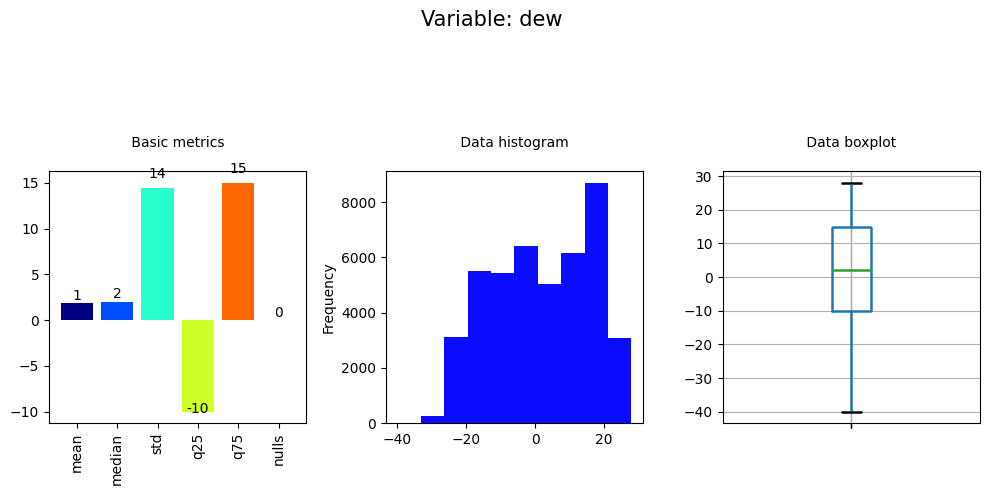

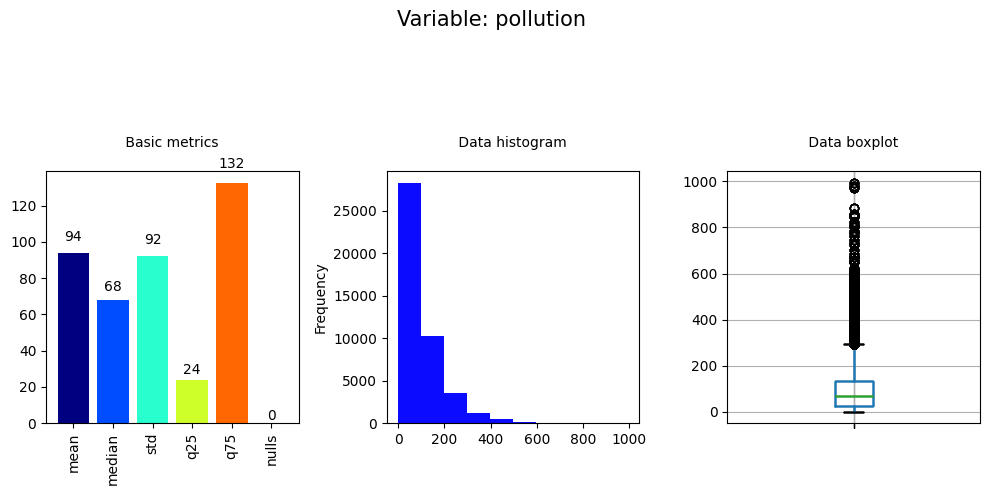

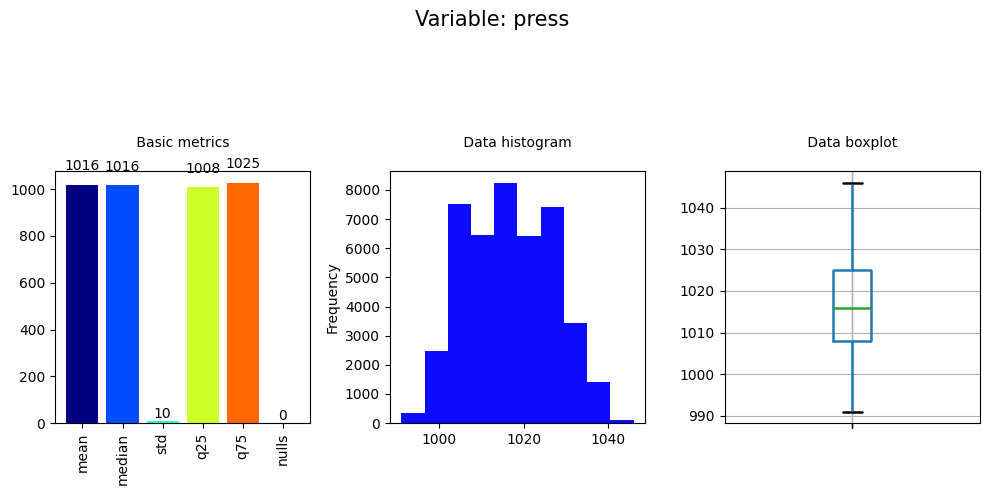

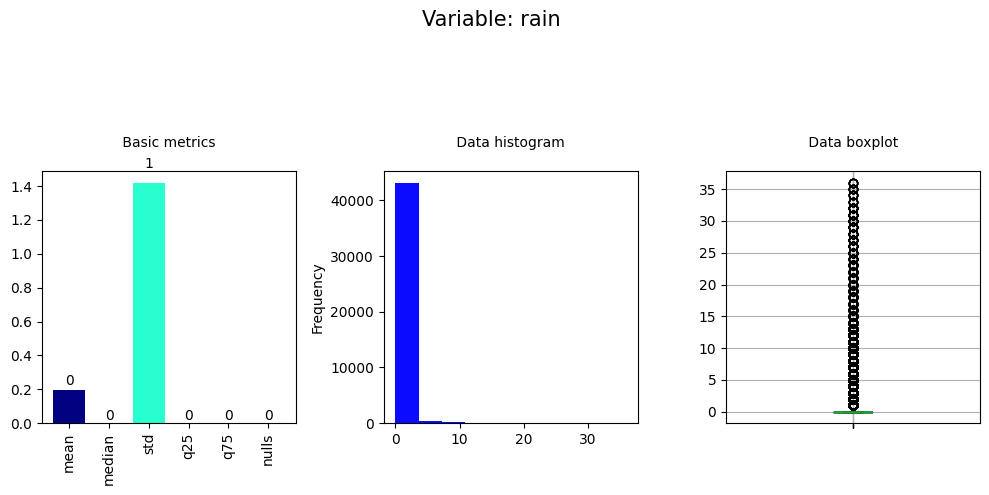

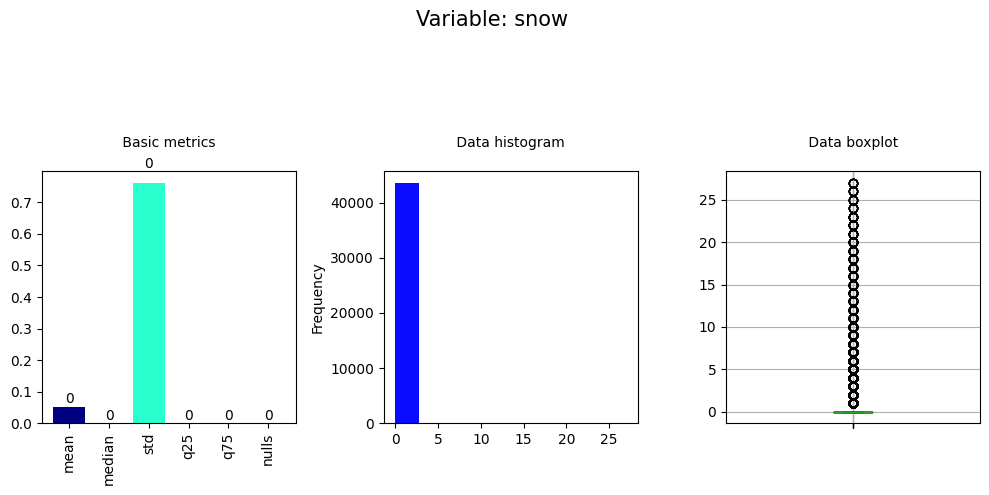

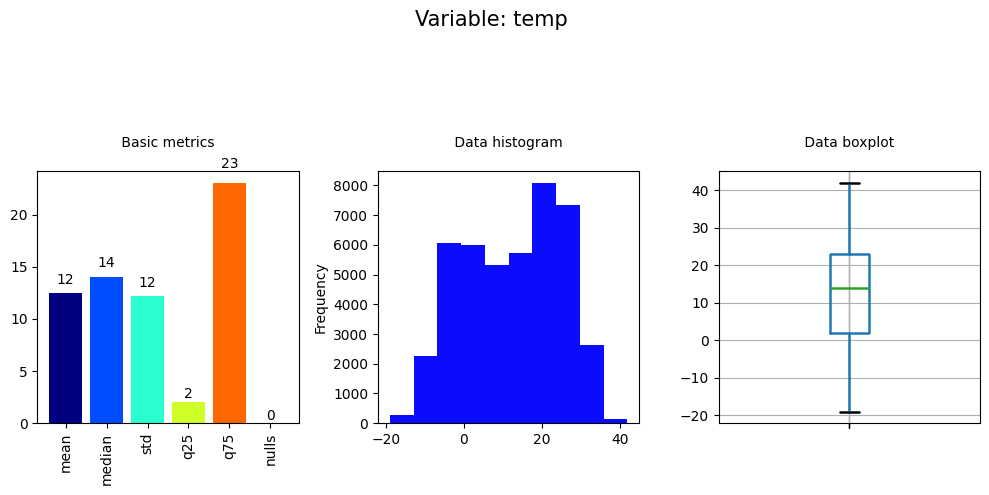

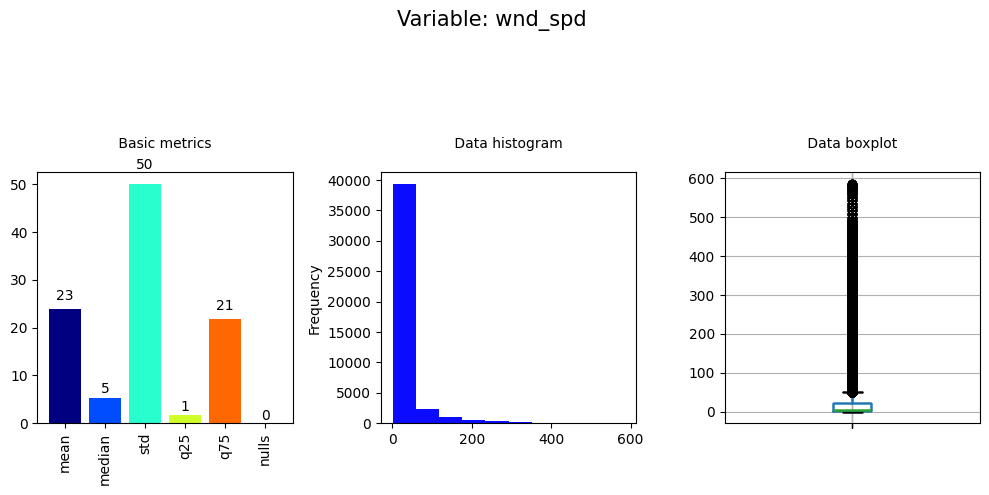

In [143]:
#Variables numéricas.
numeric_stats = get_numeric_stats(numeric_df)   
plot_numeric(df, numeric_stats)

En las gráficas de estadísticas básicas, podemos ver lo siguiente:
+ `dew`: No tiene datos atípicos y su distribución no está muy anormal
+ `pollution`: Contiene varios datos atípicos, su promedio es de 94 y los valores suelen acotarse entre 24 y 132
+ `press`: No hay datos atípicos y la distribución parece acercarse a la normal, los valores son muy similares entre sí
+ `rain`: El promedio es de 0 y hay bastantes atípicos
+ `snow`: Al igual que la variable de lluvia, su promedio es 0 y hay muchos atípicos, esto no debe alarmar ya que son las horas acumuladas de nieve/lluvia
+ `temp`: No hay atípicos y su distribución parece ser normal, el promedio es de 14
+ `wnd_spd`: Hay bastantes atípicos y la desviación estándar es muy alta, igual no hay que alarmarse ya que es la velocidad del viento acumulada

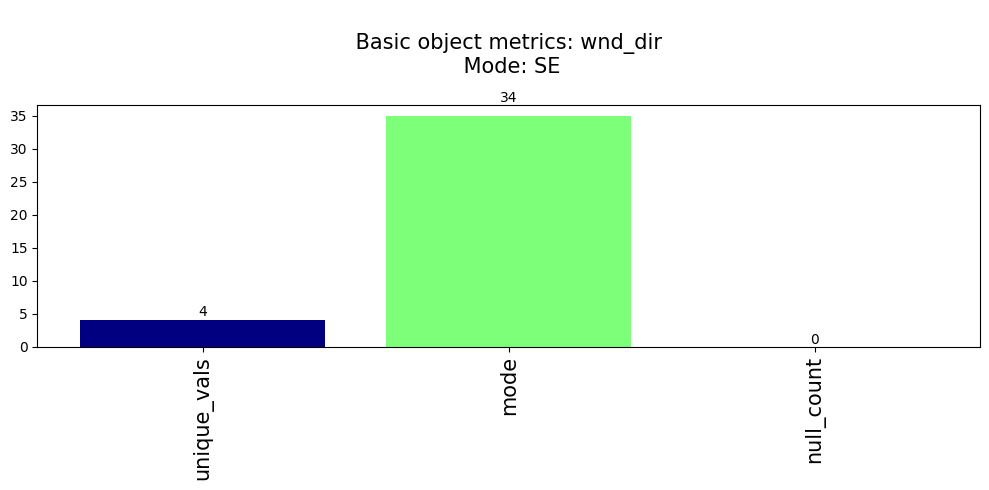

In [144]:
#Variables categóricas.
object_cols = df.select_dtypes(include=['object', 'category'])
object_df = object_cols.loc[:, ~object_cols.columns.str.contains('date', case=False)]
cat_stats = get_cat_stats(object_df)
plot_categorical(df, cat_stats)

Aquí podemos ver que la variable `wnd_dir` tiene 4 posibles valores y la moda es SE, indicando South-East.

In [145]:
df_codificado = df.copy()

In [146]:
def label_encode_variables_categoricas(df_codificado):
    # Selecciona las columnas de tipo objeto (categóricas)
    columnas_objeto = df_codificado.select_dtypes(include=['object']).columns

    # Inicializa el codificador
    label_encoder = LabelEncoder()

    # Itera sobre las columnas seleccionadas y aplica el label encoding
    for columna in columnas_objeto:
        df_codificado[columna] = label_encoder.fit_transform(df_codificado[columna])

    return df_codificado

df_para_corr = label_encode_variables_categoricas(df_codificado)

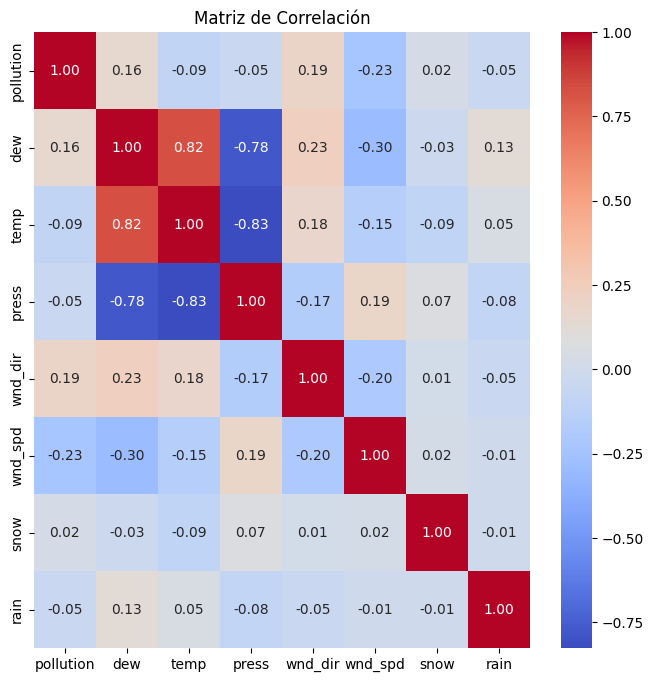

In [147]:
# Calcula la matriz de correlación excluyendo la columna date
matriz_correlacion = df_para_corr.drop('date', axis=1).corr()

# Configura el tamaño de la figura
plt.figure(figsize=(8, 8))

# Genera la matriz de correlación con Seaborn
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f")

# Añade título
plt.title('Matriz de Correlación')

# Muestra la matriz de correlación
plt.show()

Matriz de correlaciones:
1. Relaciones positivas fuertes
    + `temp` y `dew` tienen una correlación positiva de 0.82
2. Relaciones negativas fuertes
    + `press` y `dew` tienen una correlación negativa de -0.78, `press` y `temp` de -0.83

Las demás variables no muestran fuerte correlación con la siguiente más correlacionada siendo `dew` y `wnd_spd` con -0.30 

### Análisis univariado para SARIMAX

In [148]:
# Convert date column to datetime if it isn't already
df['date'] = pd.to_datetime(df['date'])

# Create time series with date as index and pollution as values
time_series = df.set_index('date')['pollution']
time_series = pd.DataFrame(time_series)
time_series = time_series.rename(columns={'pollution': 'y'})
time_series.head()

y
date                      
2010-01-02 00:00:00  129.0
2010-01-02 01:00:00  148.0
2010-01-02 02:00:00  159.0
2010-01-02 03:00:00  181.0
2010-01-02 04:00:00  138.0

In [149]:
time_series.shape

(43800, 1)

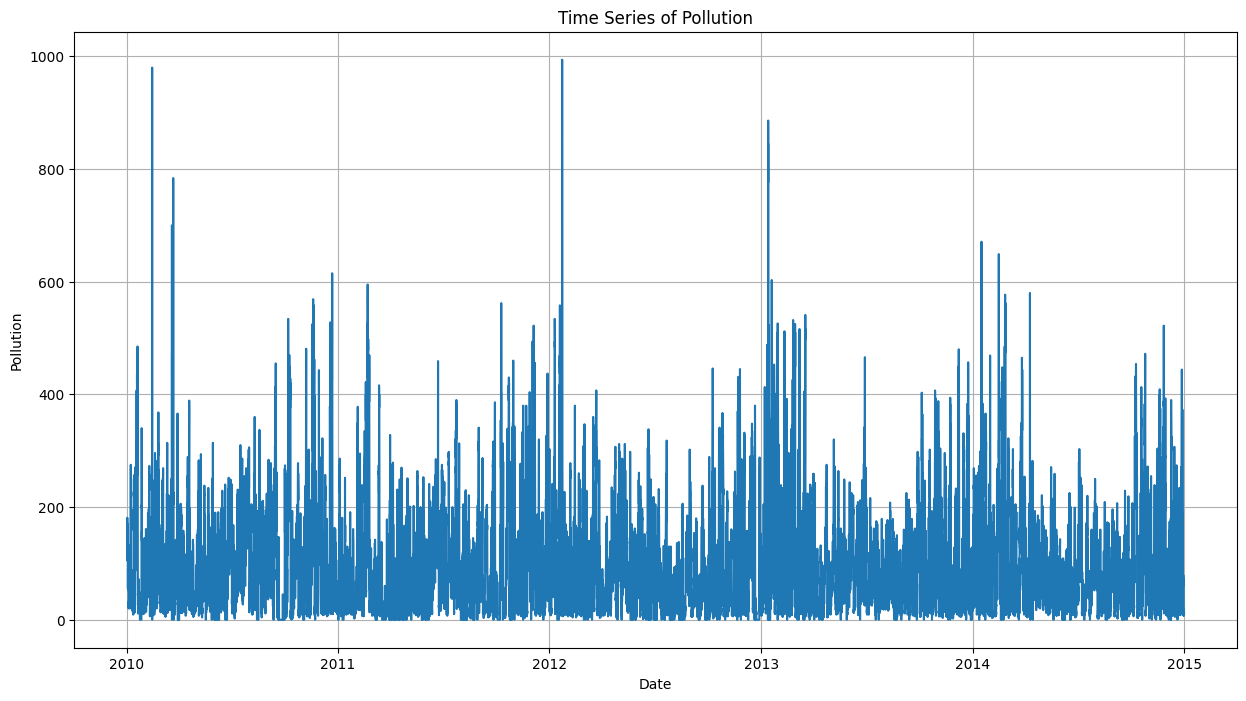

In [150]:
# Plot the time series
plt.figure(figsize=(15, 8))
plt.plot(time_series.index, time_series['y'])
plt.title('Time Series of Pollution')
plt.xlabel('Date')
plt.ylabel('Pollution')
plt.grid()
plt.show()

<Axes: >

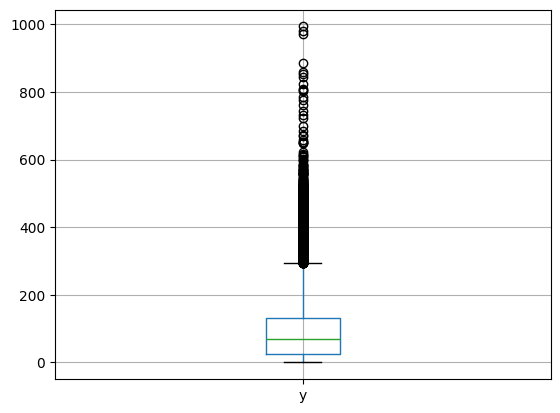

In [151]:
# Vamos a graficar el boxplot
time_series.boxplot()

In [152]:
# Detectar outliers con IQR
Q1 = time_series['y'].quantile(0.25)
Q3 = time_series['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = time_series[(time_series['y'] < lower_bound) | (time_series['y'] > upper_bound)]
print("Outliers detected:")
print(outliers)

Outliers detected:
                         y
date                      
2010-01-17 21:00:00  317.0
2010-01-17 23:00:00  313.0
2010-01-18 02:00:00  303.0
2010-01-18 03:00:00  349.0
2010-01-18 04:00:00  407.0
...                    ...
2014-12-29 00:00:00  362.0
2014-12-29 01:00:00  372.0
2014-12-29 02:00:00  373.0
2014-12-29 03:00:00  372.0
2014-12-29 04:00:00  318.0

[1878 rows x 1 columns]


In [153]:
reporte(outliers)

Tipo  Valores_Nulos  Valores_Unicos    Max    Min
y  float64              0             286  994.0  295.0

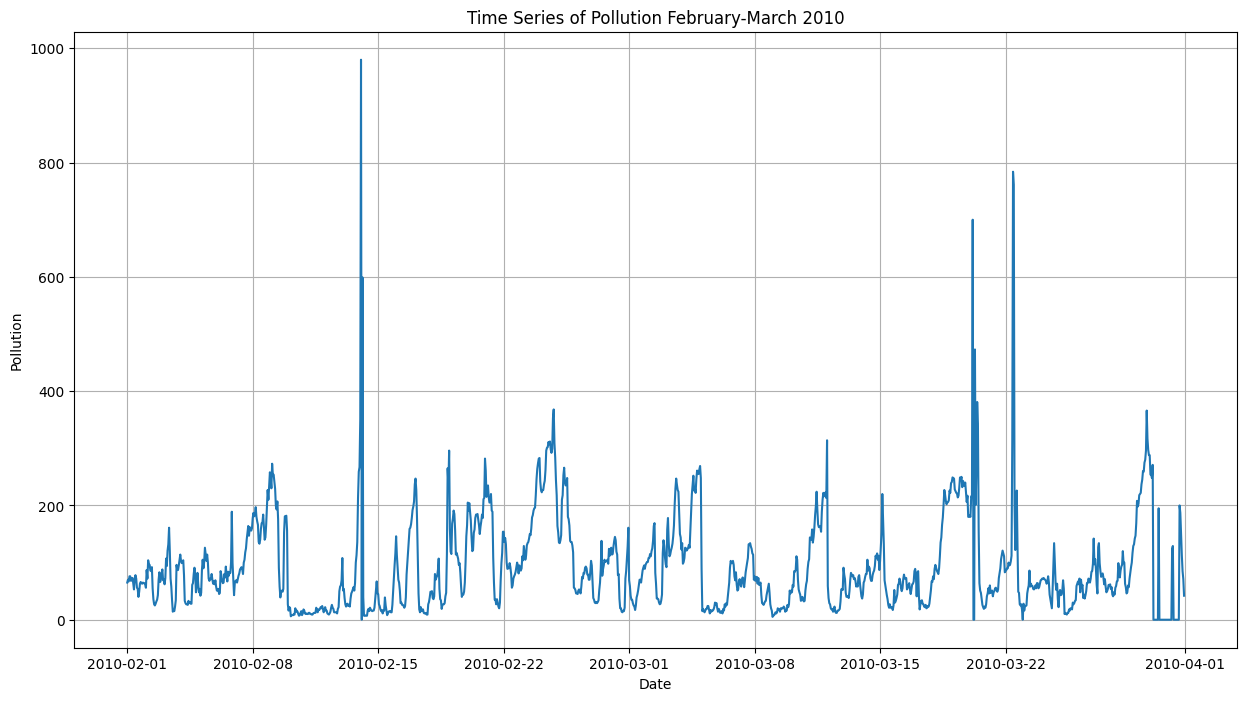

In [154]:
# Filter time series for 2010-2011
time_series_2010_2011 = time_series['2010-02':'2010-03']

# Plot the filtered time series
plt.figure(figsize=(15, 8))
plt.plot(time_series_2010_2011.index, time_series_2010_2011['y'])
plt.title('Time Series of Pollution February-March 2010')
plt.xlabel('Date') 
plt.ylabel('Pollution')
plt.grid()
plt.show()


Al graficar y analizar la variable de interés, nos encontramos con varios datos atípicos, primero en el boxplot y después con el método del rango intercuartil. De los 43,800 registros que tenemos, nos marca 1,878 atípicos. Al ver una muestra de los que marca como atípicos, vemos valores superiores a 300. Al usar nuestra función de reporte, vemos que alcanzan máximos de hasta 994.

Después de una breve investigación, encontramos que la página oficial de calidad del aire de Estados Unidos, AirNow, tiene los siguientes rangos de calidad:

![Air Quality Table](images/Air_pollution_table.png)

Con esta información, podría parecer que son errores de medición, sin embargo, valores de más de 300 pueden ser totalmentes posibles, ya que graficamos una parte en donde se encuentran estos valores atípicos, y parece que los días siguientes al atípico siguen siendo valores grandes, entonces no son ni errores de medición ni imposibles. Es por esto que decidimos dejarlos.

AQI Basics | AirNow.gov. (n.d.). https://www.airnow.gov/aqi/aqi-basics/

In [155]:
# Dividir los datos en entrenamiento y prueba
n_train = int(0.75 * len(time_series))
train_data = time_series[:n_train]
n_test = len(time_series) - n_train
test_data = time_series[-n_test:]

In [21]:
lf = LinearForecast(data=train_data)

In [22]:
lf.adf_test() # Estacionariedad de los datos originales
# Vamos a visualizar todas las transformaciones para luego decidir cuál será la elegida

Results of Dickey-Fuller Test:
Test Statistic                -1.812484e+01
p-value                        2.515619e-30
#Lags Used                     5.200000e+01
Number of Observations Used    3.279700e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


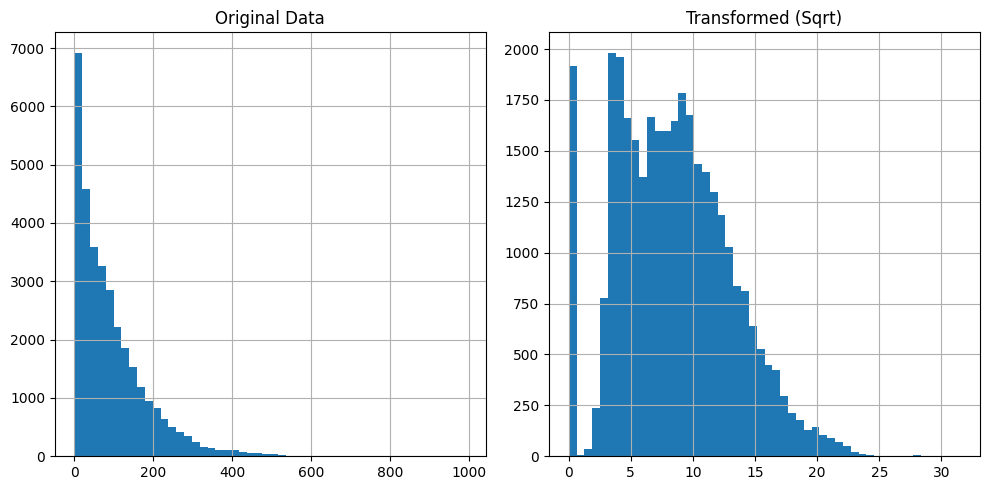

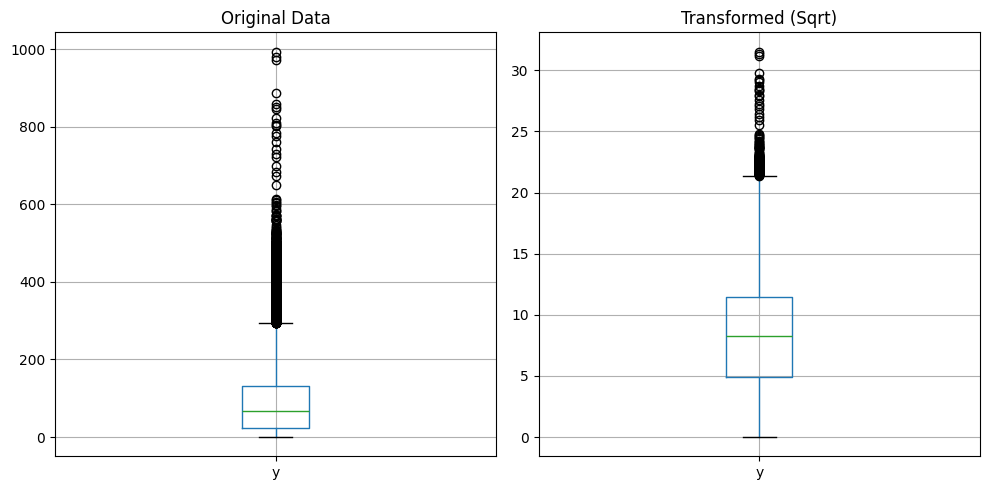

In [23]:
lf.timeseries_transformation(transformation="sqrt")

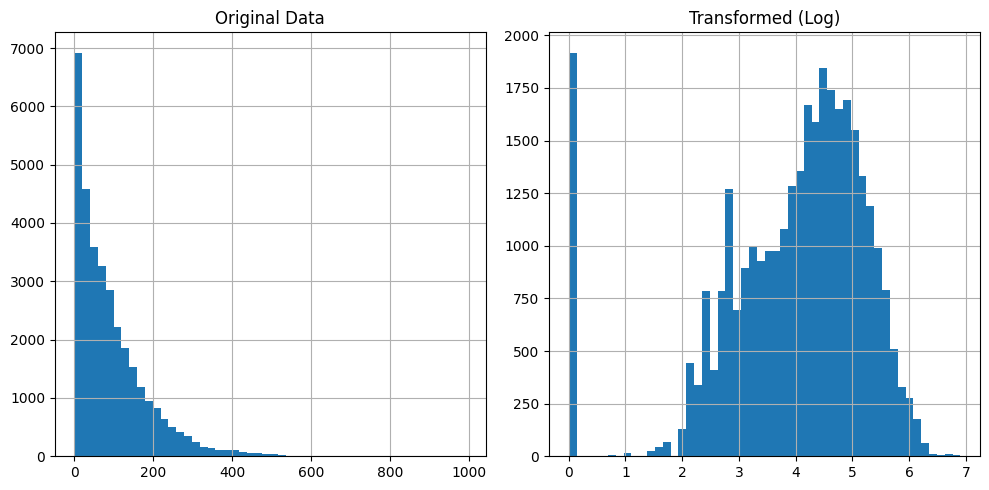

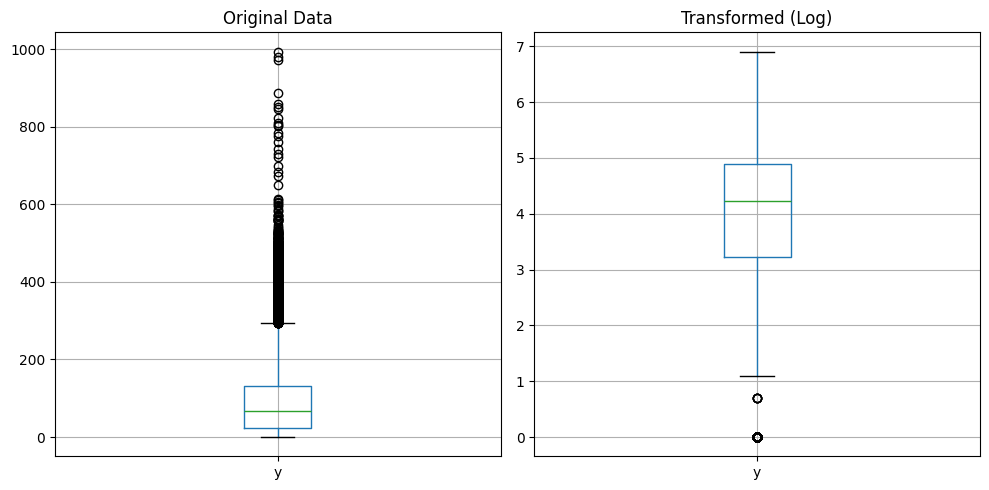

In [24]:
lf.timeseries_transformation(transformation="log")

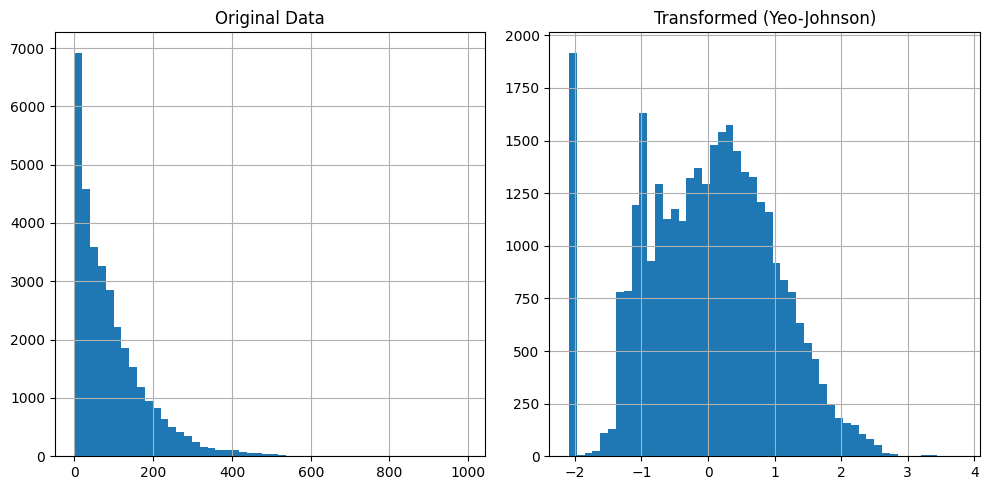

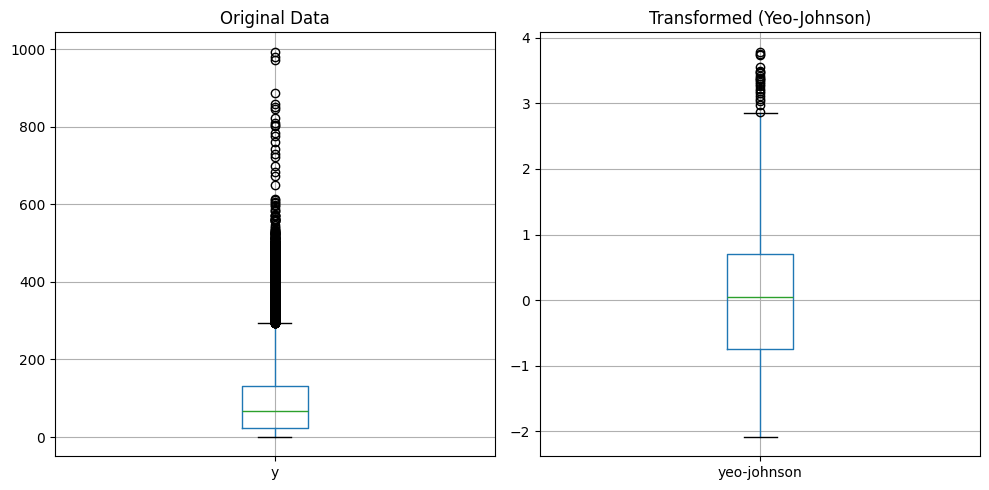

In [25]:
lf.timeseries_transformation(transformation="yeo-johnson")

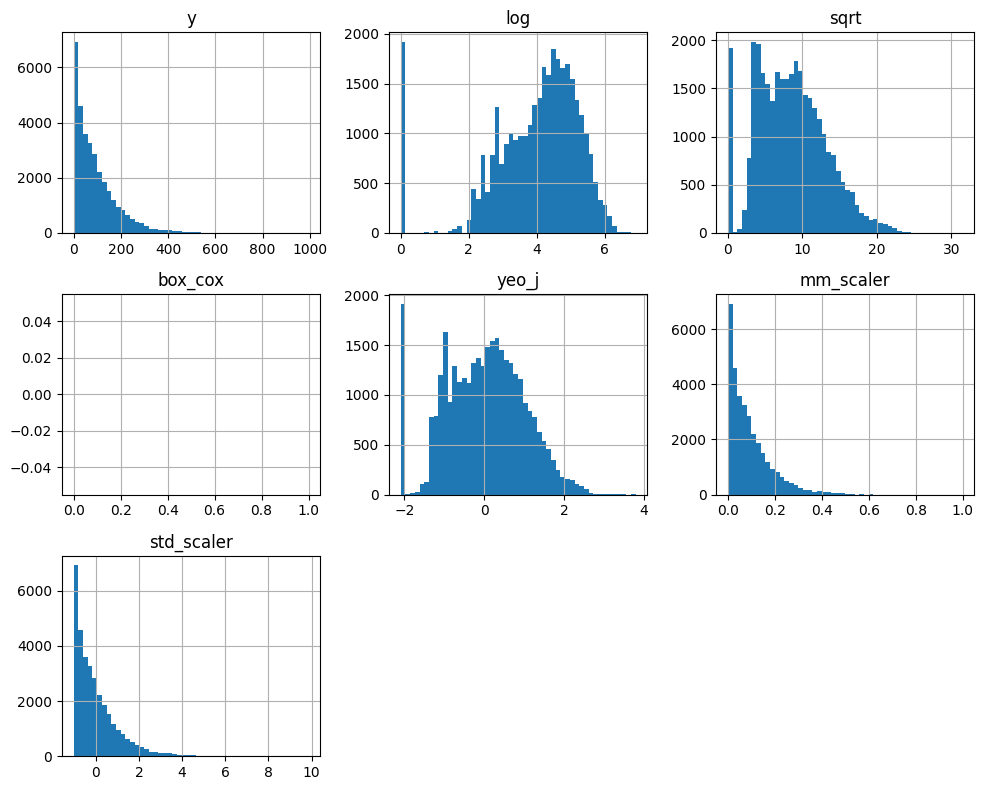

y       log       sqrt  box_cox     yeo_j  mm_scaler  \
date                                                                            
2010-01-02 00:00:00  129.0  4.867534  11.357817      NaN  0.679100   0.129779   
2010-01-02 01:00:00  148.0  5.003946  12.165525      NaN  0.832137   0.148893   
2010-01-02 02:00:00  159.0  5.075174  12.609520      NaN  0.914642   0.159960   
2010-01-02 03:00:00  181.0  5.204007  13.453624      NaN  1.068560   0.182093   
2010-01-02 04:00:00  138.0  4.934474  11.747340      NaN  0.753393   0.138833   

                     std_scaler  
date                             
2010-01-02 00:00:00    0.392923  
2010-01-02 01:00:00    0.600763  
2010-01-02 02:00:00    0.721092  
2010-01-02 03:00:00    0.961749  
2010-01-02 04:00:00    0.491374

In [26]:
train, lambda_value = lf.consolidated_ts_df(data=train_data, plot_graphs=True)
train.head()

Después de ver los resultados de las transformaciones, elegiremos la de yeo-johnson. La segunda mejor fue la de log, sin embargo, como hay valores que son 0 en nuestra serie (misma razón por la cuál no aplicó box-cox), la de yeo-johnson es mejor.

In [27]:
train.drop([col for col in train.columns if 'yeo_j' not in col], axis=1, inplace=True)
train.rename(columns={'yeo_j': 'y'}, inplace=True)

In [28]:
lf = LinearForecast(data=train)

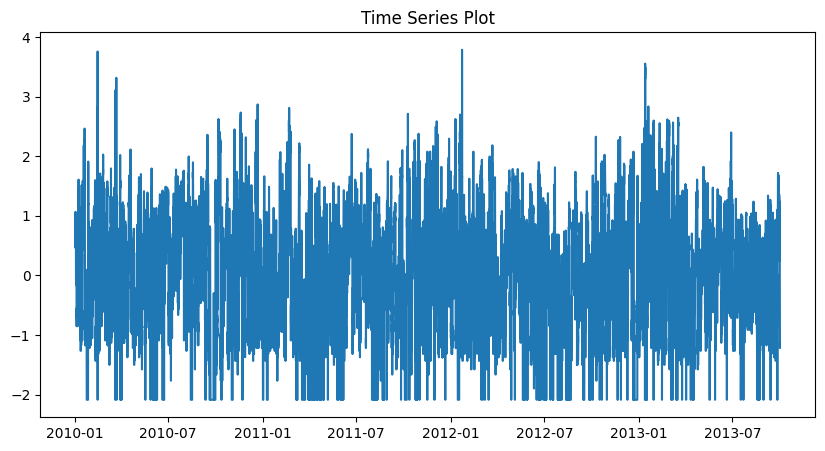

In [29]:
lf.plot_time_series()

Ahora evaluaremos la estacionariedad con la prueba de ADF y la descomposición para analizar los componentes.

In [30]:
lf.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -1.805301e+01
p-value                        2.635913e-30
#Lags Used                     5.100000e+01
Number of Observations Used    3.279800e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


In [31]:
def mstl_descomposition1(data, periods_seasonality, stl_kwargs=None):
    """
    Perform MSTL decomposition to identify trend, seasonal, and residual components of a time series.

    Parameters:
        periods_seasonality (list): List of seasonal periods to be considered.
        stl_kwargs (dict, optional): Additional keyword arguments for STL decomposition.

    Returns:
        DecomposeResult: A result object that includes trend, seasonal components, and residuals.
    """
    if stl_kwargs is None:
        stl_kwargs = {}

    if data is None or data.empty:
        raise ValueError("The data parameter is empty or None.")

    y = data['y']
    mstl = MSTL(endog=y, periods=periods_seasonality, **stl_kwargs)
    result = mstl.fit()

    return result

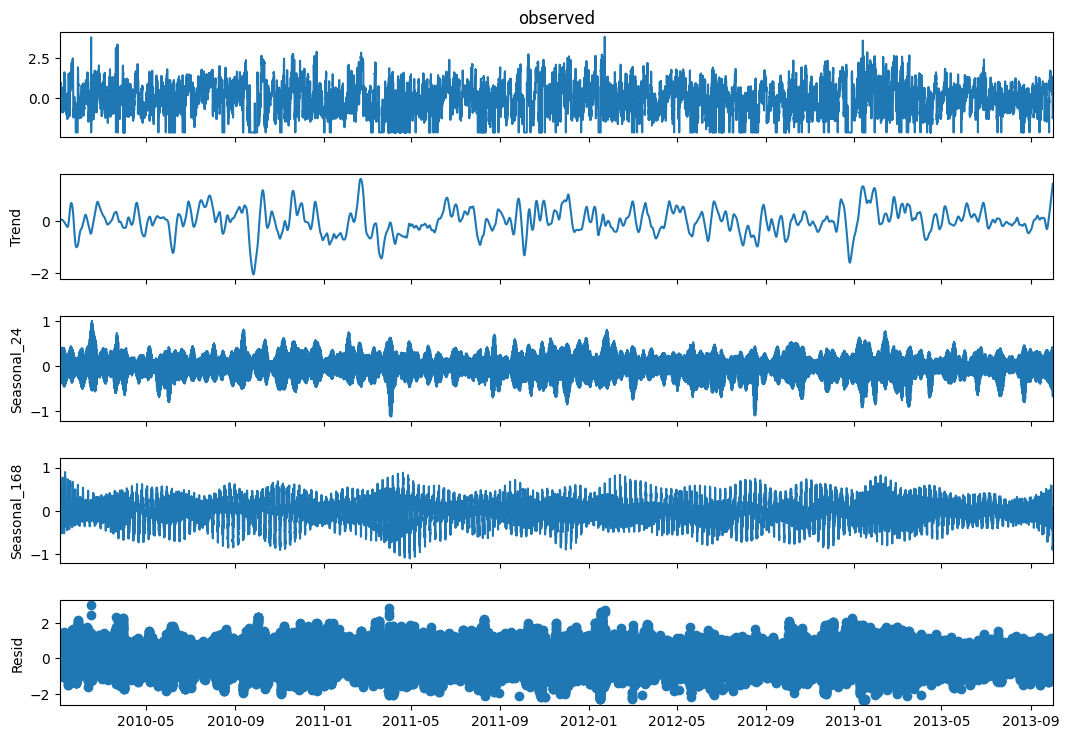

In [32]:
res = mstl_descomposition1(train,periods_seasonality=[24, 168]) # 24 por ser diario, 168 semanal
res.plot().set_size_inches(12, 8)
plt.show()

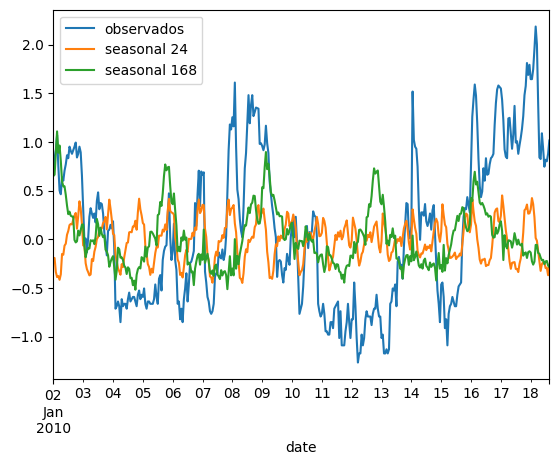

In [33]:
# Graficar datos observados con datos de estacionalidad
ax = res.observed[:400].plot(label='observados')

res.seasonal['seasonal_24'][:400].plot(ax=ax, label='seasonal 24')
res.seasonal['seasonal_168'][:400].plot(ax=ax, label='seasonal 168')

plt.legend()
plt.show()

##### Estacionariedad de la estacionalidad encontrada

In [34]:
# En base a la estacionalidad seleccionada, calcular la estacionariedad de dicha serie temporal
seasonality_24 = res.seasonal['seasonal_24']

lf.adf_test(seasonality_24)

Results of Dickey-Fuller Test:
Test Statistic                   -44.053653
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    32797.000000
Critical Value (1%)               -3.430549
Critical Value (5%)               -2.861628
Critical Value (10%)              -2.566817
dtype: float64
Stationary


In [35]:
# Estacionariedad de la segunda parte estacional
seasonality_168 = res.seasonal['seasonal_168']

lf.adf_test(seasonality_168)

Results of Dickey-Fuller Test:
Test Statistic                   -26.059571
p-value                            0.000000
#Lags Used                        51.000000
Number of Observations Used    32798.000000
Critical Value (1%)               -3.430549
Critical Value (5%)               -2.861628
Critical Value (10%)              -2.566817
dtype: float64
Stationary


In [36]:
trend_data = res.trend
resid_data = res.resid

In [37]:
lf.adf_test(trend_data) # Estacionariedad de la tendencia

Results of Dickey-Fuller Test:
Test Statistic                -8.902856e+00
p-value                        1.158723e-14
#Lags Used                     4.500000e+01
Number of Observations Used    3.280400e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


In [38]:
lf.adf_test(resid_data) # Estacionariedad de residuos

Results of Dickey-Fuller Test:
Test Statistic                   -25.814689
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    32797.000000
Critical Value (1%)               -3.430549
Critical Value (5%)               -2.861628
Critical Value (10%)              -2.566817
dtype: float64
Stationary


##### Genere los correlogramas ACF y PACF para evaluar patrones de autocorrelación.

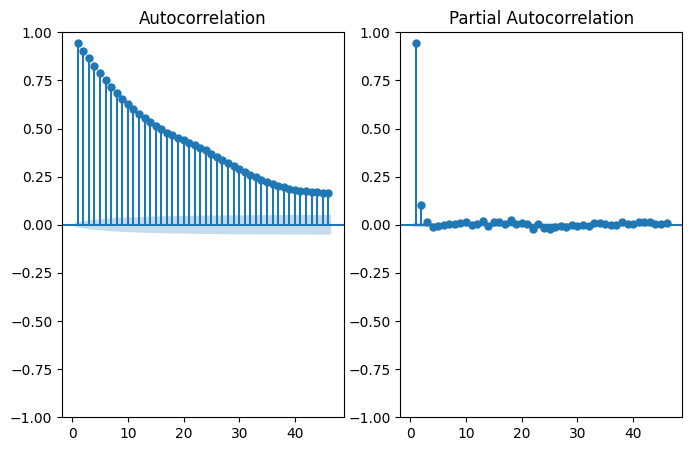

In [39]:
lf.plot_acf_pacf()

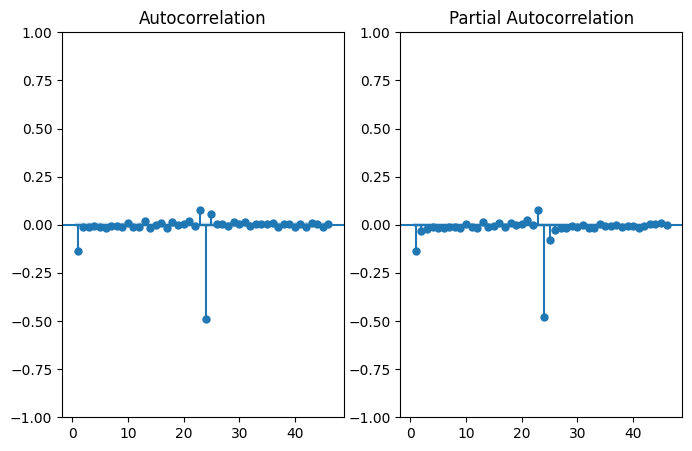

In [40]:
lf.plot_acf_pacf(data=train.diff().diff(24).dropna())

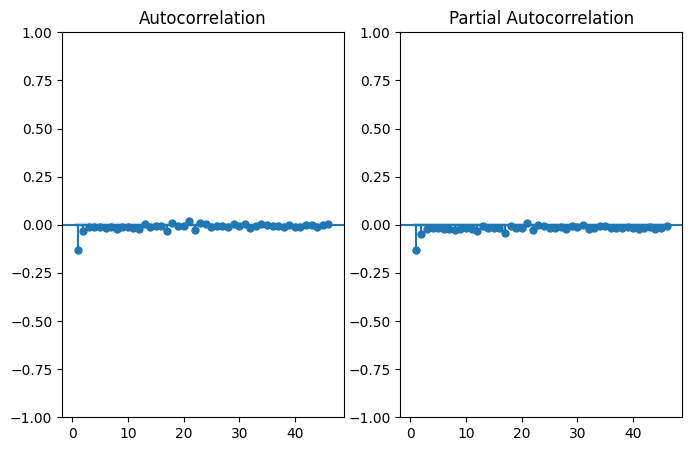

In [41]:
lf.plot_acf_pacf(data=train.diff().diff(168).dropna())

Basado en las gráficas, los posibles valores son:

P -> 1

D -> 1

Q -> 1

Ahora para el componenete no estacional

In [42]:
# Calcular la estacionariedad de mis datos observados
lf.adf_test(res.observed.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.805301e+01
p-value                        2.635913e-30
#Lags Used                     5.100000e+01
Number of Observations Used    3.279800e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


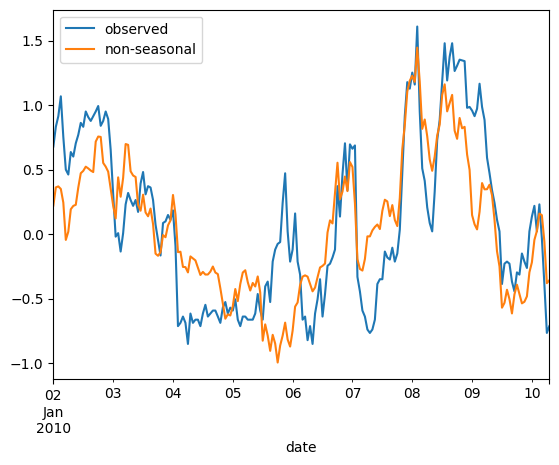

In [43]:
# Calcular la componente no estacional de la serie temporal basado en la S anterior
non_seasonal = res.observed - res.seasonal['seasonal_24'] - res.seasonal['seasonal_168'] 

res.observed[:200].plot()
non_seasonal[:200].plot()
plt.legend(['observed', 'non-seasonal'])

In [44]:
# Calcular si la serie no estacional es estacionaria o no
lf.adf_test(non_seasonal.dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.510651e+01
p-value                        7.805352e-28
#Lags Used                     5.200000e+01
Number of Observations Used    3.279700e+04
Critical Value (1%)           -3.430549e+00
Critical Value (5%)           -2.861628e+00
Critical Value (10%)          -2.566817e+00
dtype: float64
Stationary


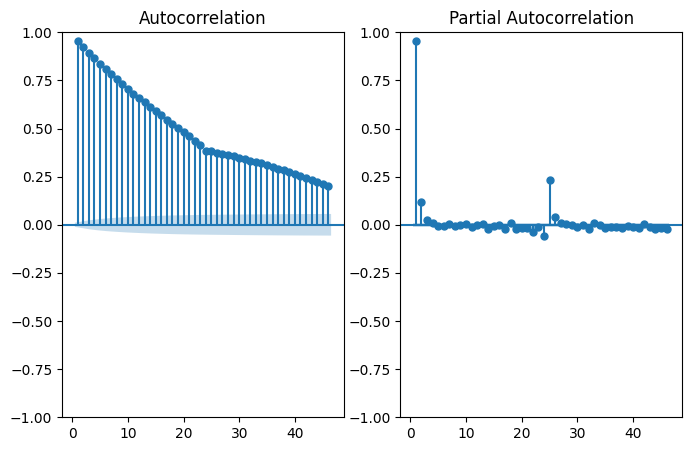

In [45]:
lf.plot_acf_pacf(non_seasonal.dropna())

Para los posibles valores son:

p -> 2

d -> 0

q -> 0

### SARIMAX

In [156]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
# Transformar los datos de entrenamiento y prueba
train_transformed = pt.fit_transform(train_data.values.reshape(-1, 1))
test_transformed = pt.transform(test_data.values.reshape(-1, 1))

Vamos a loggear el experimento en MLFlow.

In [197]:
dagshub.init(url="https://dagshub.com/daduke1/proyecto-modelos", mlflow=True)

MLFLOW_TRACKING_URI = mlflow.get_tracking_uri()

print(MLFLOW_TRACKING_URI)

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(experiment_name="regresion")

Initialized MLflow to track repo "daduke1/proyecto-modelos"

Repository daduke1/proyecto-modelos initialized!

https://dagshub.com/daduke1/proyecto-modelos.mlflow


<Experiment: artifact_location='mlflow-artifacts:/15e9e4d7f3194c0580cd27a1d80f5cac', creation_time=1747164262903, experiment_id='2', last_update_time=1747164262903, lifecycle_stage='active', name='regresion', tags={}>

In [48]:
order = (2, 0, 0)
seasonal_order = (1, 1, 1, 24)

with mlflow.start_run() as run:
    # Log parameters
    mlflow.log_param("order", order)
    mlflow.log_param("seasonal_order", seasonal_order)

    # Fit model
    model = SARIMAX(train_transformed, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    # Save model
    #model_file = "sarimax_model.pkl"
    #joblib.dump(results, model_file)
    #mlflow.log_artifact(model_file)

    # Forecast
    forecast_trans = results.forecast(steps=len(test_transformed))
    forecast_trans = pd.DataFrame(forecast_trans)
    forecast_inv = pt.inverse_transform(forecast_trans).flatten()

    # Compute and log metrics
    rmse = np.sqrt(mean_squared_error(test_data, forecast_inv))
    mse = mean_squared_error(test_data, forecast_inv)
    mape = mean_absolute_percentage_error(test_data, forecast_inv)
    r2 = r2_score(test_data, forecast_inv)

    #mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("R2", r2)

    # Log model summary
    summary_file = "results/sarimax/model_summary.txt"
    with open(summary_file, "w") as f:
        f.write(results.summary().as_text())
    mlflow.log_artifact(summary_file)

    # Plot forecast vs actual
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data, label="Actual")
    plt.plot(test_data.index, forecast_inv, label="Forecast", linestyle='--')
    plt.title("SARIMAX Forecast vs Actual (Test Set)")
    plt.legend()
    plt.tight_layout()
    plot_file = "results/forecast_vs_actual.png"
    plt.savefig(plot_file)
    plt.close()
    mlflow.log_artifact(plot_file)

    print(f"Logged SARIMAX model. RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R²: {r2:.3f}")

Logged SARIMAX model. RMSE: 99.39, MAPE: 335023554262301760.00%, R²: -0.103
🏃 View run dashing-ant-978 at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/230acf3460204647b777d7ab5de875d7
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


El modelo SARIMAX dió las siguientes métricas:

+ RMSE: 99.39
+ MAPE: 335023554262301760.00%
+ R2: -0.103

### Redes Neuronal (univariado)

In [49]:
time_series.shape

(43800, 1)

In [158]:
def preprocess_univariate_series(
    df, 
    n_past=24, 
    n_future=1, 
    train_ratio=0.7, 
    val_ratio=0.15,
    scale=True,
    differencing=False
):
    """
    Prepares univariate time series for MLP/CNN/LSTM/ConvLSTM.
    
    Args:
        df (pd.DataFrame): DataFrame with datetime index and 'y' column.
        n_past (int): Lookback window (e.g., 24 hours).
        n_future (int): Forecast horizon (e.g., 1 for next step).
        train_ratio (float): Ratio of training data.
        val_ratio (float): Ratio of validation data.
        scale (bool): Whether to scale the data.
        differencing (bool): Whether to apply differencing.
    
    Returns:
        Dict: Processed data and metadata for all models.
              Keys: 'X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test',
                    'scaler', 'input_shape_mlp', 'input_shape_cnn', 
                    'input_shape_lstm', 'input_shape_convlstm'
    """
    # Extract values and handle NaNs
    series = df['y'].dropna().values.reshape(-1, 1)
    
    # Differencing (optional)
    if differencing:
        series = np.diff(series.flatten(), n=1).reshape(-1, 1)
    
    # Scaling (fit only on training data)
    scaler = RobustScaler() if scale else None
    if scale:
        train_size = int(len(series) * train_ratio)
        scaler.fit(series[:train_size])
        series = scaler.transform(series)
    
    # Generate input-output pairs
    X, y = [], []
    for i in range(n_past, len(series) - n_future + 1):
        X.append(series[i-n_past:i, 0])
        y.append(series[i:i+n_future, 0])
    X, y = np.array(X), np.array(y)
    
    # Split into train/val/test
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    # Define input shapes for each model type
    input_shape_mlp = (n_past,)          # MLP: (timesteps,)
    input_shape_cnn = (n_past, 1)        # CNN: (timesteps, features)
    input_shape_lstm = (n_past, 1)       # LSTM: (timesteps, features)
    input_shape_convlstm = (1, n_past, 1)  # ConvLSTM: (samples, timesteps, features, channels)
    
    # Reshape X for each model type
    X_train_mlp = X_train
    X_train_cnn = X_train.reshape(-1, *input_shape_cnn)
    X_train_lstm = X_train.reshape(-1, *input_shape_lstm)
    X_train_convlstm = X_train.reshape(-1, *input_shape_convlstm)
    
    # Repeat for val/test
    X_val_mlp = X_val
    X_val_cnn = X_val.reshape(-1, *input_shape_cnn)
    X_val_lstm = X_val.reshape(-1, *input_shape_lstm)
    X_val_convlstm = X_val.reshape(-1, *input_shape_convlstm)
    
    X_test_mlp = X_test
    X_test_cnn = X_test.reshape(-1, *input_shape_cnn)
    X_test_lstm = X_test.reshape(-1, *input_shape_lstm)
    X_test_convlstm = X_test.reshape(-1, *input_shape_convlstm)
    
    return {
        # Processed data
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        
        # Model-specific reshapes
        'X_train_mlp': X_train_mlp, 'X_val_mlp': X_val_mlp, 'X_test_mlp': X_test_mlp,
        'X_train_cnn': X_train_cnn, 'X_val_cnn': X_val_cnn, 'X_test_cnn': X_test_cnn,
        'X_train_lstm': X_train_lstm, 'X_val_lstm': X_val_lstm, 'X_test_lstm': X_test_lstm,
        'X_train_convlstm': X_train_convlstm, 'X_val_convlstm': X_val_convlstm, 'X_test_convlstm': X_test_convlstm,
        
        # Metadata
        'scaler': scaler,
        'input_shapes': {
            'mlp': input_shape_mlp,
            'cnn': input_shape_cnn,
            'lstm': input_shape_lstm,
            'convlstm': input_shape_convlstm
        }
    }

Nuestra función de pre-procesamiento toma como argumento nuestra serie univariada y aplica el siguiente flujo de procesamiento:

1. Quita valores NaNs si es que hay
2. Escala los datos usando RobustScaler pero sólo en los datos de entrenamiento para evitar leakage
3. Genera los inputs y outputs, usando 24 de input y 1 de output
4. Divide en datos de entrenamiento, validación y prueba
5. Define los shapes para cada modelo que implementaremos
6. Hace el reshape necesario para tener los datos para entrenar los modelos
7. Regresa los datos divididos tanto generalmente como para cada modelo (con sus respectivos shapes) y los valores y

In [159]:
n_past = 24
n_future = 1
univariate_data = preprocess_univariate_series(time_series,
    n_past=n_past, 
    n_future=n_future, 
    train_ratio=0.7,
    val_ratio=0.15,
    scale=True,
    differencing=False
)
univariate_data

{'X_train': array([[ 0.53571429,  0.70535714,  0.80357143, ...,  0.84821429,
          0.77678571,  0.50892857],
        [ 0.70535714,  0.80357143,  1.        , ...,  0.77678571,
          0.50892857,  0.1875    ],
        [ 0.80357143,  1.        ,  0.61607143, ...,  0.50892857,
          0.1875    , -0.05357143],
        ...,
        [ 1.08928571,  1.10714286,  1.16071429, ..., -0.48214286,
         -0.53571429, -0.5       ],
        [ 1.10714286,  1.16071429,  0.77678571, ..., -0.53571429,
         -0.5       , -0.49107143],
        [ 1.16071429,  0.77678571,  0.3125    , ..., -0.5       ,
         -0.49107143, -0.5       ]]),
 'y_train': array([[ 0.1875    ],
        [-0.05357143],
        [-0.03571429],
        ...,
        [-0.49107143],
        [-0.5       ],
        [-0.45535714]]),
 'X_val': array([[ 0.77678571,  0.3125    ,  0.23214286, ..., -0.49107143,
         -0.5       , -0.45535714],
        [ 0.3125    ,  0.23214286,  0.        , ..., -0.5       ,
         -0.45535714,

In [52]:
def plot_data_split(X_train, X_val, X_test, title=None):
    """
    Visualize the train/validation/test split of time series data.
    
    Args:
        X_train: Training data (3D array: samples, timesteps, features)
        X_val: Validation data
        X_test: Test data
    """
    # Create numerical indices for each set
    train_idx = np.arange(len(X_train))
    val_idx = np.arange(len(X_train), len(X_train) + len(X_val))
    test_idx = np.arange(len(X_train) + len(X_val), len(X_train) + len(X_val) + len(X_test))
    
    # Create figure
    plt.figure(figsize=(14, 6))
    
    # Plot the first timestep of each sequence
    plt.plot(train_idx, X_train[:, 0], label='Training', color='blue', alpha=0.7, linewidth=1)
    plt.plot(val_idx, X_val[:, 0], label='Validation', color='orange', alpha=0.7, linewidth=1)
    plt.plot(test_idx, X_test[:, 0], label='Test', color='green', alpha=0.7, linewidth=1)
    
    # Add divider lines
    plt.axvline(x=len(X_train), color='red', linestyle='--', alpha=0.5, linewidth=0.8)
    plt.axvline(x=len(X_train)+len(X_val), color='red', linestyle='--', alpha=0.5, linewidth=0.8)

    if title is None:
        title = 'Train/Validation/Test Split'
    
    plt.title(title, fontsize=14)
    plt.xlabel('Time Index', fontsize=12)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.legend(fontsize=10, framealpha=1)
    plt.grid(True, alpha=0.3)
    
    # Add data size annotations
    plt.text(0.01, 0.95, f'Train: {len(X_train)} samples', transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    plt.text(0.01, 0.88, f'Val: {len(X_val)} samples', transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    plt.text(0.01, 0.81, f'Test: {len(X_test)} samples', transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

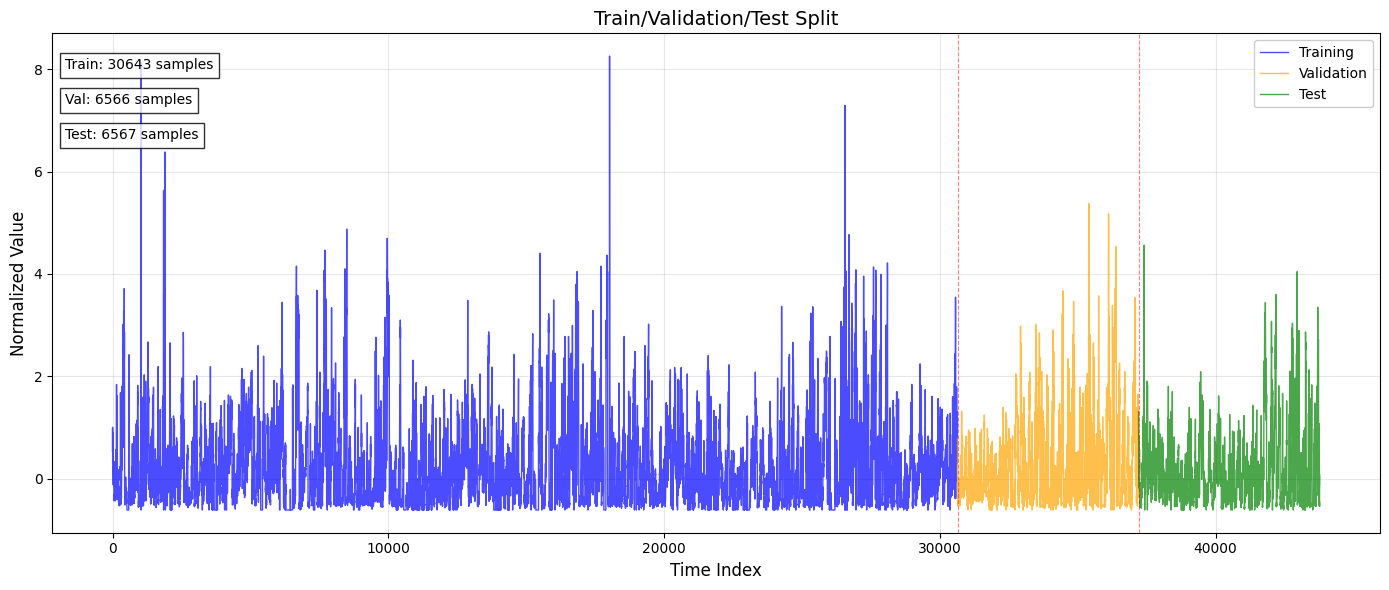

In [53]:
plot_data_split(
    univariate_data['X_train'], 
    univariate_data['X_val'], 
    univariate_data['X_test']
)

In [196]:
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt

def log_to_dagshub(
    model,
    architecture,
    model_type,
    X_test,
    y_test,
    scaler,
    preprocessing_info,
    n_future=12,
    experiment_name="proyecto-modelos-regresion"
):
    """
    Enhanced MLflow logging.
    
    Args:
        model: Trained Keras model (MLP/CNN/LSTM/ConvLSTM)
        model_type: Model type identifier ('mlp', 'cnn', 'lstm', 'convlstm')
        X_test: Test features (properly reshaped for model_type)
        y_test: Test targets
        scaler: Fitted scaler object
        preprocessing_info: Dict from preprocess_univariate_series()
        n_future: Prediction horizon length
        experiment_name: Existing experiment name from your notebook
    """
    # Use existing tracking setup
    with mlflow.start_run(run_name=f"{model_type}-{architecture}"):
        # ===== 1. Log Core Parameters =====
        mlflow.log_params({
            "model_type": model_type,
            "n_past": preprocessing_info['input_shapes'][model_type][0],
            "n_future": n_future,
            "scaler": str(scaler.__class__.__name__),
            "differencing": preprocessing_info.get("differenced", False),
            "train_samples": len(preprocessing_info['X_train']),
            "test_samples": len(X_test)
        })
        
        # ===== 2. Model Evaluation =====
        # Predict and calculate metrics
        y_pred = model.predict(X_test)
        
        if scaler:
            y_test_actual = scaler.inverse_transform(y_test.reshape(-1, n_future))
            y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, n_future))
        else:
            y_test_actual = y_test
            y_pred_actual = y_pred
        
        metrics = {
            'MSE': mean_squared_error(y_test_actual, y_pred_actual),
            'MAPE': mean_absolute_percentage_error(y_test_actual, y_pred_actual),
            'R2': r2_score(y_test_actual, y_pred_actual)
        }
        mlflow.log_metrics(metrics)
        
        # ===== 3. Model Logging =====
        # Add input/output signature
        signature = infer_signature(X_test, y_pred)
        mlflow.keras.log_model(
            model=model,
            artifact_path=f"{model_type}_model",
            signature=signature,
            registered_model_name=f"aqi_{model_type}_{architecture}"
        )
        
        # ===== 5. Visualization =====
        # Create and save prediction plot
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_actual[:100].flatten(), label='Actual', alpha=0.7)
        plt.plot(y_pred_actual[:100].flatten(), label='Predicted', linestyle='--')
        plt.title(f"{model_type.upper()} Predictions (First 100 Samples)")
        plt.xlabel("Time Steps")
        plt.ylabel("AQI Value")
        plt.legend()
        
        plot_path = f"results/{model_type}_predictions.png"
        plt.savefig(plot_path, bbox_inches='tight', dpi=300)
        mlflow.log_artifact(plot_path)
        plt.close()
        
        # ===== 6. Tagging =====
        mlflow.set_tag("project", "proyecto-modelos")
        mlflow.set_tag("task", "time_series_forecasting")
        mlflow.set_tag("data_type", "AQI")
        
        print(f"""\n✅ Successfully logged {model_type} to DagsHub:
        - Run ID: {mlflow.active_run().info.run_id}
        - Metrics: {metrics}
        - Model URI: runs:/{mlflow.active_run().info.run_id}/{model_type}_model
        """)

#### MLP

In [56]:
X_train_mlp = univariate_data['X_train_mlp']
X_val_mlp = univariate_data['X_val_mlp']
X_test_mlp = univariate_data['X_test_mlp']
y_train = univariate_data['y_train']
y_val = univariate_data['y_val']
y_test = univariate_data['y_test']
X_test_mlp.shape, X_val_mlp.shape, X_train_mlp.shape, y_train.shape, y_val.shape, y_test.shape

((6567, 24), (6566, 24), (30643, 24), (30643, 1), (6566, 1), (6567, 1))

In [183]:
def build_train_mlps(X_train, y_train, X_val, y_val, n_future=1, epochs=50, batch_size=32):
    """
    Builds, trains, and evaluates 3 MLP architectures for time series forecasting.
    
    Args:
        X_train, y_train: Training data (from `preprocess_univariate_series`).
        X_val, y_val: Validation data.
        n_future (int): Number of steps to predict.
        epochs (int): Training epochs.
        batch_size (int): Batch size.
    
    Returns:
        Dict: Trained models and their histories.
    """
    input_shape = X_train.shape[1]
    
    # --- Architecture 1: Simple Shallow MLP ---
    model_shallow = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(n_future)
    ])
    model_shallow.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 2: Deep MLP with Dropout ---
    model_deep = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(n_future)
    ])
    model_deep.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 3: Wide MLP with BatchNorm ---
    model_wide = Sequential([
        Dense(256, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(n_future)
    ])
    model_wide.compile(optimizer=Adam(), loss='mse')
    
    # Train all models
    print("Training Shallow MLP...")
    history_shallow = model_shallow.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Deep MLP...")
    history_deep = model_deep.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Wide MLP...")
    history_wide = model_wide.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    return {
        'models': {
            'shallow': model_shallow,
            'deep': model_deep,
            'wide': model_wide
        },
        'histories': {
            'shallow': history_shallow,
            'deep': history_deep,
            'wide': history_wide
        }
    }

def evaluate_model(
    model, 
    X_test, 
    y_test, 
    model_type='mlp', 
    scaler=None, 
    n_future=1,
    plot_samples=100
):
    """
    Evaluates a trained model on test data and plots predictions.
    
    Args:
        model: Trained Keras model (MLP/CNN/LSTM/ConvLSTM).
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): Test targets.
        model_type (str): One of 'mlp', 'cnn', 'lstm', 'convlstm'.
        scaler: Scaler object (for inverse transformation).
        n_future (int): Forecast horizon.
        plot_samples (int): Number of samples to plot.
    
    Returns:
        dict: Metrics {'MSE': float, 'MAPE': float, 'R²': float}.
    """
    # Reshape X_test based on model type
    if model_type == 'mlp':
        X_test_reshaped = X_test  # (samples, n_past)
    elif model_type == 'cnn':
        X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)  # (samples, n_past, 1)
    elif model_type == 'lstm':
        X_test_reshaped = X_test.reshape(-1, X_test.shape[1], 1)  # (samples, n_past, 1)
    elif model_type == 'convlstm':
        X_test_reshaped = X_test.reshape(X_test.shape[0], 1, 1, X_test.shape[1], 1)  # (samples, 1, n_past, 1)
    else:
        raise ValueError("model_type must be one of: 'mlp', 'cnn', 'lstm', 'convlstm'")

    # Predict
    y_pred = model.predict(X_test_reshaped)
    
    # Inverse transform if scaler provided
    if scaler is not None:
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, n_future))
        y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, n_future))
    else:
        y_test_actual = y_test
        y_pred_actual = y_pred
    
    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_test_actual, y_pred_actual),
        'MAPE': mean_absolute_percentage_error(y_test_actual, y_pred_actual),
        'R²': r2_score(y_test_actual, y_pred_actual)
    }
    
    # Plot first `plot_samples` predictions vs true values
    plt.figure(figsize=(15, 5))
    plt.plot(y_test_actual[:plot_samples], label='True', alpha=0.7)
    plt.plot(y_pred_actual[:plot_samples], label='Predicted', linestyle='--')
    plt.title(f"{model_type.upper()} Predictions vs True (MSE={metrics['MSE']:.2f}, MAPE={metrics['MAPE']:.2f}), R²={metrics['R²']:.2f}")
    plt.legend()
    plt.show()
    
    return metrics

In [58]:
results_mlp = build_train_mlps(
    X_train_mlp, 
    y_train, 
    X_val_mlp, 
    y_val,
    n_future=n_future,
    epochs=30,
    batch_size=32
)

/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Shallow MLP...
Training Deep MLP...
Training Wide MLP...


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


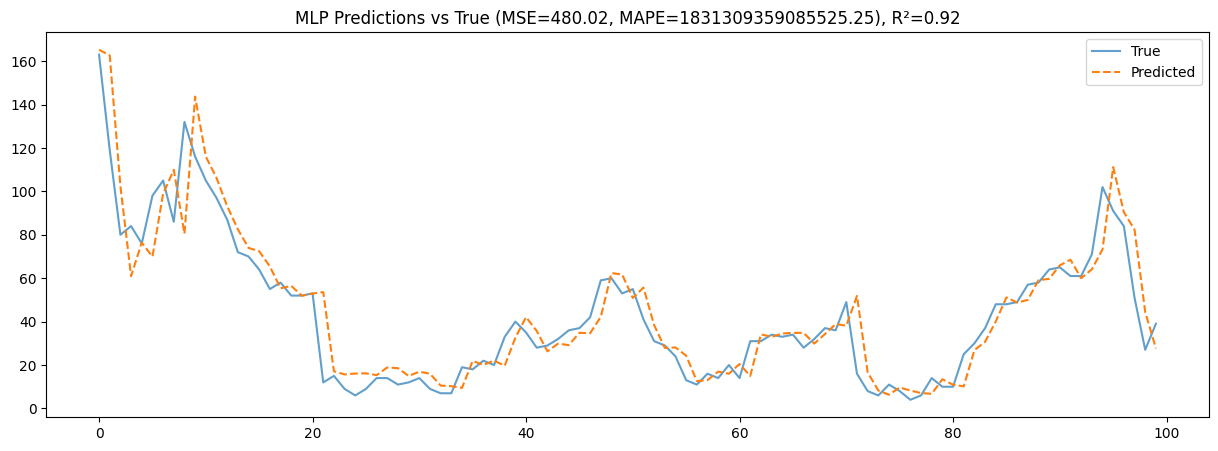

In [59]:
mlp_shallow_metrics = evaluate_model(
    model=results_mlp['models']['shallow'], 
    X_test=X_test_mlp, 
    y_test=y_test,
    model_type='mlp', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


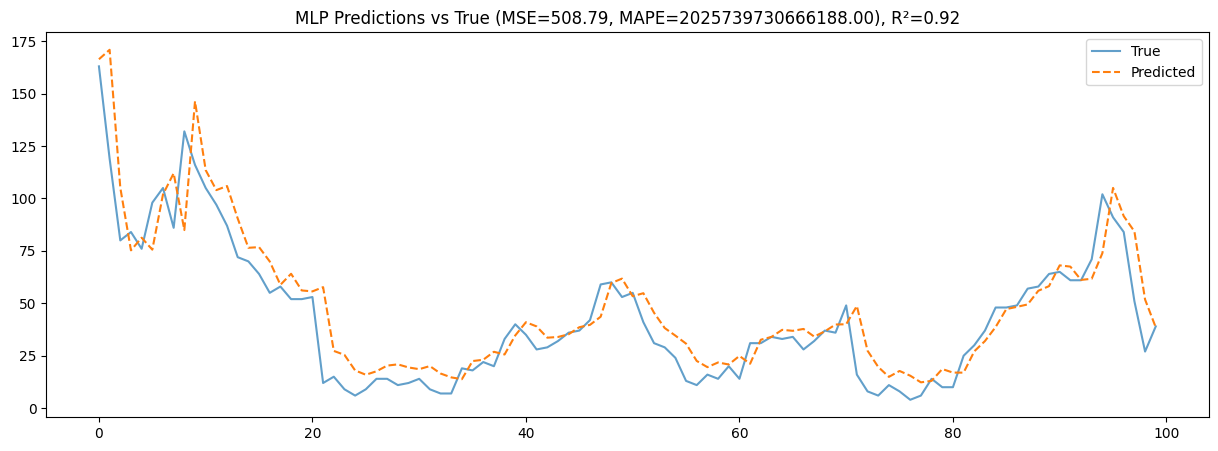

In [60]:
mlp_deep_metrics = evaluate_model(
    model=results_mlp['models']['deep'], 
    X_test=X_test_mlp, 
    y_test=y_test,
    model_type='mlp', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


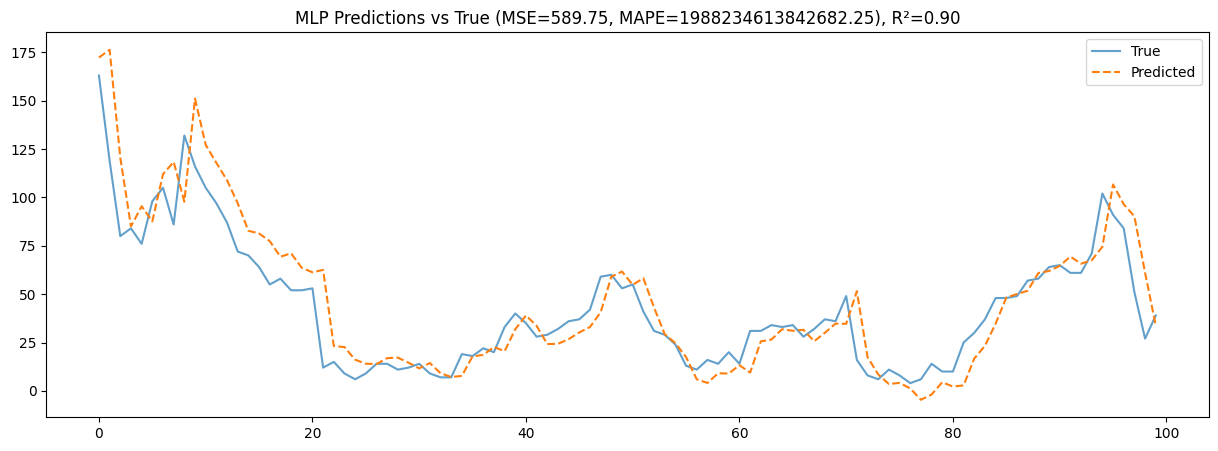

In [61]:
mlp_wide_metrics = evaluate_model(
    model=results_mlp['models']['wide'], 
    X_test=X_test_mlp, 
    y_test=y_test,
    model_type='mlp', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

In [62]:
log_to_dagshub(
    model=results_mlp['models']['shallow'],
    architecture="shallow",
    model_type="mlp",
    X_test=X_test_mlp,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


Successfully registered model 'aqi_mlp_shallow'.
2025/05/13 13:33:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_mlp_shallow, version 1
Created version '1' of model 'aqi_mlp_shallow'.



✅ Successfully logged mlp to DagsHub:
        - Run ID: 783c71669d6d4c1099aecab6e84e1d4a
        - Metrics: {'MSE': 480.01941902762513, 'MAPE': 1831309359085525.2, 'R2': 0.9225463951404652}
        - Model URI: runs:/783c71669d6d4c1099aecab6e84e1d4a/mlp_model
        
🏃 View run mlp-shallow at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/783c71669d6d4c1099aecab6e84e1d4a
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


In [63]:
log_to_dagshub(
    model=results_mlp['models']['deep'],
    architecture="deep",
    model_type="mlp",
    X_test=X_test_mlp,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


Successfully registered model 'aqi_mlp_deep'.
2025/05/13 13:33:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_mlp_deep, version 1
Created version '1' of model 'aqi_mlp_deep'.



✅ Successfully logged mlp to DagsHub:
        - Run ID: 78a77457898543b19a273dee9ade27c9
        - Metrics: {'MSE': 508.7896114089148, 'MAPE': 2025739730666188.0, 'R2': 0.917904176463256}
        - Model URI: runs:/78a77457898543b19a273dee9ade27c9/mlp_model
        
🏃 View run mlp-deep at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/78a77457898543b19a273dee9ade27c9
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


In [64]:
log_to_dagshub(
    model=results_mlp['models']['wide'],
    architecture="wide",
    model_type="mlp",
    X_test=X_test_mlp,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


Successfully registered model 'aqi_mlp_wide'.
2025/05/13 13:34:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_mlp_wide, version 1
Created version '1' of model 'aqi_mlp_wide'.



✅ Successfully logged mlp to DagsHub:
        - Run ID: 2b9a8defdc244834aeb0cf932f556251
        - Metrics: {'MSE': 589.7531930523986, 'MAPE': 1988234613842682.2, 'R2': 0.9048402856870659}
        - Model URI: runs:/2b9a8defdc244834aeb0cf932f556251/mlp_model
        
🏃 View run mlp-wide at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/2b9a8defdc244834aeb0cf932f556251
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


#### CNN

In [65]:
X_train_cnn = univariate_data['X_train_cnn']
X_val_cnn = univariate_data['X_val_cnn']
X_test_cnn = univariate_data['X_test_cnn']
X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape

((30643, 24, 1), (6566, 24, 1), (6567, 24, 1))

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_train_cnns(X_train, y_train, X_val, y_val, n_future=1, epochs=50, batch_size=32):
    """
    Builds, trains, and evaluates 3 CNN architectures for time series forecasting.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data.
        n_future (int): Forecast horizon.
        epochs (int): Training epochs.
        batch_size (int): Batch size.
    
    Returns:
        Dict: Trained models and their histories.
    """
    input_shape = X_train.shape[1:]  # (n_past, 1)
    
    # --- Architecture 1: Simple 1D CNN ---
    model_simple = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(n_future)
    ], name='simple_cnn')
    model_simple.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 2: Deep CNN with Dropout ---
    model_deep = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(n_future)
    ], name='deep_cnn')
    model_deep.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 3: Hybrid CNN with BatchNorm ---
    model_hybrid = Sequential([
        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(n_future)
    ], name='hybrid_cnn')
    model_hybrid.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Train all models
    print("Training Simple CNN...")
    history_simple = model_simple.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Deep CNN...")
    history_deep = model_deep.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Hybrid CNN...")
    history_hybrid = model_hybrid.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    return {
        'models': {
            'simple': model_simple,
            'deep': model_deep,
            'hybrid': model_hybrid
        },
        'histories': {
            'simple': history_simple,
            'deep': history_deep,
            'hybrid': history_hybrid
        }
    }

In [71]:
results_cnn = build_train_cnns(
    X_train_cnn, 
    y_train, 
    X_val_cnn,
    y_val,
    n_future=n_future,
    epochs=30,
    batch_size=32
)

/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Simple CNN...
Training Deep CNN...
Training Hybrid CNN...


206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


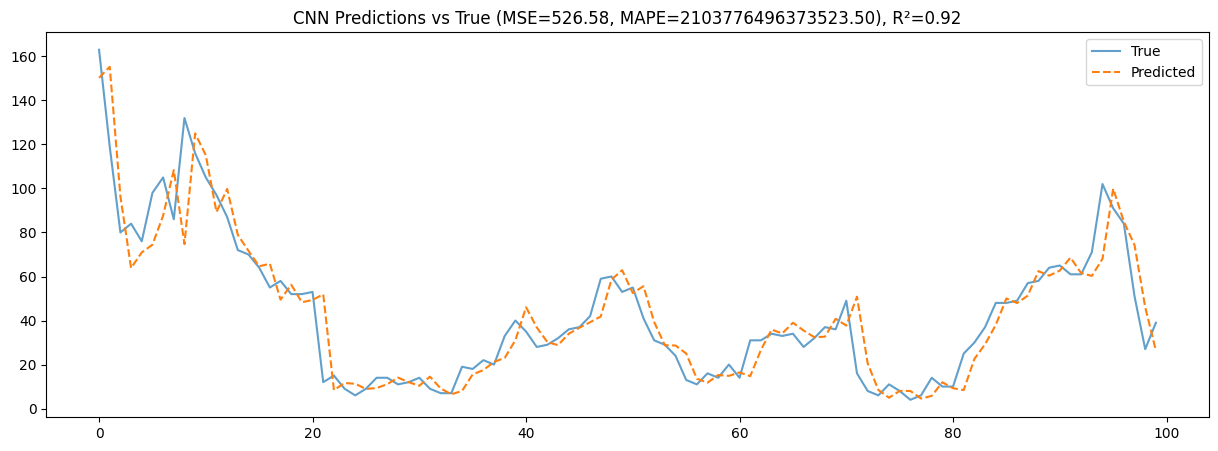

{'MSE': 526.5809660332036,
 'MAPE': 2103776496373523.5,
 'R²': 0.9150334497877041}

In [72]:
evaluate_model(
    model=results_cnn['models']['simple'], 
    X_test=X_test_cnn, 
    y_test=y_test,
    model_type='cnn', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


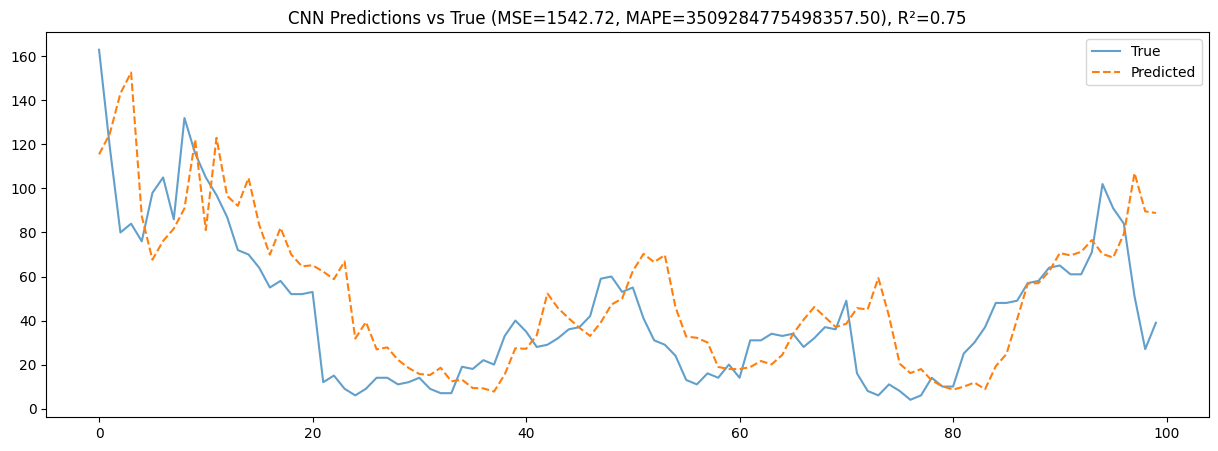

{'MSE': 1542.7246839406757,
 'MAPE': 3509284775498357.5,
 'R²': 0.7510734288228554}

In [73]:
evaluate_model(
    model=results_cnn['models']['deep'], 
    X_test=X_test_cnn, 
    y_test=y_test,
    model_type='cnn', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


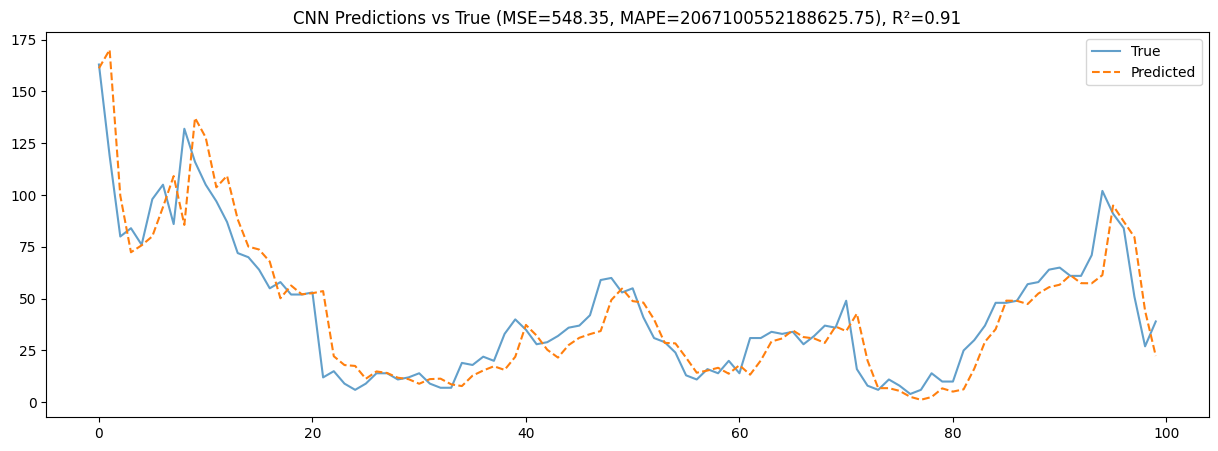

{'MSE': 548.3520352727924,
 'MAPE': 2067100552188625.8,
 'R²': 0.9115205756675935}

In [74]:
evaluate_model(
    model=results_cnn['models']['hybrid'], 
    X_test=X_test_cnn, 
    y_test=y_test,
    model_type='cnn', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

In [79]:
log_to_dagshub(
    model=results_cnn['models']['simple'],
    architecture="simple",
    model_type="cnn",
    X_test=X_test_cnn,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step


Registered model 'aqi_cnn_simple' already exists. Creating a new version of this model...
2025/05/13 17:04:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_cnn_simple, version 4
Created version '4' of model 'aqi_cnn_simple'.



✅ Successfully logged cnn to DagsHub:
        - Run ID: eeb7a92fcd7f4a829f1762e590f86715
        - Metrics: {'MSE': 526.5809660332036, 'MAPE': 2103776496373523.5, 'R2': 0.9150334497877041}
        - Model URI: runs:/eeb7a92fcd7f4a829f1762e590f86715/cnn_model
        
🏃 View run cnn-simple at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/eeb7a92fcd7f4a829f1762e590f86715
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


In [80]:
log_to_dagshub(
    model=results_cnn['models']['deep'],
    architecture="deep",
    model_type="cnn",
    X_test=X_test_cnn,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step


Successfully registered model 'aqi_cnn_deep'.
2025/05/13 17:05:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_cnn_deep, version 1
Created version '1' of model 'aqi_cnn_deep'.



✅ Successfully logged cnn to DagsHub:
        - Run ID: 0d9f438dcda14669aa1e9e2b01df33e4
        - Metrics: {'MSE': 1542.7246839406757, 'MAPE': 3509284775498357.5, 'R2': 0.7510734288228554}
        - Model URI: runs:/0d9f438dcda14669aa1e9e2b01df33e4/cnn_model
        
🏃 View run cnn-deep at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/0d9f438dcda14669aa1e9e2b01df33e4
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


In [81]:
log_to_dagshub(
    model=results_cnn['models']['hybrid'],
    architecture="hybrid",
    model_type="cnn",
    X_test=X_test_cnn,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


Successfully registered model 'aqi_cnn_hybrid'.
2025/05/13 17:05:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_cnn_hybrid, version 1
Created version '1' of model 'aqi_cnn_hybrid'.



✅ Successfully logged cnn to DagsHub:
        - Run ID: e0488964434c4a94a7ca9d47d96a1aab
        - Metrics: {'MSE': 548.3520352727924, 'MAPE': 2067100552188625.8, 'R2': 0.9115205756675935}
        - Model URI: runs:/e0488964434c4a94a7ca9d47d96a1aab/cnn_model
        
🏃 View run cnn-hybrid at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/e0488964434c4a94a7ca9d47d96a1aab
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


#### LSTM

In [82]:
X_train_lstm = univariate_data['X_train_lstm']
X_val_lstm = univariate_data['X_val_lstm']
X_test_lstm = univariate_data['X_test_lstm']
X_train_lstm.shape, X_val_lstm.shape, X_test_lstm.shape

((30643, 24, 1), (6566, 24, 1), (6567, 24, 1))

In [83]:
from tensorflow.keras.layers import LSTM, Bidirectional

def build_train_lstms(X_train, y_train, X_val, y_val, n_future=1, epochs=50, batch_size=32):
    """
    Builds, trains, and evaluates 3 LSTM architectures for time series forecasting.
    
    Args:
        X_train, y_train: Training data (shape: (samples, timesteps, features)).
        X_val, y_val: Validation data.
        n_future (int): Forecast horizon.
        epochs (int): Training epochs.
        batch_size (int): Batch size.
    
    Returns:
        Dict: Trained models and their histories.
    """
    input_shape = X_train.shape[1:]  # (timesteps, features)
    
    # --- Architecture 1: Vanilla LSTM ---
    model_vanilla = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        LSTM(64, activation='tanh'),
        Dense(n_future)
    ], name='vanilla_lstm')
    model_vanilla.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 2: Stacked LSTM with Dropout ---
    model_stacked = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64, activation='tanh'),
        Dropout(0.2),
        Dense(n_future)
    ], name='stacked_lstm')
    model_stacked.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 3: Bidirectional LSTM with BatchNorm ---
    model_bidirectional = Sequential([
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Bidirectional(LSTM(32, activation='tanh')),
        Dense(n_future)
    ], name='bidirectional_lstm')
    model_bidirectional.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Train all models
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    
    print("Training Vanilla LSTM...")
    history_vanilla = model_vanilla.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Stacked LSTM...")
    history_stacked = model_stacked.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Bidirectional LSTM...")
    history_bidirectional = model_bidirectional.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    return {
        'models': {
            'vanilla': model_vanilla,
            'stacked': model_stacked,
            'bidirectional': model_bidirectional
        },
        'histories': {
            'vanilla': history_vanilla,
            'stacked': history_stacked,
            'bidirectional': history_bidirectional
        }
    }

In [84]:
results_lstm = build_train_lstms(
    X_train_lstm, 
    y_train, 
    X_val_lstm,
    y_val,
    n_future=n_future,
    epochs=30,
    batch_size=32
)

/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Vanilla LSTM...
Training Stacked LSTM...
Training Bidirectional LSTM...


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


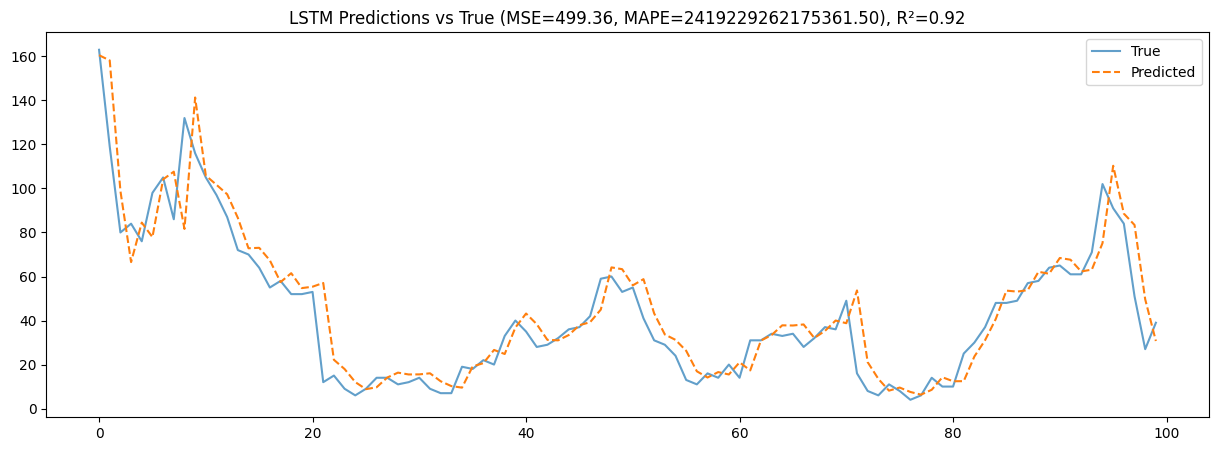

{'MSE': 499.36098154468806,
 'MAPE': 2419229262175361.5,
 'R²': 0.9194255344394602}

In [85]:
evaluate_model(
    model=results_lstm['models']['vanilla'], 
    X_test=X_test_lstm, 
    y_test=y_test,
    model_type='lstm', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


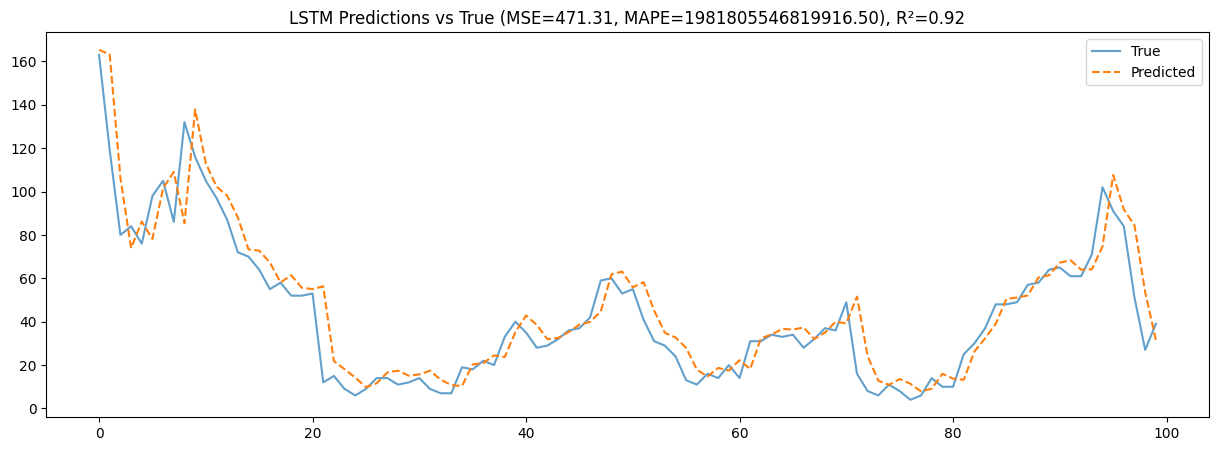

{'MSE': 471.3103779332967,
 'MAPE': 1981805546819916.5,
 'R²': 0.9239516437635147}

In [86]:
evaluate_model(
    model=results_lstm['models']['stacked'], 
    X_test=X_test_lstm, 
    y_test=y_test,
    model_type='lstm', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


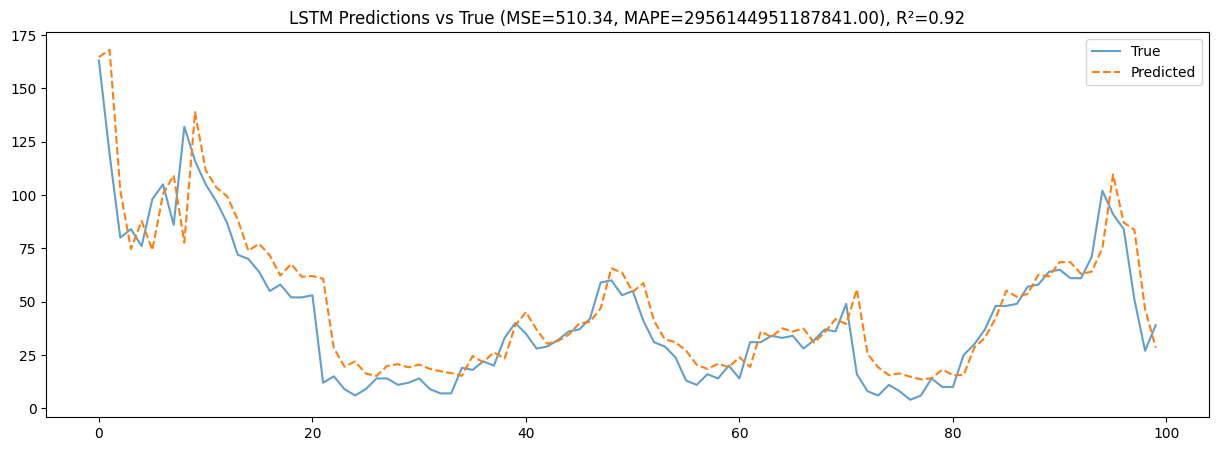

{'MSE': 510.3359372278583, 'MAPE': 2956144951187841.0, 'R²': 0.917654668830404}

In [87]:
evaluate_model(
    model=results_lstm['models']['bidirectional'], 
    X_test=X_test_lstm, 
    y_test=y_test,
    model_type='lstm', 
    scaler=univariate_data['scaler'],
    n_future=n_future
)

In [88]:
log_to_dagshub(
    model=results_lstm['models']['vanilla'],
    architecture="vanilla",
    model_type="lstm",
    X_test=X_test_lstm,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Successfully registered model 'aqi_lstm_vanilla'.
2025/05/13 17:43:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_lstm_vanilla, version 1
Created version '1' of model 'aqi_lstm_vanilla'.



✅ Successfully logged lstm to DagsHub:
        - Run ID: e2a325cad9a54489ba49eb5af01a4efb
        - Metrics: {'MSE': 499.36098154468806, 'MAPE': 2419229262175361.5, 'R2': 0.9194255344394602}
        - Model URI: runs:/e2a325cad9a54489ba49eb5af01a4efb/lstm_model
        
🏃 View run lstm-vanilla at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/e2a325cad9a54489ba49eb5af01a4efb
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


In [89]:
log_to_dagshub(
    model=results_lstm['models']['stacked'],
    architecture="stacked",
    model_type="lstm",
    X_test=X_test_lstm,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Successfully registered model 'aqi_lstm_stacked'.
2025/05/13 17:43:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_lstm_stacked, version 1
Created version '1' of model 'aqi_lstm_stacked'.



✅ Successfully logged lstm to DagsHub:
        - Run ID: 89c31e98481c451ab3126f1140a2bbd6
        - Metrics: {'MSE': 471.3103779332967, 'MAPE': 1981805546819916.5, 'R2': 0.9239516437635147}
        - Model URI: runs:/89c31e98481c451ab3126f1140a2bbd6/lstm_model
        
🏃 View run lstm-stacked at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/89c31e98481c451ab3126f1140a2bbd6
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


In [90]:
log_to_dagshub(
    model=results_lstm['models']['bidirectional'],
    architecture="bidirectional",
    model_type="lstm",
    X_test=X_test_lstm,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Successfully registered model 'aqi_lstm_bidirectional'.
2025/05/13 17:43:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_lstm_bidirectional, version 1
Created version '1' of model 'aqi_lstm_bidirectional'.



✅ Successfully logged lstm to DagsHub:
        - Run ID: c5b6e9127622420dbd97462e9daf8ee7
        - Metrics: {'MSE': 510.3359372278583, 'MAPE': 2956144951187841.0, 'R2': 0.917654668830404}
        - Model URI: runs:/c5b6e9127622420dbd97462e9daf8ee7/lstm_model
        
🏃 View run lstm-bidirectional at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/c5b6e9127622420dbd97462e9daf8ee7
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


#### ConvLSTM

In [103]:
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization, TimeDistributed, Conv2D

def build_train_convlstms(X_train, y_train, X_val, y_val, n_future=1, epochs=50, batch_size=32):
    """
    Builds, trains, and evaluates 3 ConvLSTM architectures for time series forecasting.
    
    Args:
        X_train: Training data (shape: samples, timesteps, height, width, channels).
        y_train: Training targets.
        X_val: Validation data.
        y_val: Validation targets.
        n_future: Forecast horizon.
        epochs: Training epochs.
        batch_size: Batch size.
    
    Returns:
        Dict containing models and training histories.
    """
    # Reshape input for ConvLSTM (samples, timesteps, 1, n_past, 1)
    # Assuming input is (samples, timesteps, n_past)
    X_train_reshaped = X_train.reshape(X_train.shape[0], 1, 1, X_train.shape[1], 1)
    X_val_reshaped = X_val.reshape(X_val.shape[0], 1, 1, X_val.shape[1], 1)
    
    input_shape = (1, 1, X_train.shape[1], 1)  # (timesteps, height, width, channels)
    
    # --- Architecture 1: Basic ConvLSTM ---
    model_basic = Sequential([
        ConvLSTM2D(filters=64, kernel_size=(1,3), activation='tanh',
                  input_shape=input_shape, padding='same', return_sequences=False),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(n_future)
    ], name='basic_convlstm')
    model_basic.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 2: Stacked ConvLSTM with Dropout ---
    model_stacked = Sequential([
        ConvLSTM2D(filters=64, kernel_size=(1,3), activation='tanh',
                  input_shape=input_shape, padding='same', return_sequences=True),
        Dropout(0.3),
        ConvLSTM2D(filters=32, kernel_size=(1,3), activation='tanh',
                  padding='same', return_sequences=False),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(n_future)
    ], name='stacked_convlstm')
    model_stacked.compile(optimizer=Adam(), loss='mse')
    
    # --- Architecture 3: Hybrid ConvLSTM-CNN ---
    model_hybrid = Sequential([
        ConvLSTM2D(filters=64, kernel_size=(1, 5), activation='tanh',
                input_shape=input_shape,  # 5D input
                padding='same', return_sequences=True),
        BatchNormalization(),
        TimeDistributed(Conv2D(filters=32, kernel_size=(1, 3), activation='relu')),  # use Conv2D
        TimeDistributed(Flatten()),
        Dense(100, activation='relu'),
        Dense(n_future)
    ])

    model_hybrid.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Train all models
    print("Training Basic ConvLSTM...")
    history_basic = model_basic.fit(
        X_train_reshaped, y_train,
        validation_data=(X_val_reshaped, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Stacked ConvLSTM...")
    history_stacked = model_stacked.fit(
        X_train_reshaped, y_train,
        validation_data=(X_val_reshaped, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    print("Training Hybrid ConvLSTM...")
    history_hybrid = model_hybrid.fit(
        X_train_reshaped, y_train,
        validation_data=(X_val_reshaped, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    
    return {
        'models': {
            'basic': model_basic,
            'stacked': model_stacked,
            'hybrid': model_hybrid
        },
        'histories': {
            'basic': history_basic,
            'stacked': history_stacked,
            'hybrid': history_hybrid
        }
    }

In [105]:
results_convlstm = build_train_convlstms(
    X_train_lstm, 
    y_train, 
    X_val_lstm,
    y_val,
    n_future=n_future,
    epochs=30,
    batch_size=32
)

Training Basic ConvLSTM...
Training Stacked ConvLSTM...
Training Hybrid ConvLSTM...


In [111]:
X_test_convlstm = X_test_lstm.reshape(X_test_lstm.shape[0], 1, 1, X_test_lstm.shape[1], 1)
X_test_convlstm.shape

(6567, 1, 1, 24, 1)

In [116]:
def evaluate_convlstm_models(
    models_dict,  # Dictionary of trained ConvLSTM models {'name': model}
    X_test,       # Test features (shape: samples, timesteps, height, width, channels)
    y_test,       # Test targets
    scaler=None,  # Optional scaler for inverse transformation
    n_future=1,   # Forecast horizon
    plot_samples=24,  # Number of samples to visualize
    log_to_mlflow=False,
    experiment_name="ConvLSTM_Evaluation"
):
    """
    Evaluates multiple ConvLSTM models and logs results.
    
    Returns:
        Dictionary of metrics for each model {'model_name': {'MSE': float, ...}}
    """
    # Ensure input is properly reshaped
    if len(X_test.shape) == 4:
        X_test = X_test.reshape(X_test.shape[0], 1, 1, X_test.shape[1], 1)
    
    metrics_dict = {}
    
    if log_to_mlflow:
        mlflow.set_experiment(experiment_name)
    
    for model_name, model in models_dict.items():
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Inverse transform if scaler provided
        if scaler:
            y_test_actual = scaler.inverse_transform(y_test.reshape(-1, n_future))
            y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, n_future))
        else:
            y_test_actual = y_test
            y_pred_actual = y_pred
        
        # Calculate metrics
        metrics = {
            'MSE': mean_squared_error(y_test_actual, y_pred_actual),
            'MAPE': mean_absolute_percentage_error(y_test_actual, y_pred_actual),
            'R2': r2_score(y_test_actual, y_pred_actual),
            'RMSE': np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
        }
        metrics_dict[model_name] = metrics
        
        # Plot predictions vs actual
        plt.figure(figsize=(15, 5))
        plt.plot(y_test_actual[:plot_samples].flatten(), label='Actual', marker='o')
        plt.plot(y_pred_actual[:plot_samples].flatten(), label='Predicted', linestyle='--', marker='x')
        plt.title(f"{model_name} Predictions (First {plot_samples} Samples)\n"
                 f"MSE: {metrics['MSE']:.2f}, MAPE: {metrics['MAPE']:.2f}, R²: {metrics['R2']:.2f}")
        plt.xlabel("Time Steps")
        plt.ylabel("AQI Value")
        plt.legend()
        plt.grid(True)
        
        # Log to MLflow if enabled
        if log_to_mlflow:
            with mlflow.start_run(run_name=model_name):
                # Log metrics
                mlflow.log_metrics(metrics)
                
                # Log model with signature
                signature = infer_signature(X_test, y_pred)
                mlflow.keras.log_model(
                    model,
                    artifact_path=f"convlstm_{model_name}",
                    signature=signature
                )
                
                # Save and log plot
                plot_path = f"{model_name}_predictions.png"
                plt.savefig(plot_path, bbox_inches='tight', dpi=300)
                mlflow.log_artifact(plot_path)
        
        plt.show()
        
        # Print metrics
        print(f"\n{model_name} Evaluation:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print("-" * 50)
    
    return metrics_dict

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


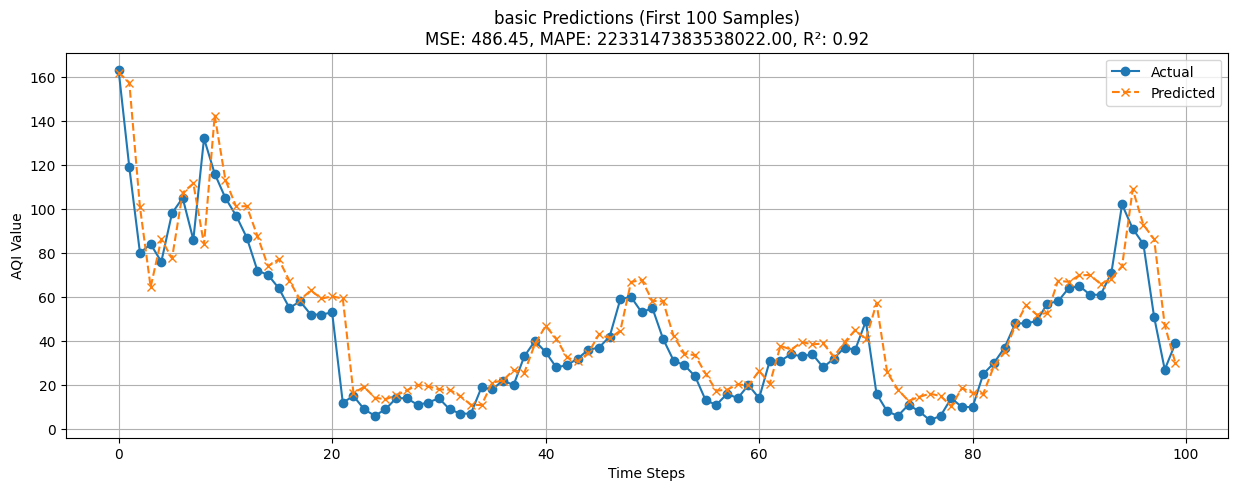


basic Evaluation:
MSE: 486.4548
MAPE: 2233147383538022.0000
R2: 0.9215
RMSE: 22.0557
--------------------------------------------------
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


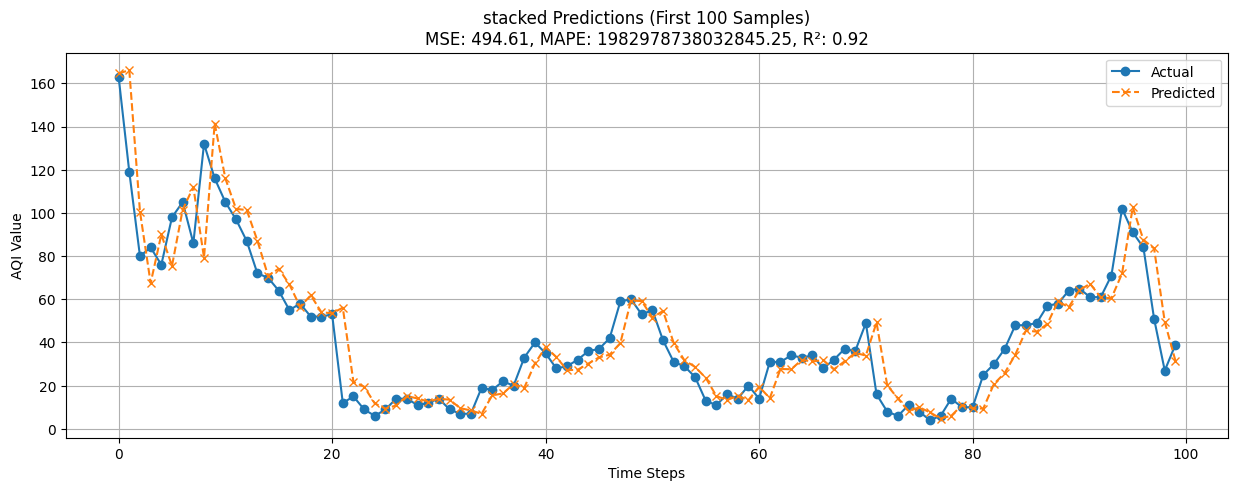


stacked Evaluation:
MSE: 494.6062
MAPE: 1982978738032845.2500
R2: 0.9202
RMSE: 22.2397
--------------------------------------------------
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


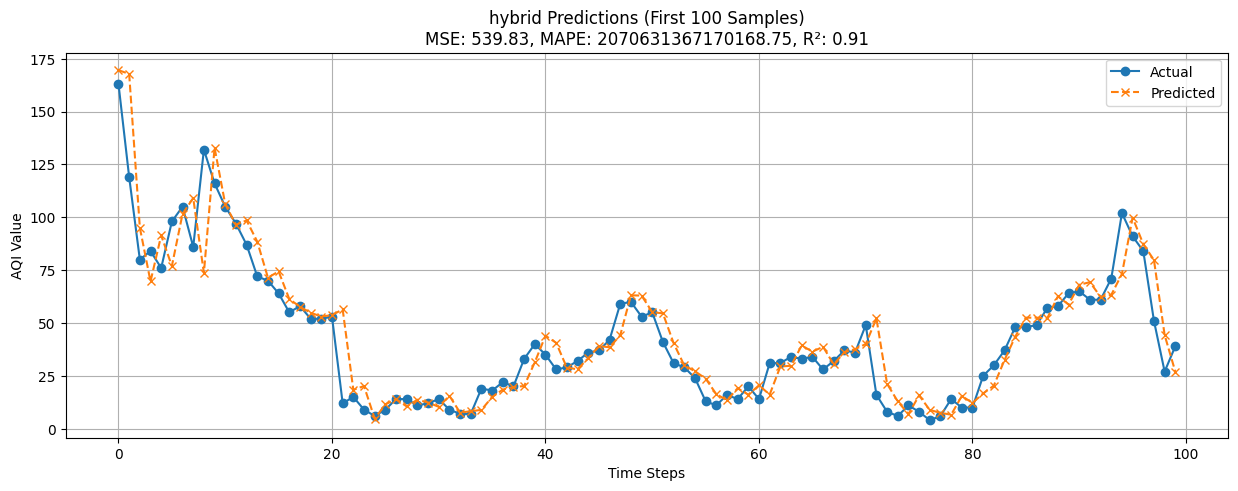


hybrid Evaluation:
MSE: 539.8341
MAPE: 2070631367170168.7500
R2: 0.9129
RMSE: 23.2343
--------------------------------------------------


{'basic': {'MSE': 486.4547707564046,
  'MAPE': 2233147383538022.0,
  'R2': 0.9215080180036763,
  'RMSE': np.float64(22.05571968348357)},
 'stacked': {'MSE': 494.6062150067284,
  'MAPE': 1982978738032845.2,
  'R2': 0.9201927405024493,
  'RMSE': np.float64(22.239744040944544)},
 'hybrid': {'MSE': 539.8341140709196,
  'MAPE': 2070631367170168.8,
  'R2': 0.912894986111927,
  'RMSE': np.float64(23.23433050619104)}}

In [117]:
evaluate_convlstm_models(
    models_dict=results_convlstm['models'],
    X_test=X_test_convlstm,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    n_future=n_future,
    plot_samples=100,
    log_to_mlflow=False,
    experiment_name="ConvLSTM_Evaluation"
)

In [118]:
log_to_dagshub(
    model=results_convlstm['models']['basic'],
    architecture="basic",
    model_type="convlstm",
    X_test=X_test_convlstm,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)
log_to_dagshub(
    model=results_convlstm['models']['stacked'],
    architecture="stacked",
    model_type="convlstm",
    X_test=X_test_convlstm,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)
log_to_dagshub(
    model=results_convlstm['models']['hybrid'],
    architecture="hybrid",
    model_type="convlstm",
    X_test=X_test_convlstm,
    y_test=y_test,
    scaler=univariate_data['scaler'],
    preprocessing_info=univariate_data,
    n_future=n_future
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Successfully registered model 'aqi_convlstm_basic'.
2025/05/13 21:00:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_convlstm_basic, version 1
Created version '1' of model 'aqi_convlstm_basic'.



✅ Successfully logged convlstm to DagsHub:
        - Run ID: 43512206c0b54dcba0d0ae7468c88f53
        - Metrics: {'MSE': 486.4547707564046, 'MAPE': 2233147383538022.0, 'R2': 0.9215080180036763}
        - Model URI: runs:/43512206c0b54dcba0d0ae7468c88f53/convlstm_model
        
🏃 View run convlstm-basic at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/43512206c0b54dcba0d0ae7468c88f53
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Successfully registered model 'aqi_convlstm_stacked'.
2025/05/13 21:00:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_convlstm_stacked, version 1
Created version '1' of model 'aqi_convlstm_stacked'.



✅ Successfully logged convlstm to DagsHub:
        - Run ID: 40038c41faa14072b494bd4f611b8b6e
        - Metrics: {'MSE': 494.6062150067284, 'MAPE': 1982978738032845.2, 'R2': 0.9201927405024493}
        - Model URI: runs:/40038c41faa14072b494bd4f611b8b6e/convlstm_model
        
🏃 View run convlstm-stacked at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/40038c41faa14072b494bd4f611b8b6e
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Successfully registered model 'aqi_convlstm_hybrid'.
2025/05/13 21:01:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aqi_convlstm_hybrid, version 1
Created version '1' of model 'aqi_convlstm_hybrid'.



✅ Successfully logged convlstm to DagsHub:
        - Run ID: 867eb0e36c39490e81278d32121db21e
        - Metrics: {'MSE': 539.8341140709196, 'MAPE': 2070631367170168.8, 'R2': 0.912894986111927}
        - Model URI: runs:/867eb0e36c39490e81278d32121db21e/convlstm_model
        
🏃 View run convlstm-hybrid at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/867eb0e36c39490e81278d32121db21e
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


### Redes Neuronales (multivariado)

#### Pre-Procesamiento

In [5]:
df.head()

date  pollution  dew  temp   press wnd_dir  wnd_spd  snow  \
0  2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0   
1  2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0   
2  2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0   
3  2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1   
4  2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2   

   rain  
0     0  
1     0  
2     0  
3     0  
4     0

In [6]:
df['wnd_dir'] = df['wnd_dir'].replace('cv', 'SW') # Error en la toma de datos
df['wnd_dir'].value_counts()

wnd_dir
SE    15290
NW    14130
SW     9384
NE     4996
Name: count, dtype: int64

In [7]:
# Codificar la variable 'wnd_dir' con LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Crear un objeto LabelEncoder
label_encoder = LabelEncoder()
# Ajustar y transformar la columna 'wnd_dir'
df['wnd_dir'] = label_encoder.fit_transform(df['wnd_dir'])
# Verificar la codificación
df.head()

date  pollution  dew  temp   press  wnd_dir  wnd_spd  snow  \
0  2010-01-02 00:00:00      129.0  -16  -4.0  1020.0        2     1.79     0   
1  2010-01-02 01:00:00      148.0  -15  -4.0  1020.0        2     2.68     0   
2  2010-01-02 02:00:00      159.0  -11  -5.0  1021.0        2     3.57     0   
3  2010-01-02 03:00:00      181.0   -7  -5.0  1022.0        2     5.36     1   
4  2010-01-02 04:00:00      138.0   -7  -5.0  1022.0        2     6.25     2   

   rain  
0     0  
1     0  
2     0  
3     0  
4     0

In [8]:
# Convertir la columna 'date' a tipo datetime
multi_df = df.copy()
multi_df['date'] = pd.to_datetime(df['date'])
multi_df.set_index('date', inplace=True)
multi_df.head()

pollution  dew  temp   press  wnd_dir  wnd_spd  snow  \
date                                                                        
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0        2     1.79     0   
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0        2     2.68     0   
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0        2     3.57     0   
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0        2     5.36     1   
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0        2     6.25     2   

                     rain  
date                       
2010-01-02 00:00:00     0  
2010-01-02 01:00:00     0  
2010-01-02 02:00:00     0  
2010-01-02 03:00:00     0  
2010-01-02 04:00:00     0

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

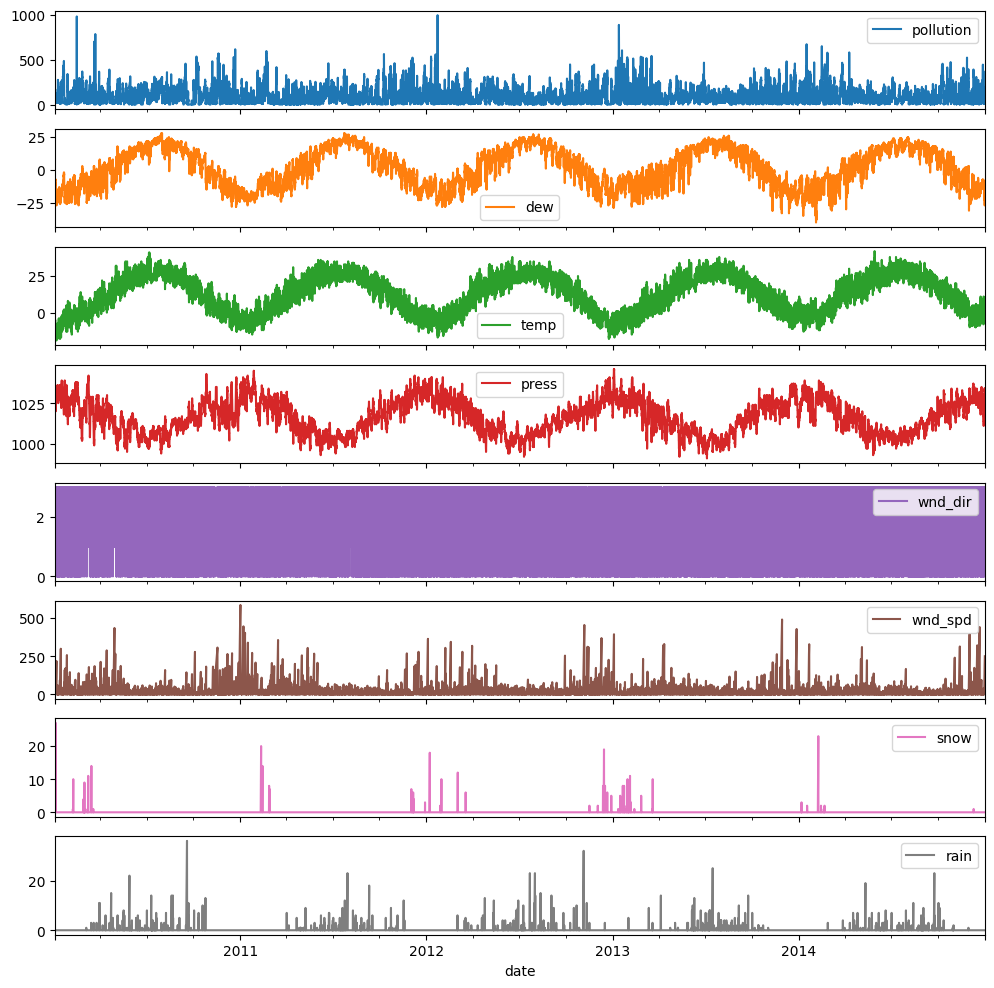

In [9]:
multi_df.plot(subplots=True, figsize=(12, 12))

In [10]:
order_columns = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'wnd_dir', 'pollution']
multi_df = multi_df[order_columns]

Vamos a aplicar la escala de RobustScaler

Con estas variables transformadas entrenaremos los modelos.

In [11]:
n = len(multi_df)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

# Create the splits
train_df = multi_df[:train_size]
val_df = multi_df[train_size:train_size + val_size]
test_df = multi_df[train_size + val_size:]

# Verify the splits
print("Original dataset size:", len(multi_df))
print("Train set size:", len(train_df), f"({len(train_df)/n:.1%})")
print("Validation set size:", len(val_df), f"({len(val_df)/n:.1%})")
print("Test set size:", len(test_df), f"({len(test_df)/n:.1%})")

Original dataset size: 43800
Train set size: 30659 (70.0%)
Validation set size: 6570 (15.0%)
Test set size: 6571 (15.0%)


In [12]:
from sklearn.preprocessing import RobustScaler

# Initialize the scaler
scaler = RobustScaler()
# Fit the scaler on the training data
scaler.fit(train_df)
# Transform the data
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)
# Convert back to DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns, index=train_df.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val_df.columns, index=val_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns, index=test_df.index)

In [13]:
train_scaled.shape, val_scaled.shape, test_scaled.shape

((30659, 8), (6570, 8), (6571, 8))

Ya están nuestros datos listos para crear las secuencias, vamos a elegir 24 steps in y 1 out

In [14]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence_m_step(sequence: np.ndarray, n_steps_in: int, n_steps_out: int=1):
    """
    Divide una secuencia multivariada en muestras
    :param sequence: Array de numpy con la secuencia
    :param n_steps_in: Número de pasos de entrada
    :param n_steps_out: Número de pasos de salida
    :return: Devuelve dos arrays de numpy con las muestras de entrada y salida
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [15]:
n_steps_in, n_steps_out = 24, 1

X_train_multi, y_train_multi = split_multivariate_sequence_m_step(train_scaled_df.values, n_steps_in, n_steps_out)
X_val_multi, y_val_multi = split_multivariate_sequence_m_step(val_scaled_df.values, n_steps_in, n_steps_out)
X_test_multi, y_test_multi = split_multivariate_sequence_m_step(test_scaled_df.values, n_steps_in, n_steps_out)

# Imprimir dimensiones de los datos de entrenamiento, validación y test
print('Datos de entrenamiento', X_train_multi.shape, y_train_multi.shape)
print('Datos de validación', X_val_multi.shape, y_val_multi.shape)
print('Datos de test', X_test_multi.shape, y_test_multi.shape)

Datos de entrenamiento (30636, 24, 7) (30636, 1)
Datos de validación (6547, 24, 7) (6547, 1)
Datos de test (6548, 24, 7) (6548, 1)


In [16]:
def log_multivariate_to_dagshub(
    model,
    architecture,
    model_type,
    X_test,
    y_test,
    scaler,
    preprocessing_info,
    n_steps_in=24,
    n_steps_out=1,
    n_features=7,
    experiment_name="proyecto-modelos-regresion",
    plot_sample_size=100
):
    """
    Enhanced MLflow logging for multivariate models.
    
    Args:
        model: Trained Keras model
        architecture: Model architecture name
        model_type: Model type identifier ('mlp', 'lstm', etc.)
        X_test: Test features (properly shaped for the model)
        y_test: Test targets
        scaler: Fitted RobustScaler object
        preprocessing_info: Dict with preprocessing details
        n_steps_in: Lookback window size
        n_steps_out: Prediction horizon length
        n_features: Number of input features
        experiment_name: MLflow experiment name
        plot_sample_size: Number of samples to plot
    """
    
    with mlflow.start_run(run_name=f"{model_type}-{architecture}"):
        # ===== 1. Log Core Parameters =====
        mlflow.log_params({
            "model_type": model_type,
            "architecture": architecture,
            "n_steps_in": n_steps_in,
            "n_steps_out": n_steps_out,
            "n_features": n_features,
            "scaler": str(scaler.__class__.__name__),
            "train_samples": preprocessing_info.get('train_samples', 'N/A'),
            "test_samples": len(X_test)
        })
        
        # ===== 2. Model Evaluation =====
        # Get predictions
        if model_type == 'mlp':
            X_test_flat = X_test.reshape(X_test.shape[0], n_steps_in * n_features)
            y_pred = model.predict(X_test_flat)
        else:
            y_pred = model.predict(X_test)
        
        # Reshape and inverse scaling
        y_test_flat = y_test.reshape(-1, 1)
        y_pred_flat = y_pred.reshape(-1, 1)
        
        dummy_test = np.zeros((len(y_test_flat), n_features + 1))
        dummy_pred = np.zeros((len(y_pred_flat), n_features + 1))
        
        dummy_test[:, -1] = y_test_flat.flatten()
        dummy_pred[:, -1] = y_pred_flat.flatten()
        
        y_test_inv = scaler.inverse_transform(dummy_test)[:, -1]
        y_pred_inv = scaler.inverse_transform(dummy_pred)[:, -1]
        
        # Calculate metrics
        metrics = {
            'MSE': mean_squared_error(y_test_inv, y_pred_inv),
            'RMSE': np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)),
            'MAPE': mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100,
            'R2': r2_score(y_test_inv, y_pred_inv)
        }
        mlflow.log_metrics(metrics)
        
        # ===== 3. Model Logging =====
        signature = infer_signature(X_test, y_pred)
        mlflow.keras.log_model(
            model=model,
            artifact_path=f"{model_type}_model",
            signature=signature,
            registered_model_name=f"pollution_{model_type}_{architecture}"
        )
        
        # ===== 4. Visualizations =====
        # Time-series plot
        plt.figure(figsize=(12, 6))
        sample_indices = np.random.choice(len(y_test_inv), size=min(plot_sample_size, len(y_test_inv)), replace=False)
        plt.plot(y_test_inv[sample_indices], label='Actual', color='blue', alpha=0.7, marker='o')
        plt.plot(y_pred_inv[sample_indices], label='Predicted', color='red', alpha=0.7, marker='x')
        plt.title(f'{architecture} {model_type.upper()}: Actual vs Predicted\n'
                 f'MSE: {metrics["MSE"]:.2f}, MAPE: {metrics["MAPE"]:.2f}%')
        plt.xlabel('Sample Index')
        plt.ylabel('Pollution Value')
        plt.legend()
        plt.grid(True)
        mlflow.log_figure(plt.gcf(), f"actual_vs_predicted_{model_type}.png")
        plt.close()
        
        # Scatter plot
        plt.figure(figsize=(8, 8))
        plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
        plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 
                '--', color='red', linewidth=2)
        plt.title(f'{architecture} {model_type.upper()}: Predictions vs Actuals\nR²: {metrics["R2"]:.4f}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True)
        mlflow.log_figure(plt.gcf(), f"scatter_plot_{model_type}.png")
        plt.close()
        
        # ===== 5. Additional Logging =====
        # Log scaler info
        mlflow.log_dict({
            'scaler_type': str(type(scaler)),
            'scaler_params': scaler.get_params()
        }, "scaler_info.json")
        
        # Tagging
        mlflow.set_tag("project", "proyecto-modelos")
        mlflow.set_tag("task", "multivariate_time_series_forecasting")
        mlflow.set_tag("target_variable", "pollution")
        
        print(f"""\n✅ Successfully logged {model_type} ({architecture}) to DagsHub:
        - Run ID: {mlflow.active_run().info.run_id}
        - Metrics: {metrics}
        - Model URI: runs:/{mlflow.active_run().info.run_id}/{model_type}_model
        """)
        
        return metrics

In [17]:
def plot_predictions_vs_real(model, X_test, y_test, scaler, 
                           model_type='mlp', n_steps_in=24, n_features=7,
                           sample_size=100, figsize=(15, 6)):
    """
    Plots predicted vs real values for multivariate time series models.
    
    Args:
        model: Trained Keras model
        X_test: Test features (properly shaped for the model)
        y_test: Test targets
        scaler: Fitted RobustScaler object
        model_type: Type of model ('mlp', 'lstm', 'cnn', etc.)
        n_steps_in: Lookback window size used in training
        n_features: Number of input features
        sample_size: Number of samples to plot
        figsize: Size of the figure
    """
    # Generate predictions
    if model_type == 'mlp':
        X_test_flat = X_test.reshape(X_test.shape[0], n_steps_in * n_features)
        y_pred = model.predict(X_test_flat)
    else:
        y_pred = model.predict(X_test)
    
    # Reshape and inverse scaling
    y_test_flat = y_test.reshape(-1, 1)
    y_pred_flat = y_pred.reshape(-1, 1)
    
    dummy_test = np.zeros((len(y_test_flat), n_features + 1))
    dummy_pred = np.zeros((len(y_pred_flat), n_features + 1))
    
    dummy_test[:, -1] = y_test_flat.flatten()
    dummy_pred[:, -1] = y_pred_flat.flatten()
    
    y_test_inv = scaler.inverse_transform(dummy_test)[:, -1]
    y_pred_inv = scaler.inverse_transform(dummy_pred)[:, -1]
    
    # Calculate metrics
    metrics = {
        'MSE': mean_squared_error(y_test_inv, y_pred_inv),
        'MAPE': mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100,
        'R2': r2_score(y_test_inv, y_pred_inv)
    }
    
    # Create figure with subplots
    plt.figure(figsize=figsize)
    
    # Plot 1: Time series comparison
    plt.subplot(1, 2, 1)
    sample_indices = np.random.choice(len(y_test_inv), 
                                    size=min(sample_size, len(y_test_inv)), 
                                    replace=False)
    plt.plot(y_test_inv[sample_indices], label='Actual', color='blue', alpha=0.7, marker='o')
    plt.plot(y_pred_inv[sample_indices], label='Predicted', color='red', alpha=0.7, marker='x')
    plt.title(f'Actual vs Predicted (Sample)\nMSE: {metrics["MSE"]:.2f}, MAPE: {metrics["MAPE"]:.2f}%')
    plt.xlabel('Sample Index')
    plt.ylabel('Pollution Value')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
    plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 
            '--', color='red', linewidth=2)
    plt.title(f'Predictions vs Actuals\nR²: {metrics["R2"]:.4f}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return metrics

#### MLP

In [18]:
n_features = 7

In [23]:
def build_train_multivariate_mlps(X_train, y_train, X_val, y_val, 
                                 n_steps_in=72, n_features=10, n_steps_out=24,
                                 epochs=100, batch_size=32):
    """
    Builds and trains 3 MLP models for multivariate time series forecasting.
    
    Args:
        X_train: Input train data (samples, timesteps, features)
        y_train: Target train data (samples, n_steps_out)
        X_val: Input validation data
        y_val: Target validation data
        n_steps_in: Lookback window size (default: 72)
        n_features: Number of input features (default: 10)
        n_steps_out: Forecast horizon (default: 24)
        epochs: Training epochs
        batch_size: Batch size
    
    Returns:
        Dictionary containing models and training histories
    """
    # Flatten the input for MLPs (samples, timesteps*features)
    X_train_flat = X_train.reshape(X_train.shape[0], n_steps_in * n_features)
    X_val_flat = X_val.reshape(X_val.shape[0], n_steps_in * n_features)
    
    models = {}
    histories = {}
    
    # --- Model 1: Simple MLP (Baseline) ---
    models['simple'] = Sequential([
        Dense(256, activation='relu', input_dim=n_steps_in*n_features),
        Dense(128, activation='relu'),
        Dense(n_steps_out)
    ], name='simple_mlp')
    
    # --- Model 2: Deep MLP with Dropout ---
    models['deep'] = Sequential([
        Dense(512, activation='relu', input_dim=n_steps_in*n_features),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(n_steps_out)
    ], name='deep_mlp')
    
    # --- Model 3: Wide Residual MLP ---
    models['residual'] = Sequential([
        Dense(512, activation='relu', input_dim=n_steps_in*n_features),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dense(n_steps_out)
    ], name='residual_mlp')
    
    # Compile and train all models
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, min_delta=0.0001)
    
    for name, model in models.items():
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        print(f"\nTraining {name} MLP...")
        histories[name] = model.fit(
            X_train_flat, y_train,
            validation_data=(X_val_flat, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
    
    return {
        'models': models,
        'histories': histories,
        'input_shape': (n_steps_in, n_features),
        'output_shape': n_steps_out
    }

In [24]:
results_multi_mlp = build_train_multivariate_mlps(
    X_train_multi, y_train_multi,
    X_val_multi, y_val_multi,
    n_steps_in=n_steps_in,
    n_features=n_features,
    n_steps_out=n_steps_out,
    epochs=100,
    batch_size=64
)

/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training simple MLP...
Epoch 1/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5592 - val_loss: 0.3400
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3443 - val_loss: 0.4214
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3341 - val_loss: 0.4356
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2905 - val_loss: 0.4221
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2800 - val_loss: 0.4416
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2700 - val_loss: 0.4440
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2506 - val_loss: 0.4306
Epoch 8/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2305 - val_loss: 0.4398
Epoch 9/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2210 - val_loss: 0.4877
Epoch 10/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2111 - val_loss: 0.4183
Epoch 11/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2002 - val_loss: 0.4467
Epoch 12/100
479/

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step


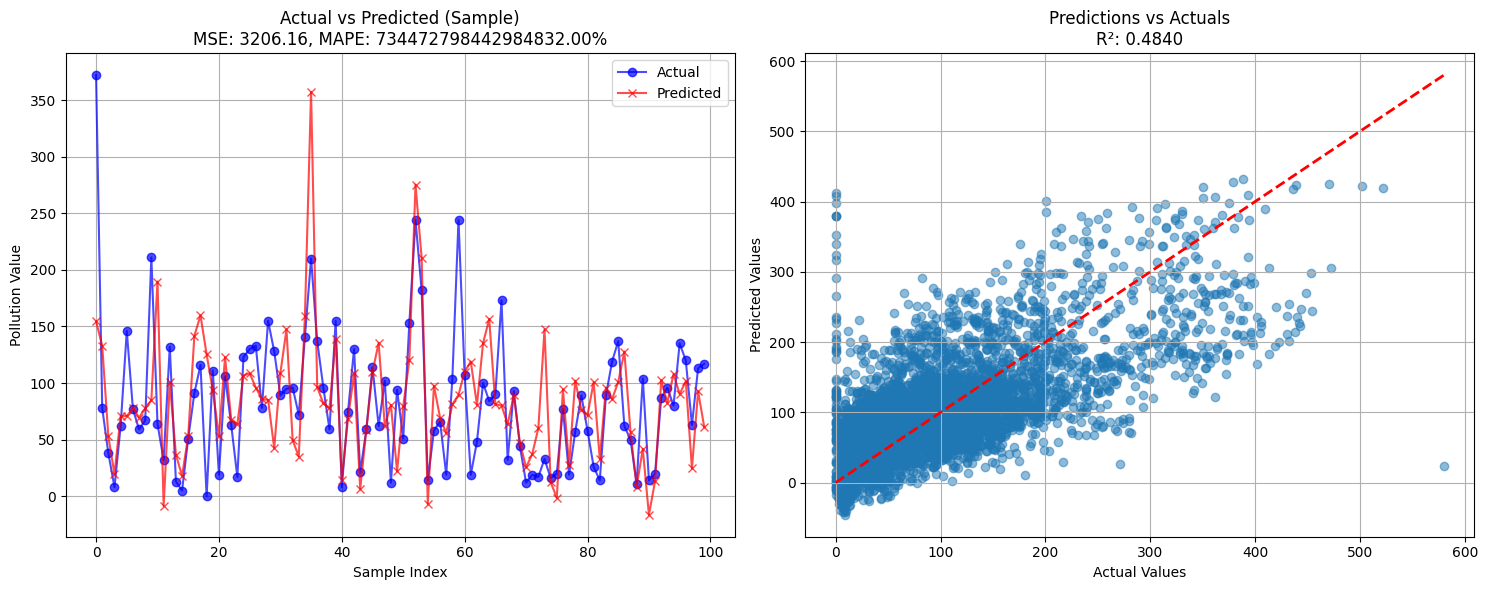

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


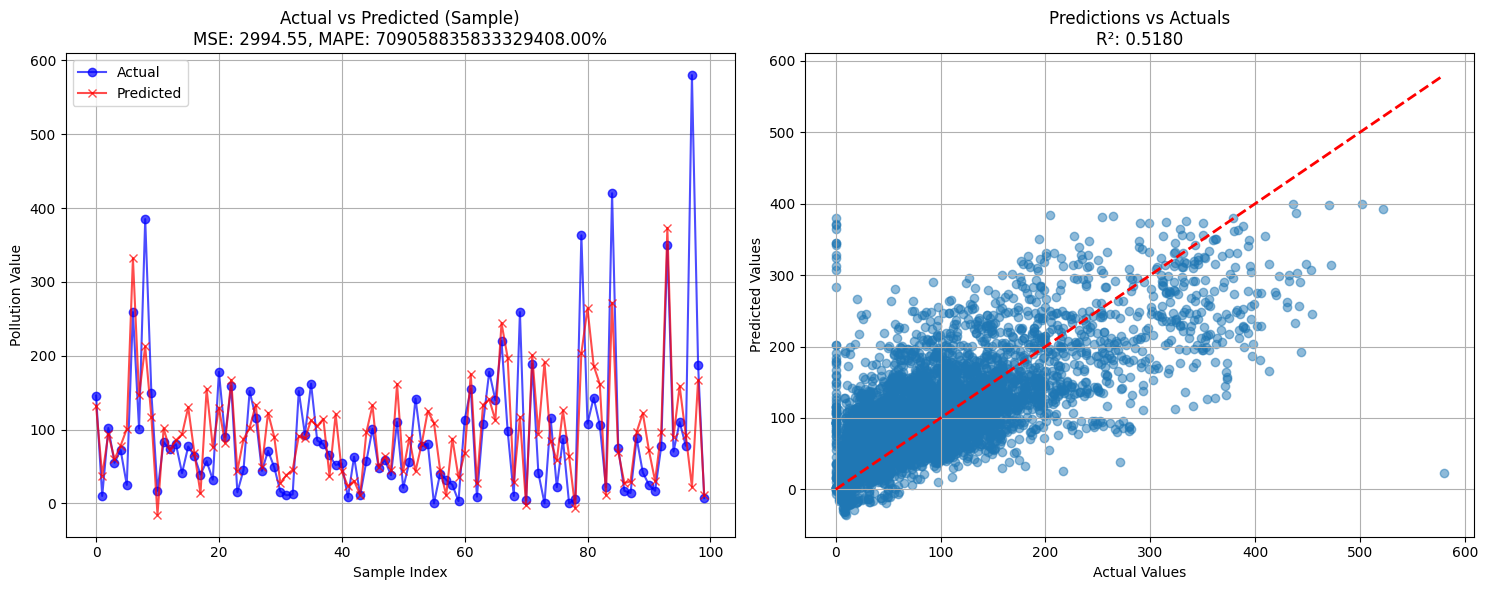

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


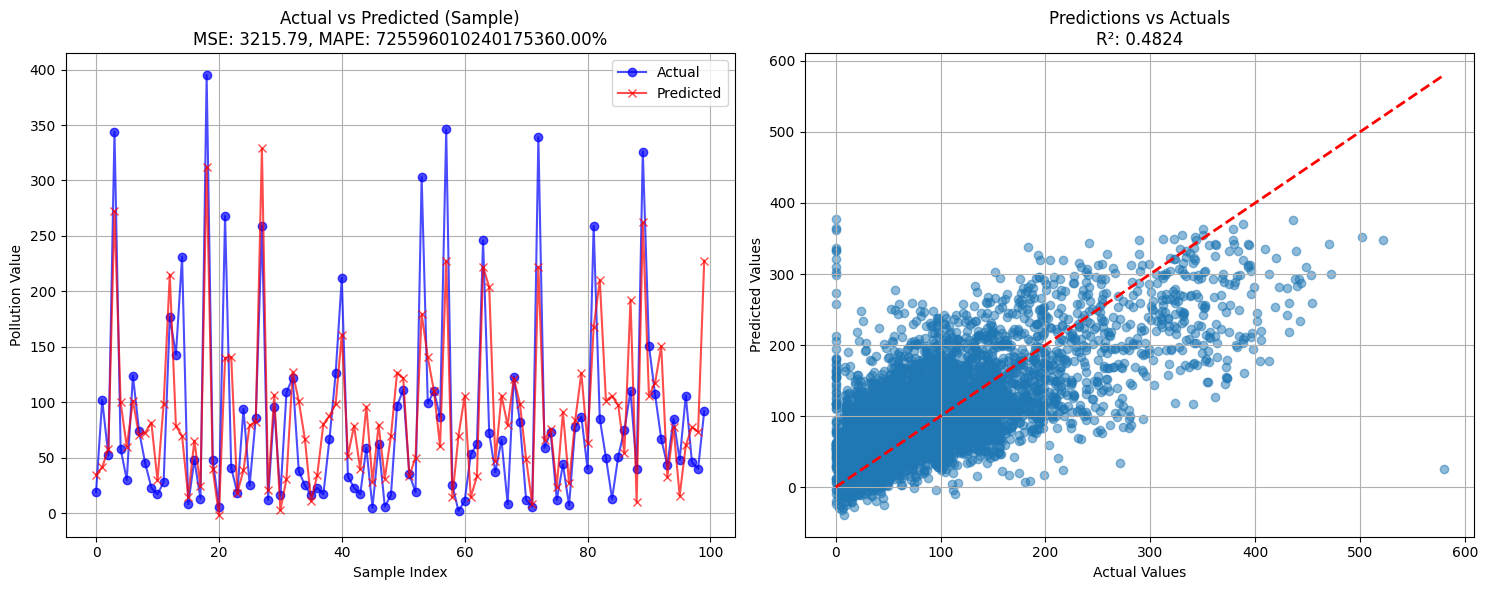

{'MSE': 3215.7937545441387,
 'MAPE': 7.255960102401754e+17,
 'R2': 0.48242227151905637}

In [41]:
plot_predictions_vs_real(
    model=results_multi_mlp['models']['simple'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='mlp',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)
plot_predictions_vs_real(
    model=results_multi_mlp['models']['deep'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='mlp',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)
plot_predictions_vs_real(
    model=results_multi_mlp['models']['residual'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='mlp',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)

In [37]:
log_multivariate_to_dagshub(
    model=results_multi_mlp['models']['simple'],
    architecture="simple",
    model_type="mlp",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)

Initialized MLflow to track repo "daduke1/proyecto-modelos"

Repository daduke1/proyecto-modelos initialized!

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


Successfully registered model 'pollution_mlp_simple'.
2025/05/14 22:52:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_mlp_simple, version 1
Created version '1' of model 'pollution_mlp_simple'.



✅ Successfully logged mlp (simple) to DagsHub:
        - Run ID: 0ecf8fb683df4e5c99ce0bdb8fe9a6d1
        - Metrics: {'MSE': 3206.1643937604767, 'RMSE': np.float64(56.62300233792338), 'MAPE': 7.344727984429848e+17, 'R2': 0.4839721043322113}
        - Model URI: runs:/0ecf8fb683df4e5c99ce0bdb8fe9a6d1/mlp_model
        
🏃 View run mlp-simple at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/0ecf8fb683df4e5c99ce0bdb8fe9a6d1
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


{'MSE': 3206.1643937604767,
 'RMSE': np.float64(56.62300233792338),
 'MAPE': 7.344727984429848e+17,
 'R2': 0.4839721043322113}

In [38]:
log_multivariate_to_dagshub(
    model=results_multi_mlp['models']['deep'],
    architecture="deep",
    model_type="mlp",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)
log_multivariate_to_dagshub(
    model=results_multi_mlp['models']['residual'],
    architecture="residual",
    model_type="mlp",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)

Initialized MLflow to track repo "daduke1/proyecto-modelos"

Repository daduke1/proyecto-modelos initialized!

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


Successfully registered model 'pollution_mlp_deep'.
2025/05/14 22:53:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_mlp_deep, version 1
Created version '1' of model 'pollution_mlp_deep'.



✅ Successfully logged mlp (deep) to DagsHub:
        - Run ID: fd1d583315ac44589376a8343cb4b7be
        - Metrics: {'MSE': 2994.545335458991, 'RMSE': np.float64(54.72243904888552), 'MAPE': 7.090588358333294e+17, 'R2': 0.5180319103580757}
        - Model URI: runs:/fd1d583315ac44589376a8343cb4b7be/mlp_model
        
🏃 View run mlp-deep at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/fd1d583315ac44589376a8343cb4b7be
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


Initialized MLflow to track repo "daduke1/proyecto-modelos"

Repository daduke1/proyecto-modelos initialized!

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Successfully registered model 'pollution_mlp_residual'.
2025/05/14 22:54:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_mlp_residual, version 1
Created version '1' of model 'pollution_mlp_residual'.



✅ Successfully logged mlp (residual) to DagsHub:
        - Run ID: 8870f53438f54abbbab948fd1e068394
        - Metrics: {'MSE': 3215.7937545441387, 'RMSE': np.float64(56.70796905677489), 'MAPE': 7.255960102401754e+17, 'R2': 0.48242227151905637}
        - Model URI: runs:/8870f53438f54abbbab948fd1e068394/mlp_model
        
🏃 View run mlp-residual at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/8870f53438f54abbbab948fd1e068394
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


{'MSE': 3215.7937545441387,
 'RMSE': np.float64(56.70796905677489),
 'MAPE': 7.255960102401754e+17,
 'R2': 0.48242227151905637}

#### CNN

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import keras

def build_train_multivariate_cnns(X_train, y_train, X_val, y_val,
                                 n_steps_in=72, 
                                 n_features=10,
                                 n_steps_out=24,
                                 epochs=100,
                                 batch_size=32):
    """
    Builds and trains 3 CNN architectures for multivariate time series forecasting.
    
    Args:
        X_train: Training data (samples, timesteps, features)
        y_train: Targets (samples, n_steps_out)
        X_val: Validation data
        y_val: Validation targets
        n_steps_in: Lookback window
        n_features: Number of features
        n_steps_out: Forecast horizon
        epochs: Training epochs
        batch_size: Batch size
    
    Returns:
        Dictionary containing models and training histories
    """
    input_shape = (n_steps_in, n_features)
    
    models = {}
    histories = {}
    
    # --- Architecture 1: Basic CNN ---
    models['basic_cnn'] = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(n_steps_out)
    ], name='basic_cnn')
    
    # --- Architecture 2: Deep CNN with Dropout ---
    models['deep_cnn'] = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(n_steps_out)
    ], name='deep_cnn')
    
    # --- Architecture 3: Hybrid CNN with Residual Connections ---
    def residual_block(x, filters, kernel_size=3):
        shortcut = x
        x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        return keras.layers.add([shortcut, x])
    
    input_layer = keras.Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu')(input_layer)
    x = MaxPooling1D(2)(x)
    x = residual_block(x, 64)
    x = Flatten()(x)
    output_layer = Dense(n_steps_out)(x)
    models['residual_cnn'] = keras.Model(inputs=input_layer, outputs=output_layer, name='residual_cnn')
    
    # Compile and train all models
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    for name, model in models.items():
        model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='mse',
                     metrics=['mae'])
        
        print(f"\nTraining {name}...")
        histories[name] = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
    
    return {
        'models': models,
        'histories': histories,
        'input_shape': input_shape,
        'output_shape': n_steps_out
    }

In [47]:
results_multi_cnn = build_train_multivariate_cnns(
    X_train_multi, 
    y_train_multi,
    X_val_multi, 
    y_val_multi,
    n_steps_in=n_steps_in,
    n_features=n_features,
    n_steps_out=n_steps_out,
    epochs=100,
    batch_size=64
)

/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training basic_cnn...
Epoch 1/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4966 - mae: 0.4940 - val_loss: 0.3936 - val_mae: 0.4054
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3577 - mae: 0.4086 - val_loss: 0.3953 - val_mae: 0.4042
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3289 - mae: 0.3849 - val_loss: 0.4371 - val_mae: 0.4145
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3151 - mae: 0.3719 - val_loss: 0.3926 - val_mae: 0.3965
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2760 - mae: 0.3592 - val_loss: 0.3872 - val_mae: 0.3903
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2738 - mae: 0.3513 - val_loss: 0.4544 - val_mae: 0.4255
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2583 - mae: 0.3428 - val_loss: 0.4173 - val_mae: 0.4148
Epoch 8/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2347 - mae: 0.3318 - val_loss: 0.4427 - val_mae: 0.4247
Epoch 9/100
479/479 ━━━━━

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step


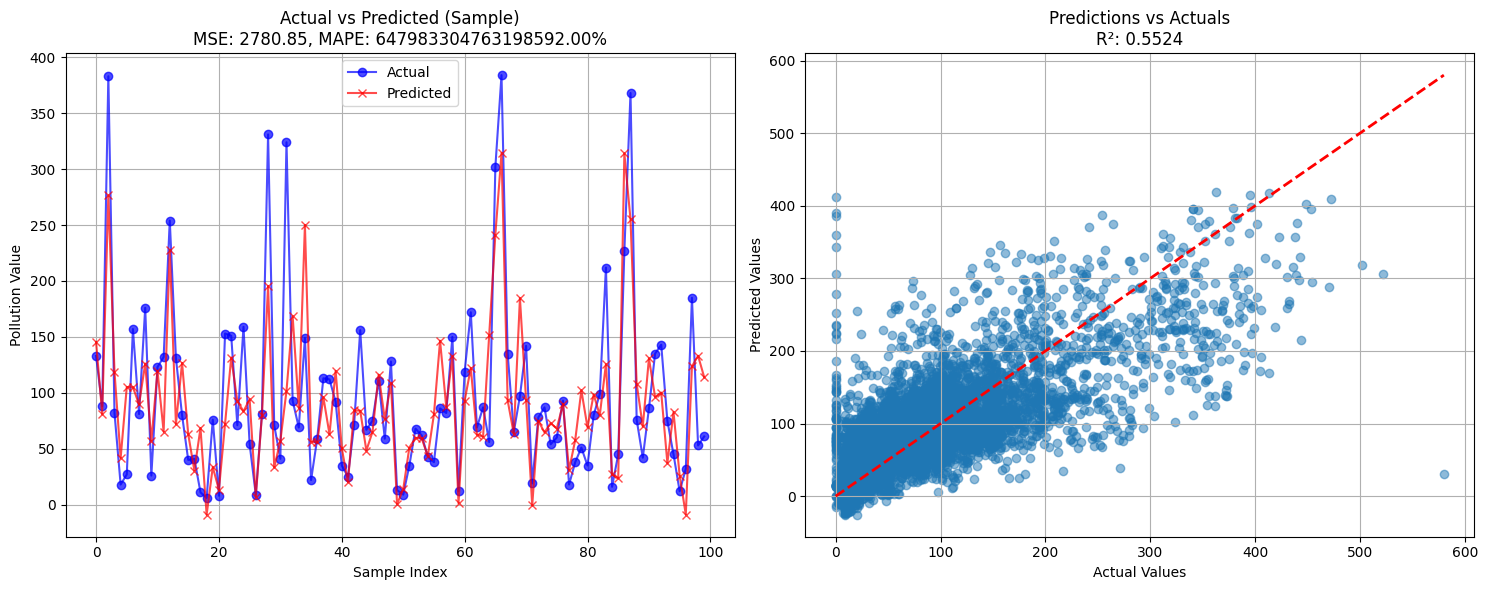

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


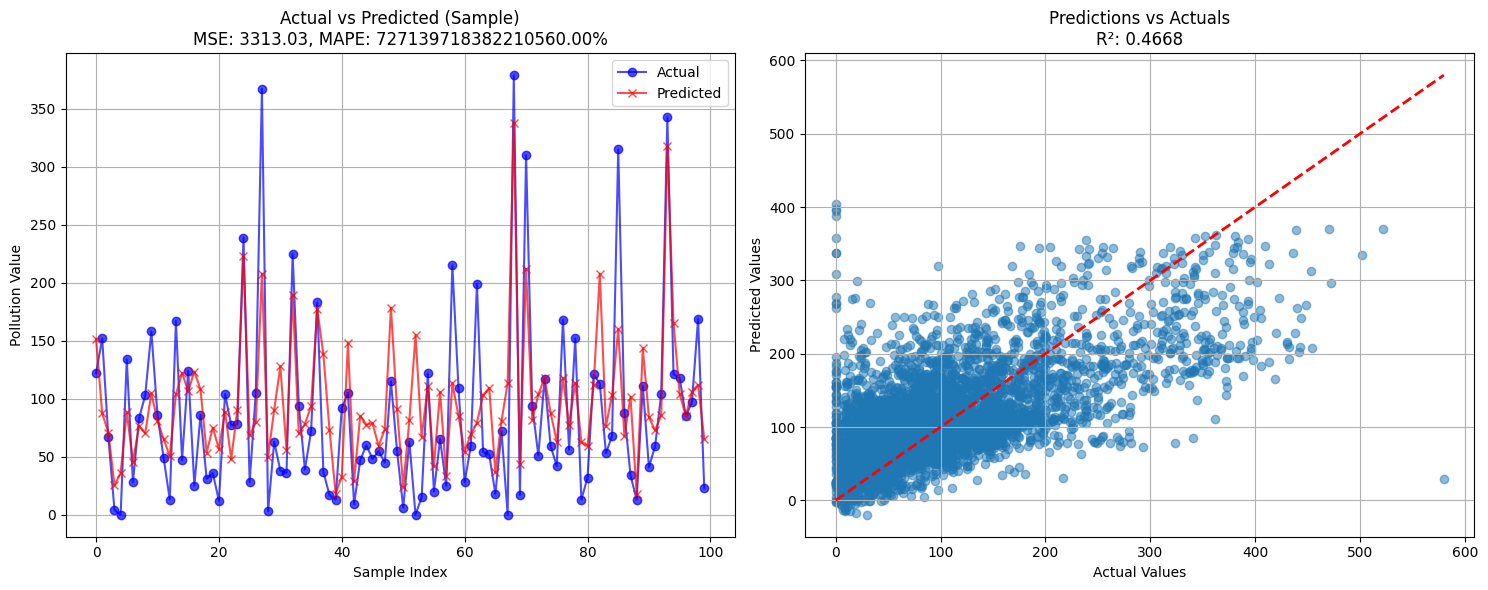

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


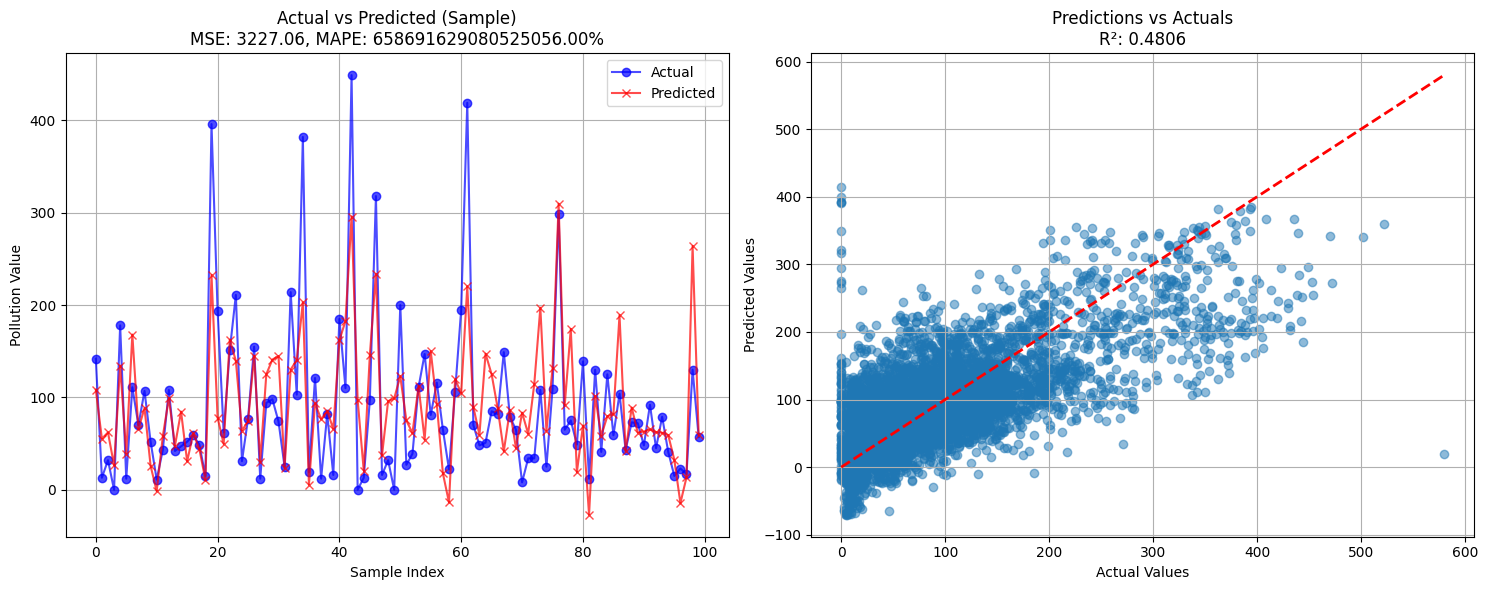

{'MSE': 3227.0612270761203,
 'MAPE': 6.58691629080525e+17,
 'R2': 0.48060878679834507}

In [48]:
plot_predictions_vs_real(
    model=results_multi_cnn['models']['basic_cnn'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='cnn',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)
plot_predictions_vs_real(
    model=results_multi_cnn['models']['deep_cnn'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='cnn',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)
plot_predictions_vs_real(
    model=results_multi_cnn['models']['residual_cnn'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='cnn',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)

In [49]:
log_multivariate_to_dagshub(
    model=results_multi_cnn['models']['basic_cnn'],
    architecture="basic",
    model_type="cnn",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)
log_multivariate_to_dagshub(
    model=results_multi_cnn['models']['deep_cnn'],
    architecture="deep",
    model_type="cnn",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)
log_multivariate_to_dagshub(
    model=results_multi_cnn['models']['residual_cnn'],
    architecture="residual",
    model_type="cnn",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


Successfully registered model 'pollution_cnn_basic'.
2025/05/14 23:09:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_cnn_basic, version 1
Created version '1' of model 'pollution_cnn_basic'.



✅ Successfully logged cnn (basic) to DagsHub:
        - Run ID: 1ff47f721ca444a79f4231e5af4e3cd4
        - Metrics: {'MSE': 2780.8459154308393, 'RMSE': np.float64(52.73372654602403), 'MAPE': 6.479833047631986e+17, 'R2': 0.552426547837414}
        - Model URI: runs:/1ff47f721ca444a79f4231e5af4e3cd4/cnn_model
        
🏃 View run cnn-basic at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/1ff47f721ca444a79f4231e5af4e3cd4
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


Successfully registered model 'pollution_cnn_deep'.
2025/05/14 23:10:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_cnn_deep, version 1
Created version '1' of model 'pollution_cnn_deep'.



✅ Successfully logged cnn (deep) to DagsHub:
        - Run ID: f62beaf354b24bfea22843be83dd6ec6
        - Metrics: {'MSE': 3313.029188614347, 'RMSE': np.float64(57.55891927941617), 'MAPE': 7.271397183822106e+17, 'R2': 0.4667723577076369}
        - Model URI: runs:/f62beaf354b24bfea22843be83dd6ec6/cnn_model
        
🏃 View run cnn-deep at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/f62beaf354b24bfea22843be83dd6ec6
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


Successfully registered model 'pollution_cnn_residual'.
2025/05/14 23:10:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_cnn_residual, version 1
Created version '1' of model 'pollution_cnn_residual'.



✅ Successfully logged cnn (residual) to DagsHub:
        - Run ID: db270df7fac143e192d53c4febb4dcee
        - Metrics: {'MSE': 3227.0612270761203, 'RMSE': np.float64(56.80722865160842), 'MAPE': 6.58691629080525e+17, 'R2': 0.48060878679834507}
        - Model URI: runs:/db270df7fac143e192d53c4febb4dcee/cnn_model
        
🏃 View run cnn-residual at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/db270df7fac143e192d53c4febb4dcee
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


{'MSE': 3227.0612270761203,
 'RMSE': np.float64(56.80722865160842),
 'MAPE': 6.58691629080525e+17,
 'R2': 0.48060878679834507}

#### LSTM

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Input

def build_train_multivariate_lstms(X_train, y_train, X_val, y_val,
                                  n_steps_in=72, 
                                  n_features=10,
                                  n_steps_out=24,
                                  epochs=100,
                                  batch_size=32):
    """
    Builds and trains 3 LSTM architectures for multivariate time series forecasting.
    
    Args:
        X_train: Training data (samples, timesteps, features)
        y_train: Targets (samples, n_steps_out)
        X_val: Validation data
        y_val: Validation targets
        n_steps_in: Lookback window
        n_features: Number of features
        n_steps_out: Forecast horizon
        epochs: Training epochs
        batch_size: Batch size
    
    Returns:
        Dictionary containing models and training histories
    """
    input_shape = (n_steps_in, n_features)
    
    models = {}
    histories = {}
    
    # --- Architecture 1: Vanilla LSTM ---
    models['vanilla_lstm'] = Sequential([
        LSTM(100, activation='tanh', input_shape=input_shape),
        Dense(n_steps_out)
    ], name='vanilla_lstm')
    
    # --- Architecture 2: Stacked LSTM with Dropout ---
    models['stacked_lstm'] = Sequential([
        Input(shape=(n_steps_in, n_features)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dense(1)
    ], name='stacked_lstm')
    
    # --- Architecture 3: Bidirectional LSTM ---
    models['bidirectional_lstm'] = Sequential([
        Bidirectional(LSTM(100, activation='tanh', return_sequences=True), 
                       input_shape=input_shape),
        Bidirectional(LSTM(50, activation='tanh')),
        Dense(n_steps_out)
    ], name='bidirectional_lstm')
    
    # Compile and train all models
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    for name, model in models.items():
        model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='mse')
        
        print(f"\nTraining {name}...")
        histories[name] = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
    
    return {
        'models': models,
        'histories': histories,
        'input_shape': input_shape,
        'output_shape': n_steps_out
    }

In [51]:
results_multi_lstm = build_train_multivariate_lstms(
    X_train_multi, 
    y_train_multi,
    X_val_multi, 
    y_val_multi,
    n_steps_in=n_steps_in,
    n_features=n_features,
    n_steps_out=n_steps_out,
    epochs=100,
    batch_size=64
)

/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training vanilla_lstm...
Epoch 1/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.4553 - val_loss: 0.5135
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3553 - val_loss: 0.4416
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.3315 - val_loss: 0.3334
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.3130 - val_loss: 0.3785
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2917 - val_loss: 0.4179
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2831 - val_loss: 0.4550
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2660 - val_loss: 0.4665
Epoch 8/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2449 - val_loss: 0.3705
Epoch 9/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2329 - val_loss: 0.3860
Epoch 10/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2198 - val_loss: 0.4266
Epoch 11/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1939 - val_loss: 0.3919
Epoc

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


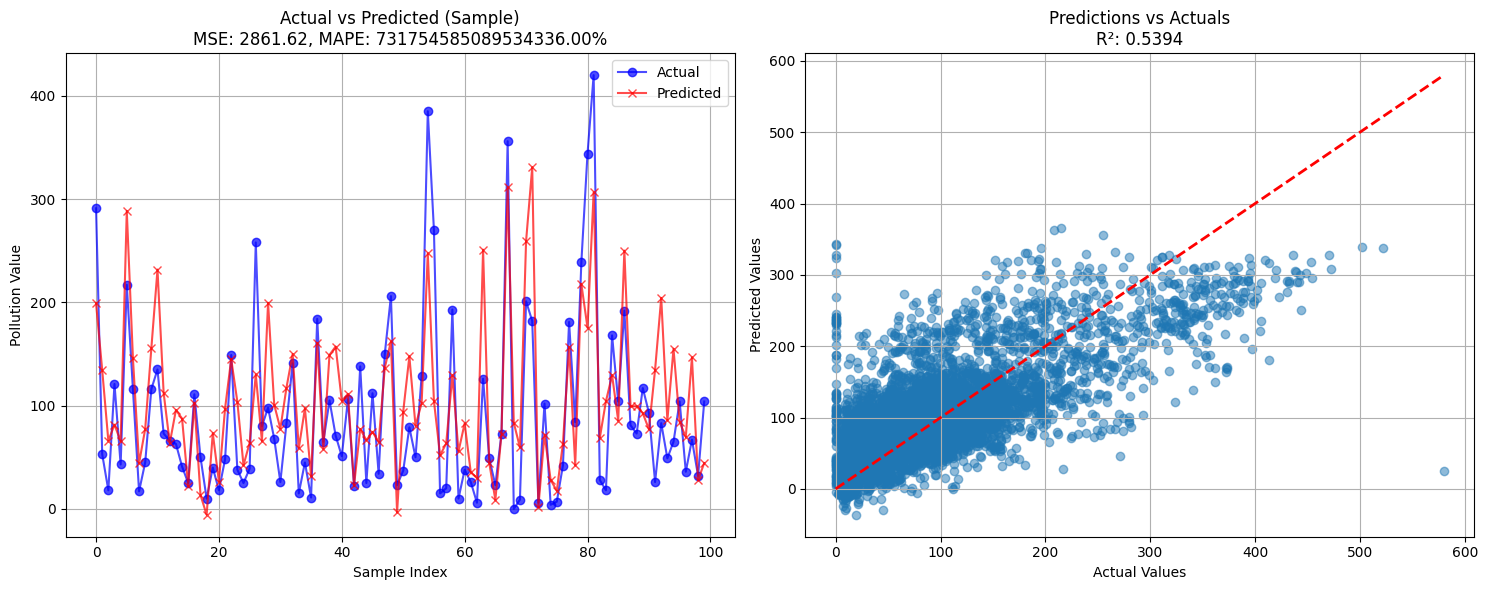

205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


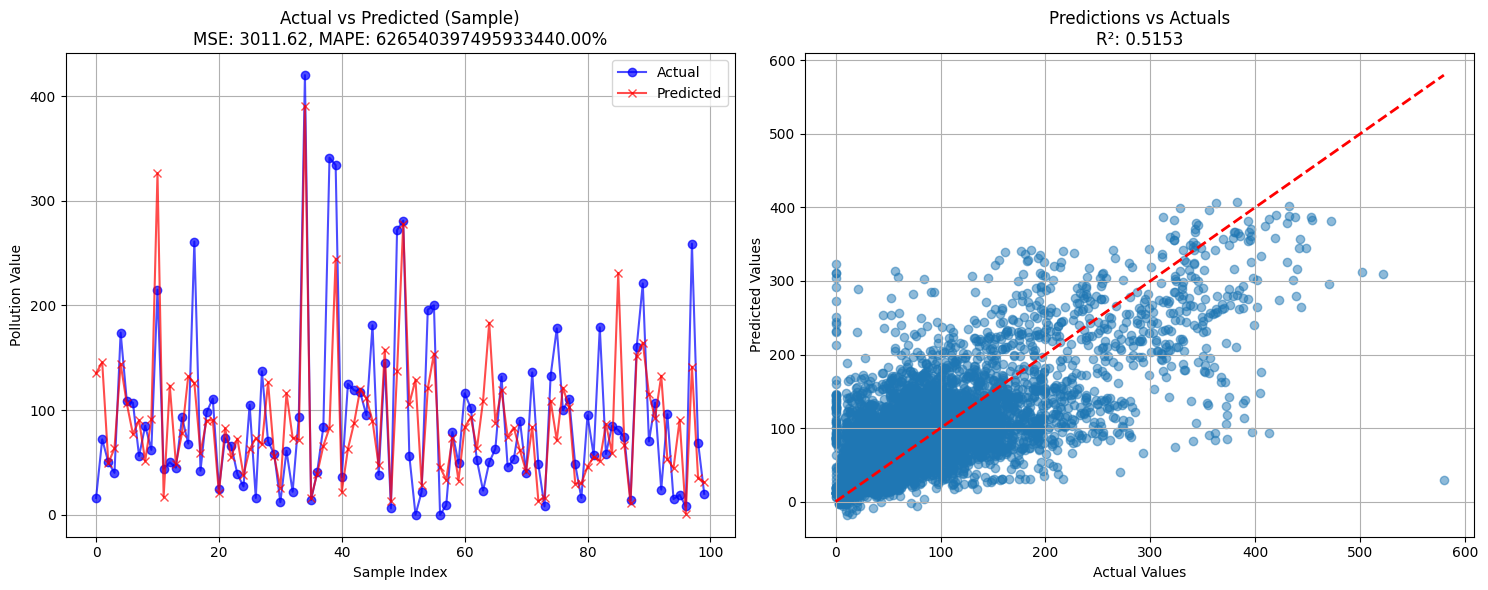

205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


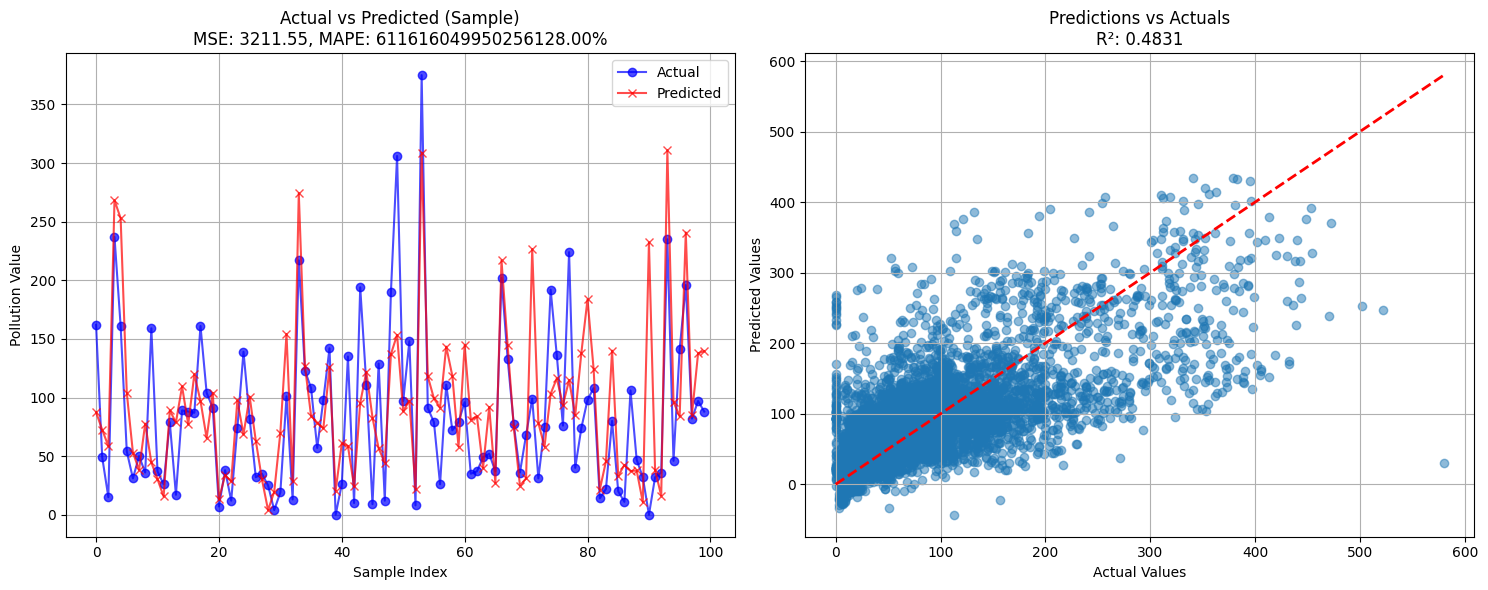

{'MSE': 3211.552853614796,
 'MAPE': 6.116160499502561e+17,
 'R2': 0.48310483888414946}

In [52]:
plot_predictions_vs_real(
    model=results_multi_lstm['models']['vanilla_lstm'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='lstm',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)
plot_predictions_vs_real(
    model=results_multi_lstm['models']['stacked_lstm'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='lstm',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)
plot_predictions_vs_real(
    model=results_multi_lstm['models']['bidirectional_lstm'],
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    model_type='lstm',
    n_steps_in=n_steps_in,
    n_features=n_features,
    sample_size=100
)

In [53]:
log_multivariate_to_dagshub(
    model=results_multi_lstm['models']['vanilla_lstm'],
    architecture="vanilla",
    model_type="lstm",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)
log_multivariate_to_dagshub(
    model=results_multi_lstm['models']['stacked_lstm'],
    architecture="stacked",
    model_type="lstm",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)
log_multivariate_to_dagshub(
    model=results_multi_lstm['models']['bidirectional_lstm'],
    architecture="bidirectional",
    model_type="lstm",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features,
    experiment_name="regresion",
)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Successfully registered model 'pollution_lstm_vanilla'.
2025/05/15 00:03:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_lstm_vanilla, version 1
Created version '1' of model 'pollution_lstm_vanilla'.



✅ Successfully logged lstm (vanilla) to DagsHub:
        - Run ID: 2e6707cd78b249488a7c49c3a7da03cd
        - Metrics: {'MSE': 2861.6244261021093, 'RMSE': np.float64(53.49415319548585), 'MAPE': 7.317545850895343e+17, 'R2': 0.5394253539628906}
        - Model URI: runs:/2e6707cd78b249488a7c49c3a7da03cd/lstm_model
        
🏃 View run lstm-vanilla at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/2e6707cd78b249488a7c49c3a7da03cd
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Successfully registered model 'pollution_lstm_stacked'.
2025/05/15 00:03:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_lstm_stacked, version 1
Created version '1' of model 'pollution_lstm_stacked'.



✅ Successfully logged lstm (stacked) to DagsHub:
        - Run ID: 92bfc87f6f5843229d6dd21fddadb067
        - Metrics: {'MSE': 3011.620096068323, 'RMSE': np.float64(54.87822970967926), 'MAPE': 6.265403974959334e+17, 'R2': 0.515283750343757}
        - Model URI: runs:/92bfc87f6f5843229d6dd21fddadb067/lstm_model
        
🏃 View run lstm-stacked at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/92bfc87f6f5843229d6dd21fddadb067
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


Successfully registered model 'pollution_lstm_bidirectional'.
2025/05/15 00:03:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_lstm_bidirectional, version 1
Created version '1' of model 'pollution_lstm_bidirectional'.



✅ Successfully logged lstm (bidirectional) to DagsHub:
        - Run ID: c4c8d63b4ef94ae289922bc3153317bb
        - Metrics: {'MSE': 3211.552853614796, 'RMSE': np.float64(56.67056426060002), 'MAPE': 6.116160499502561e+17, 'R2': 0.48310483888414946}
        - Model URI: runs:/c4c8d63b4ef94ae289922bc3153317bb/lstm_model
        
🏃 View run lstm-bidirectional at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/c4c8d63b4ef94ae289922bc3153317bb
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


{'MSE': 3211.552853614796,
 'RMSE': np.float64(56.67056426060002),
 'MAPE': 6.116160499502561e+17,
 'R2': 0.48310483888414946}

#### ConvLSTM

In [19]:
from tensorflow.keras.layers import ConvLSTM2D

def build_train_multivariate_convlstm(X_train, y_train, X_val, y_val,
                                     n_steps_in=24,
                                     n_features=7,
                                     n_steps_out=1,
                                     epochs=100,
                                     batch_size=32):
    """
    Builds and trains 3 ConvLSTM architectures for multivariate forecasting.
    
    Args:
        X_train: Training data (samples, timesteps, features)
        y_train: Targets (samples, n_steps_out)
        X_val: Validation data
        y_val: Validation targets
        n_steps_in: Lookback window
        n_features: Number of features
        n_steps_out: Forecast horizon
        epochs: Training epochs
        batch_size: Batch size
    
    Returns:
        Dictionary containing models and training histories
    """
    # Reshape input for ConvLSTM2D (samples, timesteps, rows, cols, channels)
    X_train_reshaped = X_train.reshape(X_train.shape[0], 1, n_steps_in, n_features, 1)
    X_val_reshaped = X_val.reshape(X_val.shape[0], 1, n_steps_in, n_features, 1)
    
    input_shape = (1, n_steps_in, n_features, 1)  # (sequences, rows, cols, channels)
    
    models = {}
    histories = {}
    
    # --- Architecture 1: Basic ConvLSTM ---
    models['basic_convlstm'] = Sequential([
        ConvLSTM2D(filters=64, kernel_size=(1,3), activation='tanh',
                  input_shape=input_shape, padding='same', return_sequences=False),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(n_steps_out)
    ], name='basic_convlstm')
    
    # --- Architecture 2: Deep ConvLSTM ---
    models['deep_convlstm'] = Sequential([
        ConvLSTM2D(filters=128, kernel_size=(1,3), activation='tanh',
                  input_shape=input_shape, padding='same', return_sequences=True),
        BatchNormalization(),
        ConvLSTM2D(filters=64, kernel_size=(1,3), activation='tanh',
                  padding='same', return_sequences=False),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(n_steps_out)
    ], name='deep_convlstm')
    
    # --- Architecture 3: Hybrid ConvLSTM-CNN ---  
    models['hybrid_convlstm'] = Sequential([
        ConvLSTM2D(filters=64, kernel_size=(3,3), activation='tanh',
                  input_shape=input_shape, padding='same', return_sequences=True),
        TimeDistributed(Flatten()),
        TimeDistributed(Dense(32, activation='relu')),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(n_steps_out)
    ], name='hybrid_convlstm')
    
    # Compile and train all models
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    for name, model in models.items():
        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mse')
        
        print(f"\nTraining {name}...")
        histories[name] = model.fit(
            X_train_reshaped, y_train,
            validation_data=(X_val_reshaped, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop],
            verbose=1
        )
    
    return {
        'models': models,
        'histories': histories,
        'input_shape': input_shape,
        'output_shape': n_steps_out
    }

In [24]:
results_multi_convlstm = build_train_multivariate_convlstm(
    X_train_multi, 
    y_train_multi,
    X_val_multi, 
    y_val_multi,
    n_steps_in=n_steps_in,
    n_features=n_features,
    n_steps_out=n_steps_out,
    epochs=100,
    batch_size=64
)


Training basic_convlstm...
Epoch 1/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.4130 - val_loss: 0.4822
Epoch 2/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3575 - val_loss: 0.4786
Epoch 3/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 0.3385 - val_loss: 0.5411
Epoch 4/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3252 - val_loss: 0.3749
Epoch 5/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.2981 - val_loss: 0.4391
Epoch 6/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.2888 - val_loss: 0.3194
Epoch 7/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.2865 - val_loss: 0.3706
Epoch 8/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.2766 - val_loss: 0.3564
Epoch 9/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.2816 - val_loss: 0.4063
Epoch 10/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.2530 - val_loss: 0.4453
Epoch 11/100
479/479 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.2490 - val_loss

In [26]:
def plot_convlstm_predictions(models_dict, X_test, y_test, n_steps_in=24, n_features=7, n_samples=5):
    """
    Plots real vs predicted values for ConvLSTM models.
    
    Args:
        models_dict: Dictionary of trained ConvLSTM models {'name': model}
        X_test: Test features (samples, timesteps, features)
        y_test: Test targets (samples, 1)
        n_steps_in: Lookback window size (default: 24)
        n_features: Number of features (default: 7)
        n_samples: Number of samples to plot (default: 5)
    """
    # Reshape test data for ConvLSTM
    X_test_reshaped = X_test.reshape(-1, 1, n_steps_in, n_features, 1)
    
    plt.figure(figsize=(15, 3*n_samples))
    
    for i in range(min(n_samples, len(X_test))):
        plt.subplot(n_samples, 1, i+1)
        
        # Plot actual value
        plt.plot([n_steps_in], [y_test[i]], 'bo', markersize=10, label='Actual')
        
        # Plot predictions for each model
        for model_name, model in models_dict.items():
            # Make prediction
            y_pred = model.predict(X_test_reshaped[i:i+1])
            
            # Plot prediction
            plt.plot([n_steps_in], [y_pred[0][0]], 'x', markersize=10, 
                    label=f'{model_name} Predicted')
        
        # Formatting
        plt.title(f'Sample {i+1} - Actual vs Predicted Values')
        plt.xlabel('Time Step')
        plt.ylabel('Target Value')
        plt.xticks(np.arange(n_steps_in+1))
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


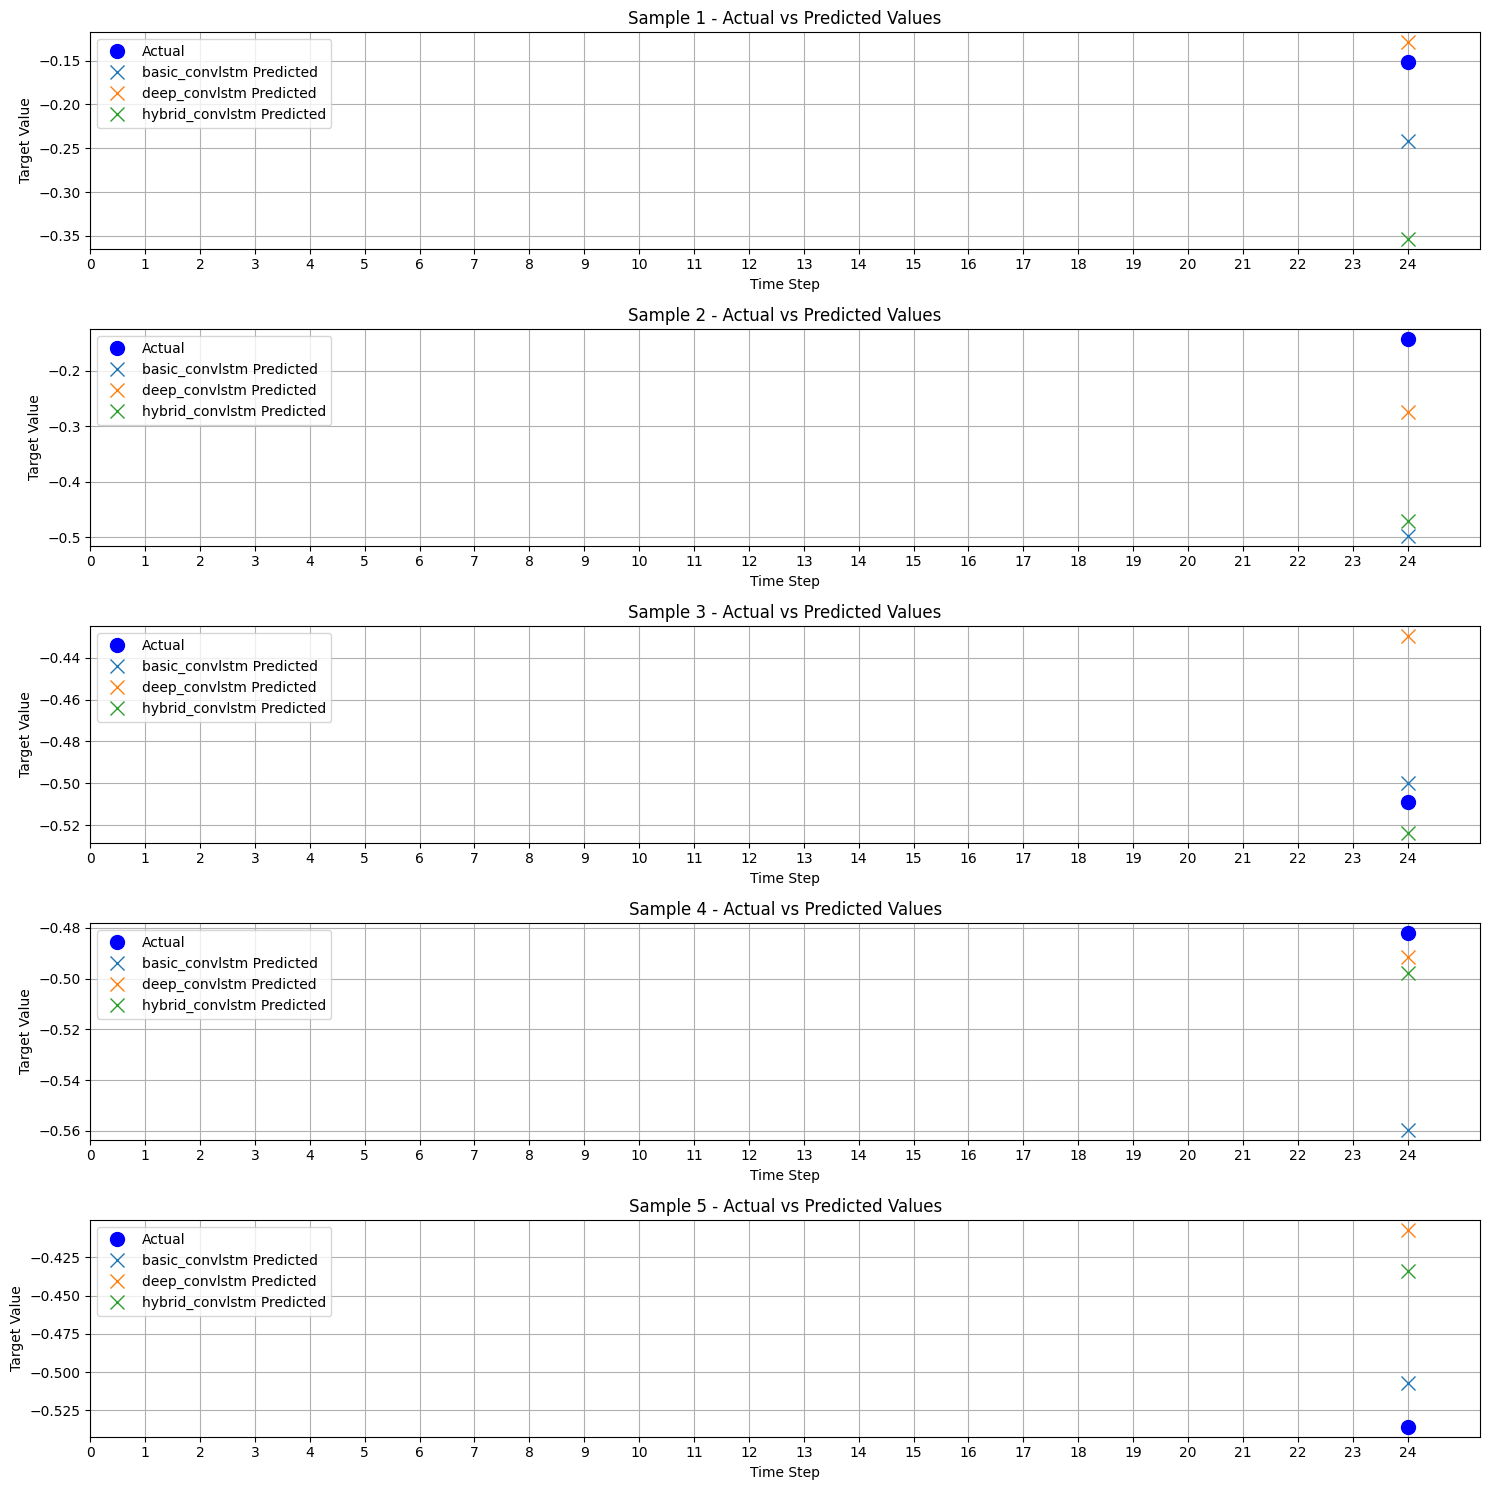

In [28]:
plot_convlstm_predictions(
    results_multi_convlstm['models'],
    X_test_multi,
    y_test_multi,
    n_steps_in=n_steps_in,
    n_features=n_features,
    n_samples=5
)

In [30]:
def log_convlstm_to_dagshub(
    model,
    architecture,
    X_test,
    y_test,
    scaler,
    preprocessing_info,
    n_steps_in=24,
    n_steps_out=1,
    n_features=7,
    experiment_name="regresion",
    plot_sample_size=5
):

    with mlflow.start_run(run_name=f"convlstm-{architecture}"):
        mlflow.log_params({
            "model_type": "convlstm",
            "architecture": architecture,
            "n_steps_in": n_steps_in,
            "n_steps_out": n_steps_out,
            "n_features": n_features,
            "scaler": str(scaler.__class__.__name__),
            "train_samples": preprocessing_info.get('train_samples', 'N/A'),
            "test_samples": len(X_test)
        })

        # Reshape for ConvLSTM: (samples, 1, timesteps, features, 1)
        X_test_reshaped = X_test.reshape(X_test.shape[0], 1, n_steps_in, n_features, 1)
        y_pred = model.predict(X_test_reshaped)

        y_test_flat = y_test.reshape(-1, 1)
        y_pred_flat = y_pred.reshape(-1, 1)

        dummy_test = np.zeros((len(y_test_flat), n_features + 1))
        dummy_pred = np.zeros((len(y_pred_flat), n_features + 1))
        dummy_test[:, -1] = y_test_flat.flatten()
        dummy_pred[:, -1] = y_pred_flat.flatten()

        y_test_inv = scaler.inverse_transform(dummy_test)[:, -1]
        y_pred_inv = scaler.inverse_transform(dummy_pred)[:, -1]

        metrics = {
            'MSE': mean_squared_error(y_test_inv, y_pred_inv),
            'RMSE': np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)),
            'MAPE': mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100,
            'R2': r2_score(y_test_inv, y_pred_inv)
        }
        mlflow.log_metrics(metrics)

        signature = infer_signature(X_test_reshaped, y_pred)
        mlflow.keras.log_model(
            model=model,
            artifact_path=f"convlstm_model",
            signature=signature,
            registered_model_name=f"pollution_convlstm_{architecture}"
        )

        # Plot: Actual vs Predicted
        plt.figure(figsize=(12, 6))
        sample_indices = np.random.choice(len(y_test_inv), size=min(plot_sample_size, len(y_test_inv)), replace=False)
        plt.plot(y_test_inv[sample_indices], label='Actual', color='blue', alpha=0.7, marker='o')
        plt.plot(y_pred_inv[sample_indices], label='Predicted', color='red', alpha=0.7, marker='x')
        plt.title(f'{architecture} ConvLSTM: Actual vs Predicted\nMSE: {metrics["MSE"]:.2f}, MAPE: {metrics["MAPE"]:.2f}%')
        plt.xlabel('Sample Index')
        plt.ylabel('Pollution Value')
        plt.legend()
        plt.grid(True)
        mlflow.log_figure(plt.gcf(), f"actual_vs_predicted_convlstm.png")
        plt.close()

        # Scatter plot
        plt.figure(figsize=(8, 8))
        plt.scatter(y_test_inv, y_pred_inv, alpha=0.5)
        plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 
                '--', color='red', linewidth=2)
        plt.title(f'{architecture} ConvLSTM: Predictions vs Actuals\nR²: {metrics["R2"]:.4f}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True)
        mlflow.log_figure(plt.gcf(), f"scatter_plot_convlstm.png")
        plt.close()

        # Log scaler info
        mlflow.log_dict({
            'scaler_type': str(type(scaler)),
            'scaler_params': scaler.get_params()
        }, "scaler_info.json")

        mlflow.set_tag("project", "proyecto-modelos")
        mlflow.set_tag("task", "multivariate_time_series_forecasting")
        mlflow.set_tag("target_variable", "pollution")

        print(f"""\n✅ Successfully logged convlstm ({architecture}) to DagsHub:
        - Run ID: {mlflow.active_run().info.run_id}
        - Metrics: {metrics}
        - Model URI: runs:/{mlflow.active_run().info.run_id}/convlstm_model
        """)
        
        return metrics


In [32]:
from mlflow.models.signature import infer_signature

log_convlstm_to_dagshub(
    model=results_multi_convlstm['models']['basic_convlstm'],
    architecture="basic",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features
)
log_convlstm_to_dagshub(
    model=results_multi_convlstm['models']['deep_convlstm'],
    architecture="deep",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features
)
log_convlstm_to_dagshub(
    model=results_multi_convlstm['models']['hybrid_convlstm'],
    architecture="hybrid",
    X_test=X_test_multi,
    y_test=y_test_multi,
    scaler=scaler,
    preprocessing_info={
        'train_samples': len(X_train_multi),
        'val_samples': len(X_val_multi),
        'test_samples': len(X_test_multi)
    },
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    n_features=n_features
)

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Successfully registered model 'pollution_convlstm_basic'.
2025/05/15 09:33:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_convlstm_basic, version 1
Created version '1' of model 'pollution_convlstm_basic'.



✅ Successfully logged convlstm (basic) to DagsHub:
        - Run ID: a1ef464aa6284296bc03e1f796b8631a
        - Metrics: {'MSE': 3173.4575452049467, 'RMSE': np.float64(56.3334496121527), 'MAPE': 8.013199541648097e+17, 'R2': 0.4892362281141611}
        - Model URI: runs:/a1ef464aa6284296bc03e1f796b8631a/convlstm_model
        
🏃 View run convlstm-basic at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/a1ef464aa6284296bc03e1f796b8631a
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


Successfully registered model 'pollution_convlstm_deep'.
2025/05/15 09:33:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_convlstm_deep, version 1
Created version '1' of model 'pollution_convlstm_deep'.



✅ Successfully logged convlstm (deep) to DagsHub:
        - Run ID: 57bdf5b5300b4c678701dbc5693ec59b
        - Metrics: {'MSE': 3741.273614120047, 'RMSE': np.float64(61.16595142822555), 'MAPE': 7.252897581809033e+17, 'R2': 0.39784698689532627}
        - Model URI: runs:/57bdf5b5300b4c678701dbc5693ec59b/convlstm_model
        
🏃 View run convlstm-deep at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/57bdf5b5300b4c678701dbc5693ec59b
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


Successfully registered model 'pollution_convlstm_hybrid'.
2025/05/15 09:34:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: pollution_convlstm_hybrid, version 1
Created version '1' of model 'pollution_convlstm_hybrid'.



✅ Successfully logged convlstm (hybrid) to DagsHub:
        - Run ID: dacf3ed847b04f36801227bcc61cd4fe
        - Metrics: {'MSE': 3266.236470236794, 'RMSE': np.float64(57.150997106234236), 'MAPE': 6.686652522738647e+17, 'R2': 0.4743035835062688}
        - Model URI: runs:/dacf3ed847b04f36801227bcc61cd4fe/convlstm_model
        
🏃 View run convlstm-hybrid at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/dacf3ed847b04f36801227bcc61cd4fe
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2


{'MSE': 3266.236470236794,
 'RMSE': np.float64(57.150997106234236),
 'MAPE': 6.686652522738647e+17,
 'R2': 0.4743035835062688}

### Comparación modelos univariado vs multivariado

In [121]:
experiment = mlflow.get_experiment_by_name("regresion")
experiment_id = experiment.experiment_id

runs_df = mlflow.search_runs(experiment_ids=[experiment_id],
                             filter_string="attributes.status = 'FINISHED'",
                             output_format="pandas")

In [122]:
runs_df = runs_df[['run_id', 'tags.mlflow.runName', 'metrics.MSE', 'metrics.R2', 'metrics.MAPE', 'tags.task']]
runs_df

run_id tags.mlflow.runName  metrics.MSE  \
0   dacf3ed847b04f36801227bcc61cd4fe     convlstm-hybrid  3266.236470   
1   57bdf5b5300b4c678701dbc5693ec59b       convlstm-deep  3741.273614   
2   a1ef464aa6284296bc03e1f796b8631a      convlstm-basic  3173.457545   
3   c4c8d63b4ef94ae289922bc3153317bb  lstm-bidirectional  3211.552854   
4   92bfc87f6f5843229d6dd21fddadb067        lstm-stacked  3011.620096   
5   2e6707cd78b249488a7c49c3a7da03cd        lstm-vanilla  2861.624426   
6   db270df7fac143e192d53c4febb4dcee        cnn-residual  3227.061227   
7   f62beaf354b24bfea22843be83dd6ec6            cnn-deep  3313.029189   
8   1ff47f721ca444a79f4231e5af4e3cd4           cnn-basic  2780.845915   
9   8870f53438f54abbbab948fd1e068394        mlp-residual  3215.793755   
10  fd1d583315ac44589376a8343cb4b7be            mlp-deep  2994.545335   
11  0ecf8fb683df4e5c99ce0bdb8fe9a6d1          mlp-simple  3206.164394   
12  867eb0e36c39490e81278d32121db21e     convlstm-hybrid   539.834114   
13  40038c41faa14072b494bd4f611b8b6e    convlstm-stacked   494.606215   
14  43512206c0b54dcba0d0ae7468c88f53      convlstm-basic   486.454771   
15  c5b6e9127622420dbd97462e9daf8ee7  lstm-bidirectional   510.335937   
16  89c31e98481c451ab3126f1140a2bbd6        lstm-stacked   471.310378   
17  e2a325cad9a54489ba49eb5af01a4efb        lstm-vanilla   499.360982   
18  e0488964434c4a94a7ca9d47d96a1aab          cnn-hybrid   548.352035   
19  0d9f438dcda14669aa1e9e2b01df33e4            cnn-deep  1542.724684   
20  eeb7a92fcd7f4a829f1762e590f86715          cnn-simple   526.580966   
21  2b9a8defdc244834aeb0cf932f556251            mlp-wide   589.753193   
22  78a77457898543b19a273dee9ade27c9            mlp-deep   508.789611   
23  783c71669d6d4c1099aecab6e84e1d4a         mlp-shallow   480.019419   
24  230acf3460204647b777d7ab5de875d7     dashing-ant-978          NaN   

    metrics.R2  metrics.MAPE                             tags.task  
0     0.474304  6.686653e+17  multivariate_time_series_forecasting  
1     0.397847  7.252898e+17  multivariate_time_series_forecasting  
2     0.489236  8.013200e+17  multivariate_time_series_forecasting  
3     0.483105  6.116160e+17  multivariate_time_series_forecasting  
4     0.515284  6.265404e+17  multivariate_time_series_forecasting  
5     0.539425  7.317546e+17  multivariate_time_series_forecasting  
6     0.480609  6.586916e+17  multivariate_time_series_forecasting  
7     0.466772  7.271397e+17  multivariate_time_series_forecasting  
8     0.552427  6.479833e+17  multivariate_time_series_forecasting  
9     0.482422  7.255960e+17  multivariate_time_series_forecasting  
10    0.518032  7.090588e+17  multivariate_time_series_forecasting  
11    0.483972  7.344728e+17  multivariate_time_series_forecasting  
12    0.912895  2.070631e+15               time_series_forecasting  
13    0.920193  1.982979e+15               time_series_forecasting  
14    0.921508  2.233147e+15               time_series_forecasting  
15    0.917655  2.956145e+15               time_series_forecasting  
16    0.923952  1.981806e+15               time_series_forecasting  
17    0.919426  2.419229e+15               time_series_forecasting  
18    0.911521  2.067101e+15               time_series_forecasting  
19    0.751073  3.509285e+15               time_series_forecasting  
20    0.915033  2.103776e+15               time_series_forecasting  
21    0.904840  1.988235e+15               time_series_forecasting  
22    0.917904  2.025740e+15               time_series_forecasting  
23    0.922546  1.831309e+15               time_series_forecasting  
24         NaN           NaN                                  None

In [123]:
# Alternative using loc assignments (may be more readable)
runs_df['type'] = 'SARIMAX'  # Default value
runs_df.loc[runs_df['tags.task'] == 'multivariate_time_series_forecasting', 'type'] = 'multivariate'
runs_df.loc[runs_df['tags.task'] == 'time_series_forecasting', 'type'] = 'univariate'

In [124]:
runs_df.drop(columns=['tags.task'], inplace=True)

In [125]:
runs_df.rename(columns={
    'tags.mlflow.runName': 'model_name',
    'metrics.MSE': 'mse',
    'metrics.R2': 'r2',
    'metrics.MAPE': 'mape'
}, inplace=True)

In [126]:
# Insert mse, r2 and mape results of the SARIMAX model
runs_df.loc[runs_df['type'] == 'SARIMAX', 'r2'] = -0.102501
runs_df.loc[runs_df['type'] == 'SARIMAX', 'mse'] = 9878.2874
runs_df.loc[runs_df['type'] == 'SARIMAX', 'mape'] = 3350235542623017.5

In [127]:
runs_df.sort_values(by='mse', ascending=True)

run_id          model_name          mse  \
16  89c31e98481c451ab3126f1140a2bbd6        lstm-stacked   471.310378   
23  783c71669d6d4c1099aecab6e84e1d4a         mlp-shallow   480.019419   
14  43512206c0b54dcba0d0ae7468c88f53      convlstm-basic   486.454771   
13  40038c41faa14072b494bd4f611b8b6e    convlstm-stacked   494.606215   
17  e2a325cad9a54489ba49eb5af01a4efb        lstm-vanilla   499.360982   
22  78a77457898543b19a273dee9ade27c9            mlp-deep   508.789611   
15  c5b6e9127622420dbd97462e9daf8ee7  lstm-bidirectional   510.335937   
20  eeb7a92fcd7f4a829f1762e590f86715          cnn-simple   526.580966   
12  867eb0e36c39490e81278d32121db21e     convlstm-hybrid   539.834114   
18  e0488964434c4a94a7ca9d47d96a1aab          cnn-hybrid   548.352035   
21  2b9a8defdc244834aeb0cf932f556251            mlp-wide   589.753193   
19  0d9f438dcda14669aa1e9e2b01df33e4            cnn-deep  1542.724684   
8   1ff47f721ca444a79f4231e5af4e3cd4           cnn-basic  2780.845915   
5   2e6707cd78b249488a7c49c3a7da03cd        lstm-vanilla  2861.624426   
10  fd1d583315ac44589376a8343cb4b7be            mlp-deep  2994.545335   
4   92bfc87f6f5843229d6dd21fddadb067        lstm-stacked  3011.620096   
2   a1ef464aa6284296bc03e1f796b8631a      convlstm-basic  3173.457545   
11  0ecf8fb683df4e5c99ce0bdb8fe9a6d1          mlp-simple  3206.164394   
3   c4c8d63b4ef94ae289922bc3153317bb  lstm-bidirectional  3211.552854   
9   8870f53438f54abbbab948fd1e068394        mlp-residual  3215.793755   
6   db270df7fac143e192d53c4febb4dcee        cnn-residual  3227.061227   
0   dacf3ed847b04f36801227bcc61cd4fe     convlstm-hybrid  3266.236470   
7   f62beaf354b24bfea22843be83dd6ec6            cnn-deep  3313.029189   
1   57bdf5b5300b4c678701dbc5693ec59b       convlstm-deep  3741.273614   
24  230acf3460204647b777d7ab5de875d7     dashing-ant-978  9878.287400   

          r2          mape          type  
16  0.923952  1.981806e+15    univariate  
23  0.922546  1.831309e+15    univariate  
14  0.921508  2.233147e+15    univariate  
13  0.920193  1.982979e+15    univariate  
17  0.919426  2.419229e+15    univariate  
22  0.917904  2.025740e+15    univariate  
15  0.917655  2.956145e+15    univariate  
20  0.915033  2.103776e+15    univariate  
12  0.912895  2.070631e+15    univariate  
18  0.911521  2.067101e+15    univariate  
21  0.904840  1.988235e+15    univariate  
19  0.751073  3.509285e+15    univariate  
8   0.552427  6.479833e+17  multivariate  
5   0.539425  7.317546e+17  multivariate  
10  0.518032  7.090588e+17  multivariate  
4   0.515284  6.265404e+17  multivariate  
2   0.489236  8.013200e+17  multivariate  
11  0.483972  7.344728e+17  multivariate  
3   0.483105  6.116160e+17  multivariate  
9   0.482422  7.255960e+17  multivariate  
6   0.480609  6.586916e+17  multivariate  
0   0.474304  6.686653e+17  multivariate  
7   0.466772  7.271397e+17  multivariate  
1   0.397847  7.252898e+17  multivariate  
24 -0.102501  3.350236e+15       SARIMAX

In [128]:
nn_df = runs_df[runs_df['type'] != 'SARIMAX']

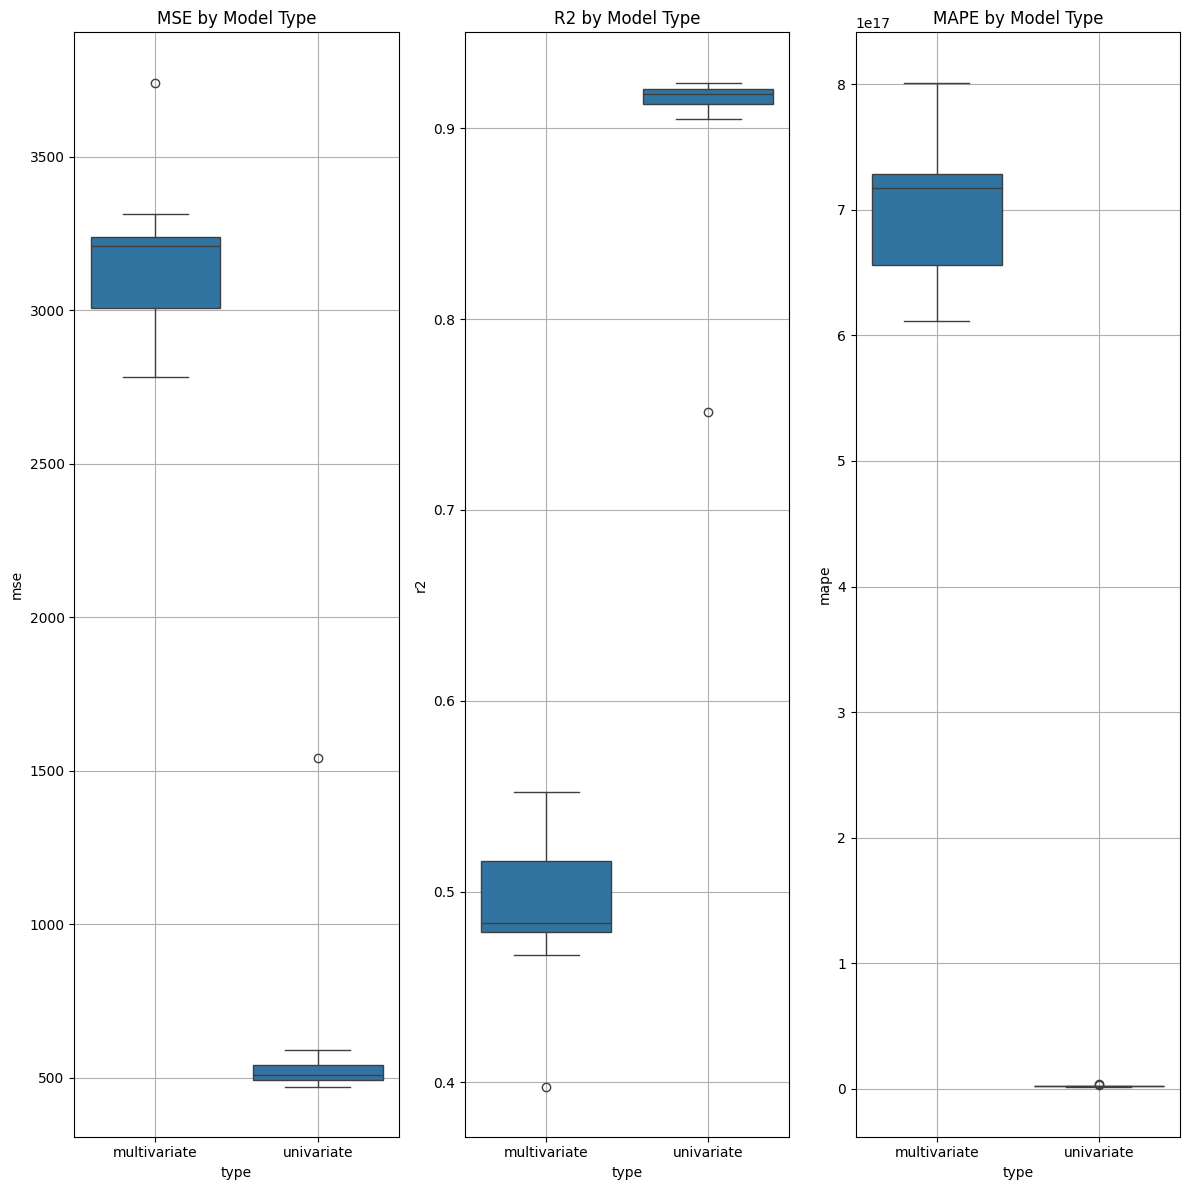

In [129]:
plt.figure(figsize=(12, 12))
metrics = ['mse', 'r2', 'mape']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=nn_df, x='type', y=metric)
    plt.title(f'{metric.upper()} by Model Type')
    plt.grid(True)

plt.tight_layout()
plt.show()

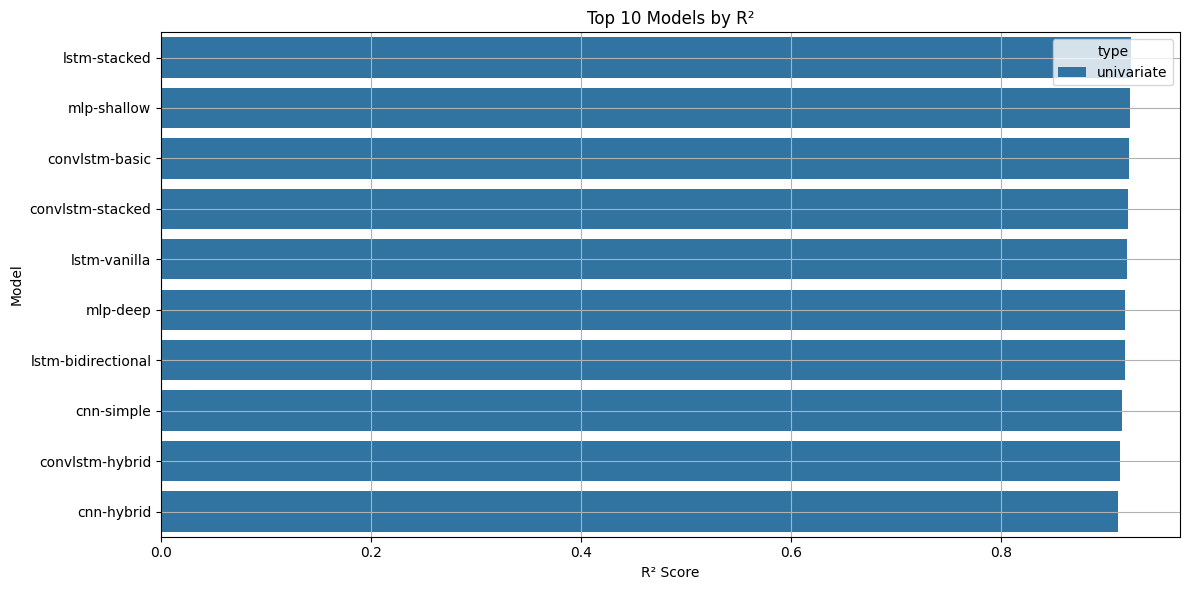

In [130]:
top_r2 = nn_df.sort_values(by='r2', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_r2, x='r2', y='model_name', hue='type')
plt.title('Top 10 Models by R²')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.grid(True)
plt.tight_layout()
plt.show()

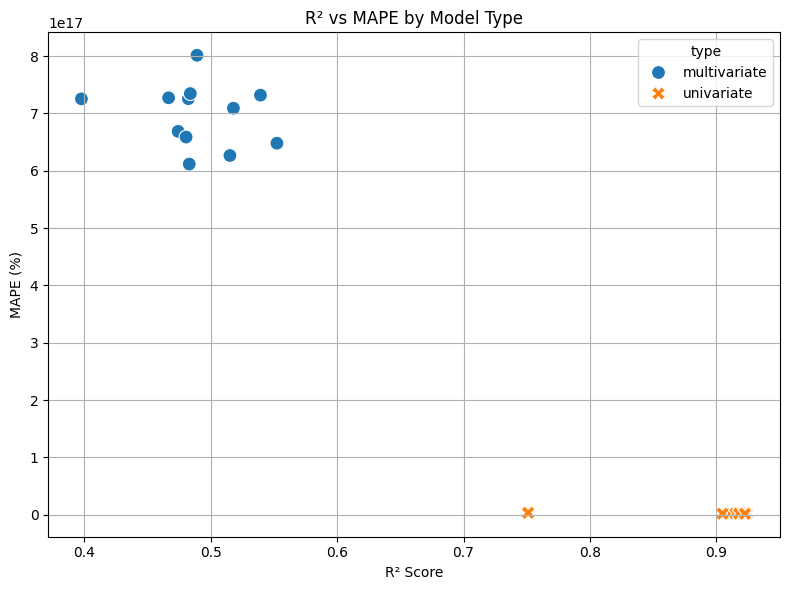

In [131]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=nn_df, x='r2', y='mape', hue='type', style='type', s=100)
plt.title('R² vs MAPE by Model Type')
plt.xlabel('R² Score')
plt.ylabel('MAPE (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

Al comparar los resultados de los modelos univariados contra los multivariados, podemos ver que el mejor fue la lstm univariada, con la arquitectura stacked. Los modelos multivariados dieron muy pobres resultados, esto puede ser debido al cómo se pre-procesaron los datos. 

### Comparación univariados vs SARIMAX

In [132]:
uni_models = runs_df[runs_df['type'].isin(['univariate', 'SARIMAX'])]

In [133]:
uni_models.sort_values(by='mse', ascending=True)


run_id          model_name          mse  \
16  89c31e98481c451ab3126f1140a2bbd6        lstm-stacked   471.310378   
23  783c71669d6d4c1099aecab6e84e1d4a         mlp-shallow   480.019419   
14  43512206c0b54dcba0d0ae7468c88f53      convlstm-basic   486.454771   
13  40038c41faa14072b494bd4f611b8b6e    convlstm-stacked   494.606215   
17  e2a325cad9a54489ba49eb5af01a4efb        lstm-vanilla   499.360982   
22  78a77457898543b19a273dee9ade27c9            mlp-deep   508.789611   
15  c5b6e9127622420dbd97462e9daf8ee7  lstm-bidirectional   510.335937   
20  eeb7a92fcd7f4a829f1762e590f86715          cnn-simple   526.580966   
12  867eb0e36c39490e81278d32121db21e     convlstm-hybrid   539.834114   
18  e0488964434c4a94a7ca9d47d96a1aab          cnn-hybrid   548.352035   
21  2b9a8defdc244834aeb0cf932f556251            mlp-wide   589.753193   
19  0d9f438dcda14669aa1e9e2b01df33e4            cnn-deep  1542.724684   
24  230acf3460204647b777d7ab5de875d7     dashing-ant-978  9878.287400   

          r2          mape        type  
16  0.923952  1.981806e+15  univariate  
23  0.922546  1.831309e+15  univariate  
14  0.921508  2.233147e+15  univariate  
13  0.920193  1.982979e+15  univariate  
17  0.919426  2.419229e+15  univariate  
22  0.917904  2.025740e+15  univariate  
15  0.917655  2.956145e+15  univariate  
20  0.915033  2.103776e+15  univariate  
12  0.912895  2.070631e+15  univariate  
18  0.911521  2.067101e+15  univariate  
21  0.904840  1.988235e+15  univariate  
19  0.751073  3.509285e+15  univariate  
24 -0.102501  3.350236e+15     SARIMAX

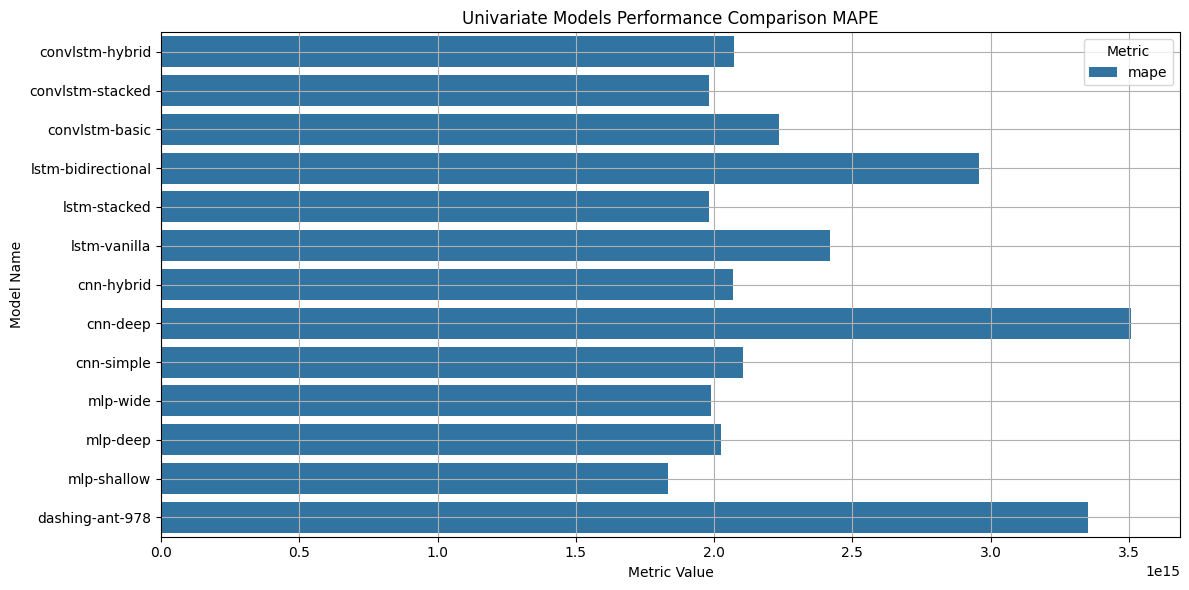

In [134]:
melted_uni = uni_models.melt(id_vars='model_name', value_vars=['mape'], 
                              var_name='metric', value_name='value')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_uni, x='value', y='model_name', hue='metric')
plt.title('Univariate Models Performance Comparison MAPE')
plt.xlabel('Metric Value')
plt.ylabel('Model Name')
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()

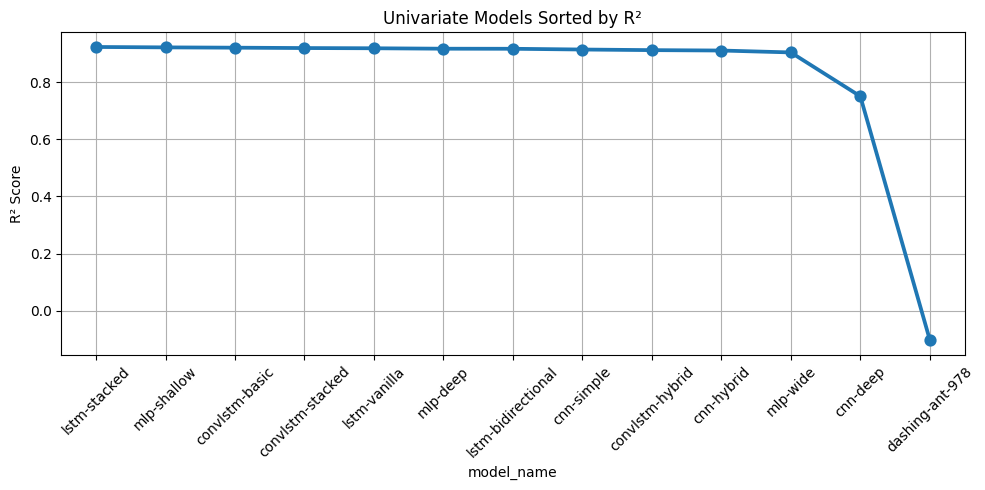

In [135]:
plt.figure(figsize=(10, 5))
sorted_df = uni_models.sort_values(by='r2', ascending=False)
sns.pointplot(data=sorted_df, x='model_name', y='r2', marker='o')
plt.title('Univariate Models Sorted by R²')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Vamos a graficar los resultados de la lstm-stacked vs sarimax vs reales

In [157]:
order = (2, 0, 0)
seasonal_order = (1, 1, 1, 24)

# Fit model
model = SARIMAX(train_transformed, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# Forecast
forecast_trans = results.forecast(steps=len(test_transformed))
forecast_trans = pd.DataFrame(forecast_trans)
forecast_inv = pt.inverse_transform(forecast_trans).flatten()

In [161]:
X_train_lstm = univariate_data['X_train_lstm']
y_train = univariate_data['y_train']
X_val_lstm = univariate_data['X_val_lstm']
y_val = univariate_data['y_val']
X_test_lstm = univariate_data['X_test_lstm']
y_test = univariate_data['y_test']

In [170]:
# Load the model
mlflow_model_uri = "runs:/89c31e98481c451ab3126f1140a2bbd6/aqi_model"
model = mlflow.keras.load_model(mlflow_model_uri)

In [ ]:
y_pred = model.predict(X_test_lstm)
y_test_actual = univariate_data['scaler'].inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = univariate_data['scaler'].inverse_transform(y_pred.reshape(-1, 1))

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


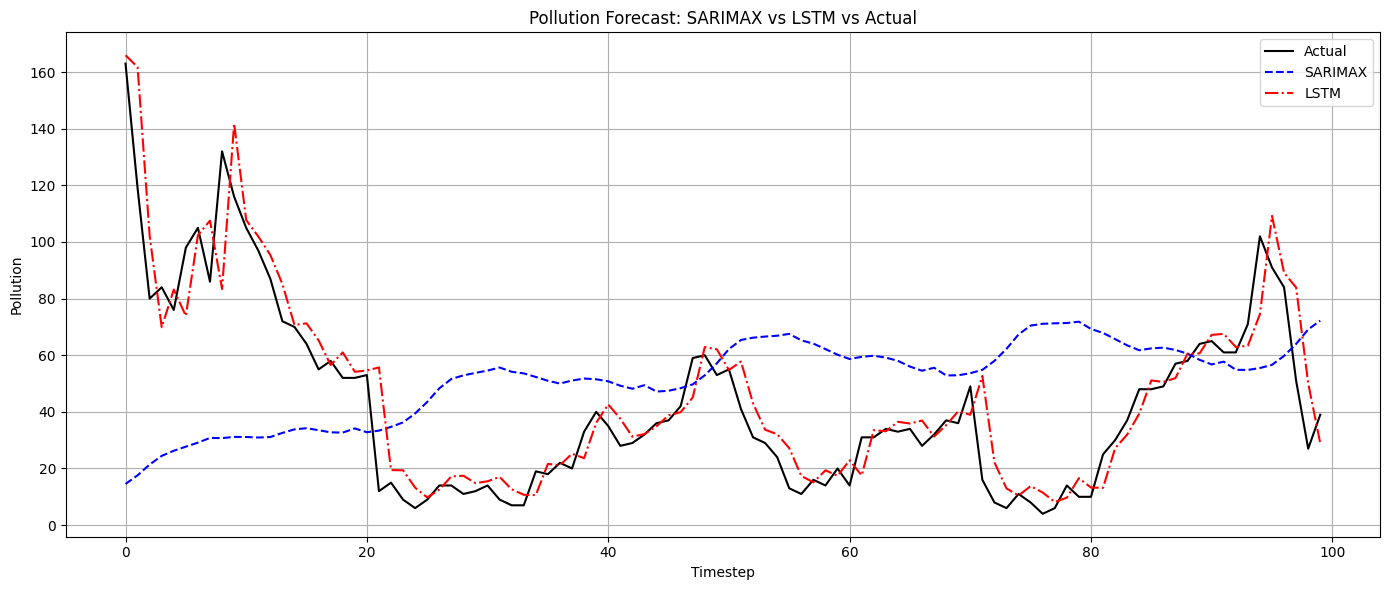

In [172]:
# Set a sample range to avoid clutter (e.g., first 200 samples)
plot_range = 100

plt.figure(figsize=(14, 6))

plt.plot(y_test_actual[:plot_range], label='Actual', color='black')
plt.plot(forecast_inv[:plot_range], label='SARIMAX', color='blue', linestyle='--')
plt.plot(y_pred_actual[:plot_range], label='LSTM', color='red', linestyle='-.')

plt.title("Pollution Forecast: SARIMAX vs LSTM vs Actual")
plt.xlabel("Timestep")
plt.ylabel("Pollution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Se puede ver que el modelo LSTM tiene muchas mejores predicciones que el SARIMAX

### Optimización con Optuna

Vamos a optimizar nuestro modelo LSTM univariado, la arquitectura 'Stacked' con optuna para ver si obtenemos mejores resultados.

In [173]:
X_train_lstm.shape, y_train.shape, X_val_lstm.shape, y_val.shape, X_test_lstm.shape, y_test.shape

((30643, 24, 1),
 (30643, 1),
 (6566, 24, 1),
 (6566, 1),
 (6567, 24, 1),
 (6567, 1))

In [178]:
# Encontrar mejores hiperparámetros con Optuna con datos por factor de 10
X_train_opt = X_train_lstm[::10]
y_train_opt = y_train[::10]
X_val_opt = X_val_lstm[::10]
y_val_opt = y_val[::10]
X_test_opt = X_test_lstm[::10]
y_test_opt = y_test[::10]
n_future = 1
X_train_opt.shape, y_train_opt.shape, X_val_opt.shape, y_val_opt.shape, X_test_opt.shape, y_test_opt.shape

((3065, 24, 1), (3065, 1), (657, 24, 1), (657, 1), (657, 24, 1), (657, 1))

In [181]:
import optuna
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

def create_stacked_lstm(trial, input_shape, n_future):
    """Create stacked LSTM model with hyperparameters suggested by Optuna"""
    # Hyperparameters to tune
    lstm1_units = trial.suggest_int('lstm1_units', 32, 256, step=16)
    lstm2_units = trial.suggest_int('lstm2_units', 16, 128, step=16)
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.8, step=0.01)
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.8, step=0.01)
    learning_rate = trial.suggest_float('learning_rate', 1e-9, 1e-2, log=True)
    
    # Build model
    model = Sequential([
        LSTM(lstm1_units, activation='tanh', return_sequences=True, input_shape=input_shape),
        Dropout(dropout1),
        LSTM(lstm2_units, activation='tanh'),
        Dropout(dropout2),
        Dense(n_future)
    ], name='stacked_lstm_optuna')
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse'
    )
    
    return model

def objective(trial):
    """Objective function for Optuna to optimize"""
    # Create model
    model = create_stacked_lstm(trial, X_train_opt.shape[1:], n_future)
    
    # Training parameters
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = 200  # Fixed, early stopping will handle
    
    # Train with early stopping
    history = model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=50, restore_best_weights=True)],
        verbose=0
    )
    
    # Evaluate on test set
    y_pred = model.predict(X_test_opt)
    mse = mean_squared_error(y_test_opt, y_pred)
    
    return mse

# Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=7200, show_progress_bar=True)  # 50 trials or 2 hours

# Best trial results
print("Best trial:")
trial = study.best_trial
print(f"  Value (MSE): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train final model with best hyperparameters
best_model = create_stacked_lstm(study.best_trial, X_train_lstm.shape[1:], n_future)
history_best = best_model.fit(
    np.concatenate([X_train_lstm, X_val_lstm]),  # Use all available data
    np.concatenate([y_train, y_val]),
    epochs=200,
    batch_size=study.best_params['batch_size'],
    callbacks=[EarlyStopping(patience=50, monitor='loss', restore_best_weights=True)],
    verbose=1
)

[I 2025-05-15 11:50:48,036] A new study created in memory with name: no-name-5b606864-1959-4378-b57b-b6905b9792e0
  0%|          | 0/50 [00:00<?, ?it/s]/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Best trial: 0. Best value: 0.0492087:   2%|▏         | 1/50 [02:15<1:50:18, 135.08s/it, 135.08/7200 seconds]

[I 2025-05-15 11:53:03,139] Trial 0 finished with value: 0.04920869656652963 and parameters: {'lstm1_units': 80, 'lstm2_units': 48, 'dropout1': 0.51, 'dropout2': 0.69, 'learning_rate': 0.00836454456763935, 'batch_size': 32}. Best is trial 0 with value: 0.04920869656652963.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Best trial: 0. Best value: 0.0492087:   4%|▍         | 2/50 [07:02<2:59:52, 224.84s/it, 422.75/7200 seconds]

[I 2025-05-15 11:57:50,811] Trial 1 finished with value: 0.6031987447603355 and parameters: {'lstm1_units': 112, 'lstm2_units': 96, 'dropout1': 0.27, 'dropout2': 0.67, 'learning_rate': 3.5574531005088882e-09, 'batch_size': 64}. Best is trial 0 with value: 0.04920869656652963.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Best trial: 2. Best value: 0.0465203:   6%|▌         | 3/50 [10:49<2:56:48, 225.71s/it, 649.49/7200 seconds]

[I 2025-05-15 12:01:37,551] Trial 2 finished with value: 0.046520322705883764 and parameters: {'lstm1_units': 192, 'lstm2_units': 16, 'dropout1': 0.41000000000000003, 'dropout2': 0.61, 'learning_rate': 0.002209706462058422, 'batch_size': 32}. Best is trial 2 with value: 0.046520322705883764.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Best trial: 3. Best value: 0.0434148:   8%|▊         | 4/50 [14:14<2:46:41, 217.43s/it, 854.23/7200 seconds]

[I 2025-05-15 12:05:02,296] Trial 3 finished with value: 0.04341480105176869 and parameters: {'lstm1_units': 128, 'lstm2_units': 32, 'dropout1': 0.65, 'dropout2': 0.79, 'learning_rate': 0.0015183492494837399, 'batch_size': 64}. Best is trial 3 with value: 0.04341480105176869.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Best trial: 3. Best value: 0.0434148:  10%|█         | 5/50 [17:41<2:40:11, 213.59s/it, 1061.01/7200 seconds]

[I 2025-05-15 12:08:29,070] Trial 4 finished with value: 0.13999914321439144 and parameters: {'lstm1_units': 32, 'lstm2_units': 96, 'dropout1': 0.27, 'dropout2': 0.55, 'learning_rate': 3.25778552932766e-06, 'batch_size': 32}. Best is trial 3 with value: 0.04341480105176869.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Best trial: 3. Best value: 0.0434148:  12%|█▏        | 6/50 [25:20<3:37:55, 297.16s/it, 1520.41/7200 seconds]

[I 2025-05-15 12:16:08,470] Trial 5 finished with value: 0.045452633842017975 and parameters: {'lstm1_units': 224, 'lstm2_units': 96, 'dropout1': 0.18, 'dropout2': 0.64, 'learning_rate': 0.0008074063593843402, 'batch_size': 64}. Best is trial 3 with value: 0.04341480105176869.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Best trial: 3. Best value: 0.0434148:  14%|█▍        | 7/50 [28:04<3:01:51, 253.75s/it, 1684.78/7200 seconds]

[I 2025-05-15 12:18:52,848] Trial 6 finished with value: 0.4477696051274899 and parameters: {'lstm1_units': 32, 'lstm2_units': 128, 'dropout1': 0.77, 'dropout2': 0.62, 'learning_rate': 1.789598024625284e-09, 'batch_size': 128}. Best is trial 3 with value: 0.04341480105176869.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Best trial: 3. Best value: 0.0434148:  16%|█▌        | 8/50 [34:24<3:25:47, 293.98s/it, 2064.89/7200 seconds]

[I 2025-05-15 12:25:12,956] Trial 7 finished with value: 0.05362298236048692 and parameters: {'lstm1_units': 144, 'lstm2_units': 128, 'dropout1': 0.42000000000000004, 'dropout2': 0.32, 'learning_rate': 2.3438208873088464e-05, 'batch_size': 64}. Best is trial 3 with value: 0.04341480105176869.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Best trial: 3. Best value: 0.0434148:  18%|█▊        | 9/50 [39:24<3:21:59, 295.59s/it, 2364.03/7200 seconds]

[I 2025-05-15 12:30:12,099] Trial 8 finished with value: 0.140064979151512 and parameters: {'lstm1_units': 192, 'lstm2_units': 32, 'dropout1': 0.71, 'dropout2': 0.58, 'learning_rate': 3.91036668750002e-06, 'batch_size': 64}. Best is trial 3 with value: 0.04341480105176869.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Best trial: 9. Best value: 0.0430549:  20%|██        | 10/50 [43:47<3:10:29, 285.74s/it, 2627.71/7200 seconds]

[I 2025-05-15 12:34:35,776] Trial 9 finished with value: 0.04305485942737916 and parameters: {'lstm1_units': 128, 'lstm2_units': 80, 'dropout1': 0.71, 'dropout2': 0.2, 'learning_rate': 0.0008261474331634832, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Best trial: 9. Best value: 0.0430549:  22%|██▏       | 11/50 [48:58<3:10:43, 293.41s/it, 2938.52/7200 seconds]

[I 2025-05-15 12:39:46,586] Trial 10 finished with value: 0.4245167801943139 and parameters: {'lstm1_units': 256, 'lstm2_units': 64, 'dropout1': 0.5700000000000001, 'dropout2': 0.13, 'learning_rate': 5.048403191501416e-08, 'batch_size': 128}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Best trial: 9. Best value: 0.0430549:  24%|██▍       | 12/50 [52:53<2:54:39, 275.78s/it, 3173.96/7200 seconds]

[I 2025-05-15 12:43:42,026] Trial 11 finished with value: 0.047058569956507486 and parameters: {'lstm1_units': 112, 'lstm2_units': 64, 'dropout1': 0.65, 'dropout2': 0.33999999999999997, 'learning_rate': 0.00019787580607755824, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Best trial: 9. Best value: 0.0430549:  26%|██▌       | 13/50 [56:48<2:42:26, 263.41s/it, 3408.92/7200 seconds]

[I 2025-05-15 12:47:36,988] Trial 12 finished with value: 0.06604716680746626 and parameters: {'lstm1_units': 160, 'lstm2_units': 16, 'dropout1': 0.63, 'dropout2': 0.8, 'learning_rate': 8.735163050361275e-05, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Best trial: 9. Best value: 0.0430549:  28%|██▊       | 14/50 [1:00:41<2:32:23, 253.98s/it, 3641.10/7200 seconds]

[I 2025-05-15 12:51:29,161] Trial 13 finished with value: 0.3069667773355708 and parameters: {'lstm1_units': 80, 'lstm2_units': 80, 'dropout1': 0.78, 'dropout2': 0.1, 'learning_rate': 1.7918750846674418e-07, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Best trial: 9. Best value: 0.0430549:  30%|███       | 15/50 [1:02:48<2:05:57, 215.94s/it, 3768.90/7200 seconds]

[I 2025-05-15 12:53:36,960] Trial 14 finished with value: 0.04711708147452628 and parameters: {'lstm1_units': 144, 'lstm2_units': 48, 'dropout1': 0.53, 'dropout2': 0.25, 'learning_rate': 0.008620542213241567, 'batch_size': 128}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Best trial: 9. Best value: 0.0430549:  32%|███▏      | 16/50 [1:05:53<1:56:59, 206.46s/it, 3953.33/7200 seconds]

[I 2025-05-15 12:56:41,391] Trial 15 finished with value: 0.04556358249609626 and parameters: {'lstm1_units': 96, 'lstm2_units': 48, 'dropout1': 0.67, 'dropout2': 0.45000000000000007, 'learning_rate': 0.0002792638789230349, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Best trial: 9. Best value: 0.0430549:  32%|███▏      | 16/50 [1:11:25<1:56:59, 206.46s/it, 3953.33/7200 seconds]

[I 2025-05-15 13:02:13,187] Trial 16 finished with value: 0.0693980674960696 and parameters: {'lstm1_units': 176, 'lstm2_units': 32, 'dropout1': 0.8, 'dropout2': 0.45999999999999996, 'learning_rate': 2.2842040067779094e-05, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


Best trial: 9. Best value: 0.0430549:  34%|███▍      | 17/50 [1:11:25<2:14:16, 244.15s/it, 4285.12/7200 seconds]/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Best trial: 9. Best value: 0.0430549:  36%|███▌      | 18/50 [1:16:11<2:16:59, 256.86s/it, 4571.58/7200 seconds]

[I 2025-05-15 13:06:59,642] Trial 17 finished with value: 0.04509929263744175 and parameters: {'lstm1_units': 128, 'lstm2_units': 80, 'dropout1': 0.61, 'dropout2': 0.8, 'learning_rate': 0.001001951300355973, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Best trial: 9. Best value: 0.0430549:  38%|███▊      | 19/50 [1:19:43<2:05:42, 243.30s/it, 4783.30/7200 seconds]

[I 2025-05-15 13:10:31,365] Trial 18 finished with value: 0.3111932188927794 and parameters: {'lstm1_units': 64, 'lstm2_units': 112, 'dropout1': 0.71, 'dropout2': 0.2, 'learning_rate': 3.921502912908801e-07, 'batch_size': 128}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


Best trial: 9. Best value: 0.0430549:  40%|████      | 20/50 [1:38:40<4:15:48, 511.61s/it, 5920.26/7200 seconds]

[I 2025-05-15 13:29:28,326] Trial 19 finished with value: 0.048851581207127126 and parameters: {'lstm1_units': 224, 'lstm2_units': 32, 'dropout1': 0.47, 'dropout2': 0.35, 'learning_rate': 4.7876048111805325e-05, 'batch_size': 32}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Best trial: 9. Best value: 0.0430549:  40%|████      | 20/50 [1:42:21<4:15:48, 511.61s/it, 5920.26/7200 seconds]

[I 2025-05-15 13:33:09,322] Trial 20 finished with value: 0.04440233615907934 and parameters: {'lstm1_units': 128, 'lstm2_units': 64, 'dropout1': 0.36, 'dropout2': 0.49, 'learning_rate': 0.0015666127770954245, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


Best trial: 9. Best value: 0.0430549:  42%|████▏     | 21/50 [1:42:21<3:25:07, 424.38s/it, 6141.26/7200 seconds]/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Best trial: 9. Best value: 0.0430549:  44%|████▍     | 22/50 [1:45:04<2:41:28, 346.00s/it, 6304.48/7200 seconds]

[I 2025-05-15 13:35:52,546] Trial 21 finished with value: 0.04512733612128331 and parameters: {'lstm1_units': 128, 'lstm2_units': 64, 'dropout1': 0.36, 'dropout2': 0.49, 'learning_rate': 0.0018111030154551, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Best trial: 9. Best value: 0.0430549:  44%|████▍     | 22/50 [1:50:10<2:41:28, 346.00s/it, 6304.48/7200 seconds]

[I 2025-05-15 13:40:58,445] Trial 22 finished with value: 0.0473451528367585 and parameters: {'lstm1_units': 160, 'lstm2_units': 80, 'dropout1': 0.33999999999999997, 'dropout2': 0.72, 'learning_rate': 0.0003240614219588523, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


Best trial: 9. Best value: 0.0430549:  46%|████▌     | 23/50 [1:50:10<2:30:17, 333.97s/it, 6610.38/7200 seconds]/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Best trial: 9. Best value: 0.0430549:  46%|████▌     | 23/50 [1:52:38<2:30:17, 333.97s/it, 6610.38/7200 seconds]

[I 2025-05-15 13:43:26,756] Trial 23 finished with value: 0.04452306379013373 and parameters: {'lstm1_units': 128, 'lstm2_units': 48, 'dropout1': 0.56, 'dropout2': 0.52, 'learning_rate': 0.0034151373083152903, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


Best trial: 9. Best value: 0.0430549:  48%|████▊     | 24/50 [1:52:38<2:00:34, 278.26s/it, 6758.69/7200 seconds]/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Best trial: 9. Best value: 0.0430549:  50%|█████     | 25/50 [1:56:11<1:47:45, 258.61s/it, 6971.47/7200 seconds]

[I 2025-05-15 13:46:59,535] Trial 24 finished with value: 0.08998835162551073 and parameters: {'lstm1_units': 96, 'lstm2_units': 64, 'dropout1': 0.2, 'dropout2': 0.38, 'learning_rate': 9.325326502131043e-06, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.


/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Best trial: 9. Best value: 0.0430549:  52%|█████▏    | 26/50 [2:00:11<1:50:57, 277.38s/it, 7211.77/7200 seconds]

[I 2025-05-15 13:50:59,828] Trial 25 finished with value: 0.04765359426403433 and parameters: {'lstm1_units': 64, 'lstm2_units': 112, 'dropout1': 0.71, 'dropout2': 0.26, 'learning_rate': 0.00035468111771317094, 'batch_size': 64}. Best is trial 9 with value: 0.04305485942737916.
Best trial:
  Value (MSE): 0.0431
  Params: 
    lstm1_units: 128
    lstm2_units: 80
    dropout1: 0.71
    dropout2: 0.2
    learning_rate: 0.0008261474331634832
    batch_size: 64
Epoch 1/200



/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.1807
Epoch 2/200
  5/582 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0580

/Users/erick/Library/CloudStorage/OneDrive-ITESO/Modelos/proyecto-modelos/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0842
Epoch 3/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0721
Epoch 4/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0726
Epoch 5/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0687
Epoch 6/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0734
Epoch 7/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0688
Epoch 8/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 0.0711
Epoch 9/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0652
Epoch 10/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 0.0657
Epoch 11/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 0.0707
Epoch 12/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - loss: 0.0674
Epoch 13/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 0.0673
Epoch 14/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0703
Epoch 15/200
582/582 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 0.0635
Epoch 16/200
582/582 ━━━━━

La optimización de Optuna nos dió los siguientes parámetros para nuestro modelo LSTM:

+ lstm1_units: 128
+ lstm2_units: 80
+ dropout1: 0.71
+ dropout2: 0.2
+ learning_rate: 0.0008261474331634832
+ batch_size: 64

Ya al entrenar la red con estos parámetros, vamos a evaluarla y loggearlo a mlflow.

In [193]:
def evaluate_optuna_model(
    model,
    X_test,
    y_test,
    scaler=None,
    n_steps_in=24,
    n_steps_out=1
):
    """
    Evaluates an Optuna-tuned LSTM model with full metrics and visualization.
    
    Args:
        model: Trained Keras model
        X_test: Test features (samples, timesteps, features)
        y_test: Test targets (samples, n_steps_out)
        X_train/y_train: Optional training data for comparison plots
        scaler: Optional scaler for inverse transformation
        n_steps_in: Lookback window size
        n_features: Number of features
        n_steps_out: Forecast horizon
        log_to_dagshub: Whether to log to DagsHub
        run_name: Name for the evaluation run
    
    Returns:
        Dictionary of evaluation metrics
    """
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform if scaler provided
    if scaler:
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    else:
        y_test_actual = y_test.flatten()
        y_pred_actual = y_pred.flatten()
    
    # Calculate metrics
    metrics = {
        'mse': mean_squared_error(y_test_actual, y_pred_actual),
        'mape': np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100,
        'r2': r2_score(y_test_actual, y_pred_actual)
    }
    
    # Generate plots
    plt.figure(figsize=(15, 6))
    
    # Plot predictions vs actual
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_actual, y_pred_actual, alpha=0.6)
    plt.plot([min(y_test_actual), max(y_test_actual)], 
             [min(y_test_actual), max(y_test_actual)], 
             'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction vs Actual (Test Set)')
    
    plt.show()
    
    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"R²: {metrics['r2']:.4f}")
    
    return metrics

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/var/folders/_2/qz8xy45s0fv244xptjd5jqjw0000gp/T/ipykernel_2398/2060923211.py:42: RuntimeWarning: divide by zero encountered in divide
  'mape': np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100,


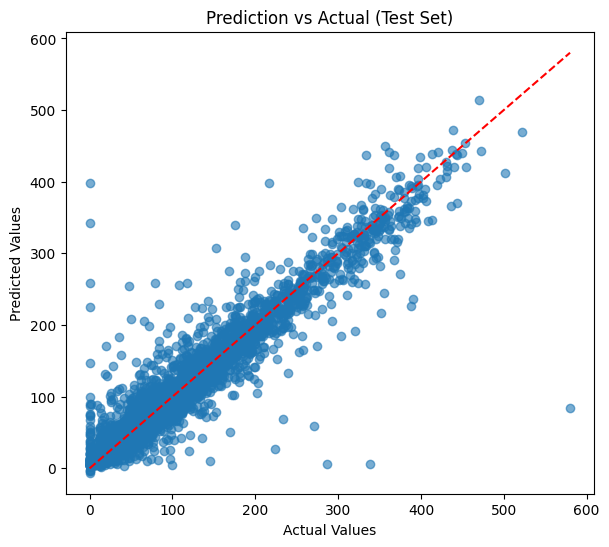


Evaluation Metrics:
MSE: 526.6513
MAPE: inf%
R²: 0.9150


{'mse': 526.6513407512915, 'mape': np.float64(inf), 'r2': 0.9150220944645842}

In [194]:
evaluate_optuna_model(best_model, X_test_lstm, y_test, scaler=univariate_data['scaler'], n_steps_in=n_steps_in, n_steps_out=n_future)

In [210]:
def log_model_to_dagshub(
    model,
    X_test,
    y_test,
    run_name,
    metrics=None,
    scaler=None,
    n_steps_in=24):
    """
    Logs trained model and evaluation results to DagsHub.
    
    Args:
        model: Trained Keras model
        X_test: Test features (samples, timesteps, features)
        y_test: Test targets (samples, 1)
        run_name: Name for the DagsHub run
        params: Dictionary of model parameters
        metrics: Optional pre-computed metrics
        scaler: Optional scaler for inverse transform
        n_steps_in: Lookback window size
        n_features: Number of features
    """
    
    with mlflow.start_run(run_name=run_name):
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Inverse transform if scaler provided
        if scaler:
            y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
            y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
        
        # Compute metrics if not provided
        if metrics is None:
            metrics = {
                'MSE': mean_squared_error(y_test, y_pred),
                'MAPE': mean_absolute_percentage_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred)
            }
        
        # Log metrics
        mlflow.log_metrics(metrics)
        
        # Log model
        mlflow.keras.log_model(model, "model")
        
        print(f"Successfully logged {run_name} to DagsHub")
        print(f"Test MSE: {metrics['MSE']:.4f}, MAPE: {metrics['MAPE']:.4f}, R²: {metrics['R2']:.4f}")

In [211]:
# Log to DagsHub
log_model_to_dagshub(
    model=best_model,
    X_test=X_test_lstm,
    y_test=y_test,
    run_name="optuna_lstm",
    scaler=univariate_data['scaler']
)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


2025/05/15 16:04:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/15 16:04:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully logged optuna_lstm to DagsHub
Test MSE: 526.6513, MAPE: 2108368246105884.0000, R²: 0.9150
🏃 View run optuna_lstm at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2/runs/37cb0a96d77d4da2bb5bc096343d8d04
🧪 View experiment at: https://dagshub.com/daduke1/proyecto-modelos.mlflow/#/experiments/2
